In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [3]:
# Display full table with all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)

# 0. Load and look at the data


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [4]:
data = pd.read_parquet('../bike_counters/data/train.parquet')
data_copy = data.copy()
data.head()

counter_id              counter_name    site_id  \
48321  100007049-102007049  28 boulevard Diderot E-O  100007049   
48324  100007049-102007049  28 boulevard Diderot E-O  100007049   
48327  100007049-102007049  28 boulevard Diderot E-O  100007049   
48330  100007049-102007049  28 boulevard Diderot E-O  100007049   
48333  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
48321  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

      counter_installation_date         coordinates counter_technical_id  \
48321                2013-01-18  48.846028,2.375429          Y2H15027244   
48324                2013-01-18  48.846028,2.375429          Y2H15027244   
48327                2013-01-18  48.846028,2.375429          Y2H15027244   
48330                2013-01-18  48.846028,2.375429          Y2H15027244   
48333                2013-01-18  48.846028,2.375429          Y2H15027244   

        latitude  longitude  log_bike_count  
48321  48.846028   2.375429        0.000000  
48324  48.846028   2.375429        0.693147  
48327  48.846028   2.375429        0.000000  
48330  48.846028   2.375429        1.609438  
48333  48.846028   2.375429        2.302585

In [5]:
test_data = pd.read_parquet('../bike_counters/data/final_test.parquet')

We can check general information about different columns:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

and in particular the number of unique entries in each column,

In [7]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [8]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_20489/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


bike_count
site_name                        counter_name                                    
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol S-N   1992227.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli O-E             1551730.0
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol N-S   1497912.0
67 boulevard Voltaire SE-NO      67 boulevard Voltaire SE-NO            1130565.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli E-O             1015875.0
27 quai de la Tournelle          27 quai de la Tournelle SE-NO           984914.0
Quai d'Orsay                     Quai d'Orsay E-O                        948357.0
Totem Cours la Reine             Totem Cours la Reine O-E                894937.0
Face au 48 quai de la marne      Face au 48 quai de la marne SO-NE       884907.0
                                 Face au 48 quai de la marne NE-SO       833657.0

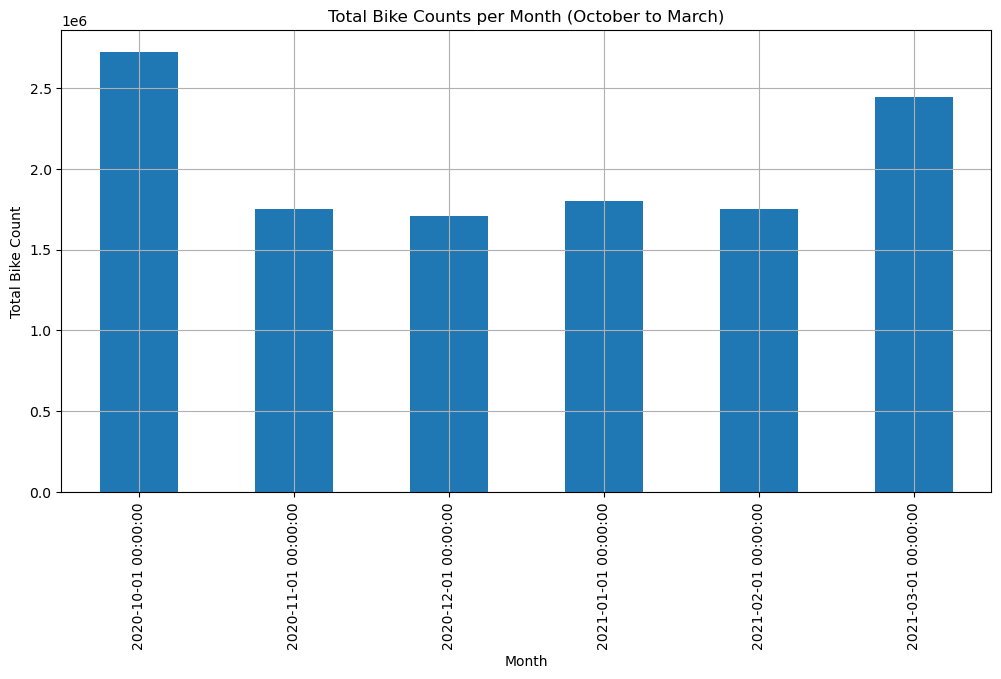

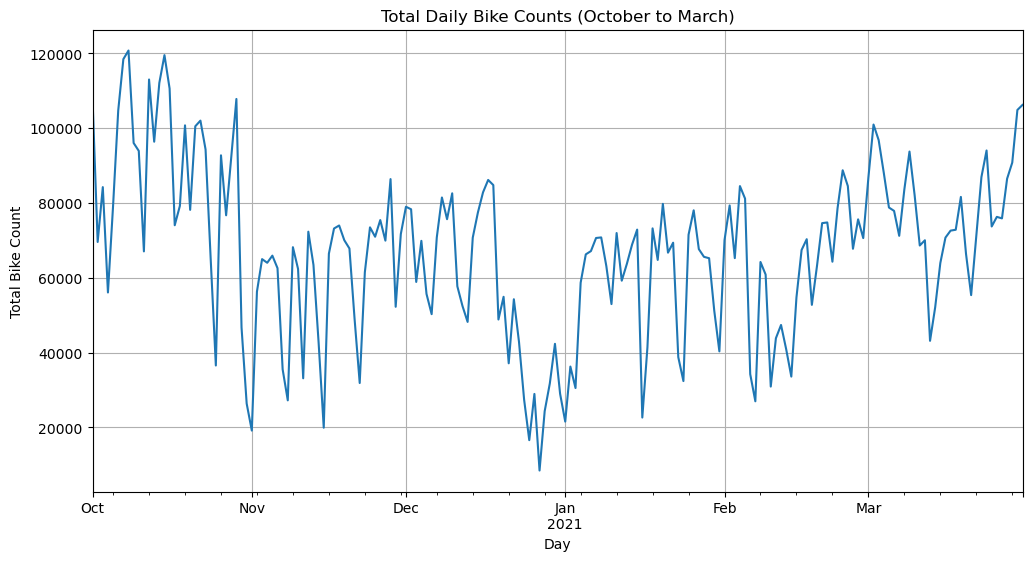

In [9]:
# Filter data between October and March
oct_mar_data = data[(data['date'].dt.month >= 10) | (data['date'].dt.month <= 3)]

# Plot the monthly bike counts for the filtered data
plt.figure(figsize=(12, 6))
monthly_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('M'))['bike_count'].sum()
monthly_bike_counts_oct_mar.index = monthly_bike_counts_oct_mar.index.to_timestamp()
monthly_bike_counts_oct_mar.plot(kind='bar')
plt.title('Total Bike Counts per Month (October to March)')
plt.xlabel('Month')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

# Plot the daily bike counts for each month in the filtered data
daily_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('D'))['bike_count'].sum()
daily_bike_counts_oct_mar.index = daily_bike_counts_oct_mar.index.to_timestamp()

plt.figure(figsize=(12, 6))
daily_bike_counts_oct_mar.plot()
plt.title('Total Daily Bike Counts (October to March)')
plt.xlabel('Day')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

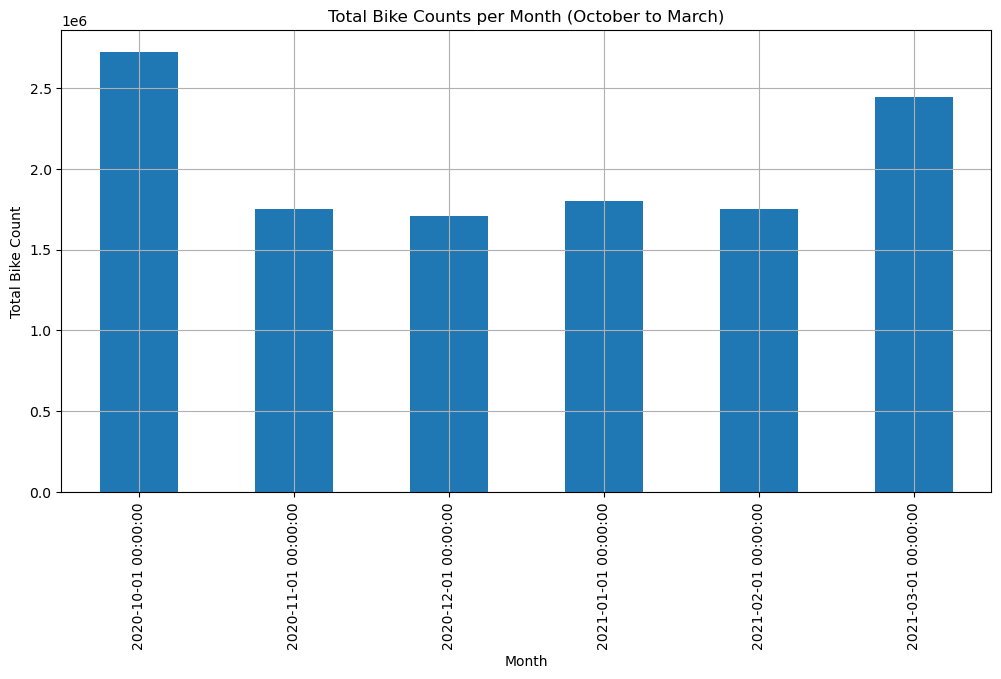

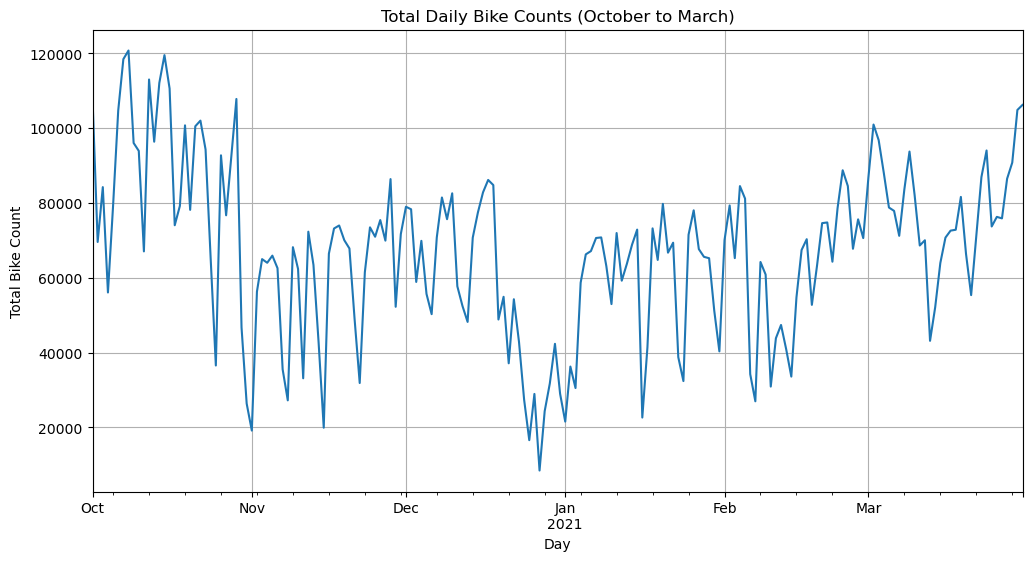

In [10]:
# Filter data between October and March
oct_mar_data = data[(data['date'].dt.month >= 10) | (data['date'].dt.month <= 3)]

# Plot the monthly bike counts for the filtered data
plt.figure(figsize=(12, 6))
monthly_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('M'))['bike_count'].sum()
monthly_bike_counts_oct_mar.index = monthly_bike_counts_oct_mar.index.to_timestamp()
monthly_bike_counts_oct_mar.plot(kind='bar')
plt.title('Total Bike Counts per Month (October to March)')
plt.xlabel('Month')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

# Plot the daily bike counts for each month in the filtered data
daily_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('D'))['bike_count'].sum()
daily_bike_counts_oct_mar.index = daily_bike_counts_oct_mar.index.to_timestamp()

plt.figure(figsize=(12, 6))
daily_bike_counts_oct_mar.plot()
plt.title('Total Daily Bike Counts (October to March)')
plt.xlabel('Day')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

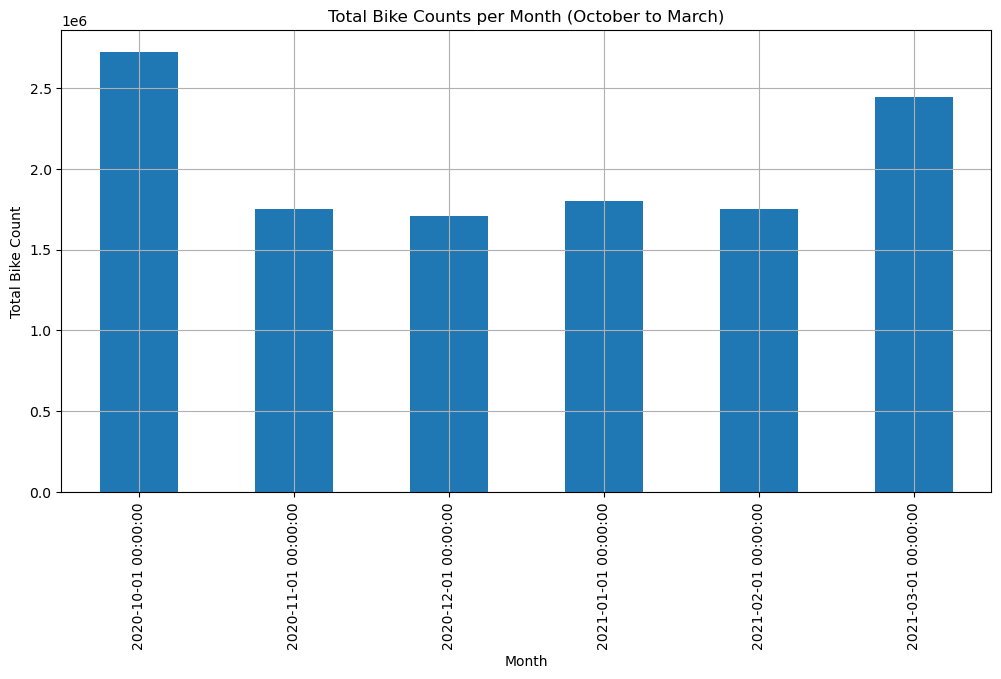

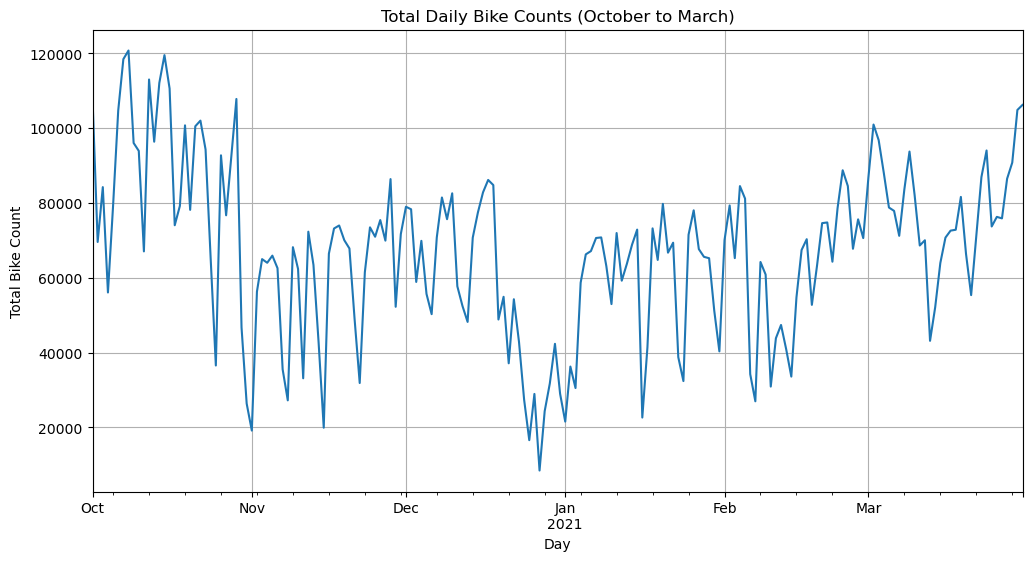

In [11]:
# Filter data between October and March
oct_mar_data = data[(data['date'].dt.month >= 10) | (data['date'].dt.month <= 3)]

# Plot the monthly bike counts for the filtered data
plt.figure(figsize=(12, 6))
monthly_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('M'))['bike_count'].sum()
monthly_bike_counts_oct_mar.index = monthly_bike_counts_oct_mar.index.to_timestamp()
monthly_bike_counts_oct_mar.plot(kind='bar')
plt.title('Total Bike Counts per Month (October to March)')
plt.xlabel('Month')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

# Plot the daily bike counts for each month in the filtered data
daily_bike_counts_oct_mar = oct_mar_data.groupby(oct_mar_data['date'].dt.to_period('D'))['bike_count'].sum()
daily_bike_counts_oct_mar.index = daily_bike_counts_oct_mar.index.to_timestamp()

plt.figure(figsize=(12, 6))
daily_bike_counts_oct_mar.plot()
plt.title('Total Daily Bike Counts (October to March)')
plt.xlabel('Day')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

# 01 Cleaning the data

## Weather Data

In [12]:
weather = pd.read_csv(
    "../bike_counters/external_data/H75 Previous 2020-2022.csv (1).gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

weather = weather[
    (weather["date"] >= data["date"].min())
    & (weather["date"] <= test_data["date"].max())
]

weather_reduced = (
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .interpolate(method="linear")
)

weather_reduced["is_rain"] = (weather_reduced["RR1"] > 0).astype(int)

In [13]:
weather.head()

NUM_POSTE   NOM_USUEL        LAT       LON  ALTI                date  \
5857   75106001  LUXEMBOURG  48.844667  2.333833    46 2020-09-01 01:00:00   
5858   75106001  LUXEMBOURG  48.844667  2.333833    46 2020-09-01 02:00:00   
5859   75106001  LUXEMBOURG  48.844667  2.333833    46 2020-09-01 03:00:00   
5860   75106001  LUXEMBOURG  48.844667  2.333833    46 2020-09-01 04:00:00   
5861   75106001  LUXEMBOURG  48.844667  2.333833    46 2020-09-01 05:00:00   

      RR1  QRR1  DRR1  QDRR1  FF  QFF  DD  QDD  FXY  QFXY  DXY  QDXY  HXY  \
5857  0.0   1.0   NaN    NaN NaN  NaN NaN  NaN  NaN   NaN  NaN   NaN  NaN   
5858  0.0   1.0   NaN    NaN NaN  NaN NaN  NaN  NaN   NaN  NaN   NaN  NaN   
5859  0.0   1.0   NaN    NaN NaN  NaN NaN  NaN  NaN   NaN  NaN   NaN  NaN   
5860  0.0   1.0   NaN    NaN NaN  NaN NaN  NaN  NaN   NaN  NaN   NaN  NaN   
5861  0.0   1.0   NaN    NaN NaN  NaN NaN  NaN  NaN   NaN  NaN   NaN  NaN   

      QHXY  FXI  QFXI  DXI  QDXI  HXI  QHXI  FF2  QFF2  DD2  QDD2  FXI2  \
5857   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   
5858   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   
5859   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   
5860   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   
5861   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   

      QFXI2  DXI2  QDXI2  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HFXI3S  \
5857    NaN   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN     NaN   
5858    NaN   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN     NaN   
5859    NaN   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN     NaN   
5860    NaN   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN     NaN   
5861    NaN   NaN    NaN   NaN    NaN    NaN     NaN    NaN     NaN     NaN   

      QHFXI3S     T   QT  TD  QTD    TN  QTN    HTN  QHTN    TX  QTX    HTX  \
5857      NaN  12.1  1.0 NaN  NaN  12.1  1.0   58.0   9.0  12.7  1.0    1.0   
5858      NaN  11.8  1.0 NaN  NaN  11.8  1.0  157.0   9.0  12.1  1.0  101.0   
5859      NaN  11.8  1.0 NaN  NaN  11.4  1.0  220.0   9.0  11.8  1.0  201.0   
5860      NaN  11.2  1.0 NaN  NaN  11.0  1.0  349.0   9.0  11.7  1.0  301.0   
5861      NaN  10.7  1.0 NaN  NaN  10.7  1.0  456.0   9.0  11.2  1.0  401.0   

      QHTX   DG  QDG  T10  QT10  T20  QT20  T50  QT50  T100  QT100  TNSOL  \
5857   9.0  0.0  9.0  NaN   NaN  NaN   NaN  NaN   NaN   NaN    NaN    NaN   
5858   9.0  0.0  9.0  NaN   NaN  NaN   NaN  NaN   NaN   NaN    NaN    NaN   
5859   9.0  0.0  9.0  NaN   NaN  NaN   NaN  NaN   NaN   NaN    NaN    NaN   
5860   9.0  0.0  9.0  NaN   NaN  NaN   NaN  NaN   NaN   NaN    NaN    NaN   
5861   9.0  0.0  9.0  NaN   NaN  NaN   NaN  NaN   NaN   NaN    NaN    NaN   

      QTNSOL  TN50  QTN50  TCHAUSSEE  QTCHAUSSEE  DHUMEC  QDHUMEC   U  QU  UN  \
5857     NaN   NaN    NaN        NaN         NaN     NaN      NaN NaN NaN NaN   
5858     NaN   NaN    NaN        NaN         NaN     NaN      NaN NaN NaN NaN   
5859     NaN   NaN    NaN        NaN         NaN     NaN      NaN NaN NaN NaN   
5860     NaN   NaN    NaN        NaN         NaN     NaN      NaN NaN NaN NaN   
5861     NaN   NaN    NaN        NaN         NaN     NaN      NaN NaN NaN NaN   

      QUN  HUN  QHUN  UX  QUX  HUX  QHUX  DHUMI40  QDHUMI40  DHUMI80  \
5857  NaN  NaN   NaN NaN  NaN  NaN   NaN      NaN       NaN      NaN   
5858  NaN  NaN   NaN NaN  NaN  NaN   NaN      NaN       NaN      NaN   
5859  NaN  NaN   NaN NaN  NaN  NaN   NaN      NaN       NaN      NaN   
5860  NaN  NaN   NaN NaN  NaN  NaN   NaN      NaN       NaN      NaN   
5861  NaN  NaN   NaN NaN  NaN  NaN   NaN      NaN       NaN      NaN   

      QDHUMI80  TSV  QTSV  PMER  QPMER  PSTAT  QPSTAT  PMERMIN  QPMERMIN  \
5857       NaN  NaN   NaN   NaN    NaN    NaN     NaN      NaN       NaN   
5858       NaN  NaN   NaN   NaN    NaN    NaN     NaN      NaN       NaN   
5859       NaN  NaN   NaN   NaN    NaN    NaN     NaN      NaN

In [14]:
data = data.merge(weather_reduced, on="date", how="left")
test_data = test_data.merge(weather_reduced, on="date", how="left")

In [15]:
data.head()

counter_id              counter_name    site_id  \
0  100007049-102007049  28 boulevard Diderot E-O  100007049   
1  100007049-102007049  28 boulevard Diderot E-O  100007049   
2  100007049-102007049  28 boulevard Diderot E-O  100007049   
3  100007049-102007049  28 boulevard Diderot E-O  100007049   
4  100007049-102007049  28 boulevard Diderot E-O  100007049   

              site_name  bike_count                date  \
0  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
1  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
2  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
3  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
4  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

  counter_installation_date         coordinates counter_technical_id  \
0                2013-01-18  48.846028,2.375429          Y2H15027244   
1                2013-01-18  48.846028,2.375429          Y2H15027244   
2                2013-01-18  48.846028,2.375429          Y2H15027244   
3                2013-01-18  48.846028,2.375429          Y2H15027244   
4                2013-01-18  48.846028,2.375429          Y2H15027244   

    latitude  longitude  log_bike_count        ALTI  RR1  QRR1  DRR1  QDRR1  \
0  48.846028   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0   
1  48.846028   2.375429        0.693147  101.333333  0.0   1.0   0.0    9.0   
2  48.846028   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0   
3  48.846028   2.375429        1.609438  101.333333  0.0   1.0   0.0    9.0   
4  48.846028   2.375429        2.302585  101.333333  0.0   1.0   0.0    9.0   

         FF  QFF          DD  QDD       FXY  QFXY         DXY  QDXY  \
0  1.400000  1.0  110.000000  1.0  2.033333   1.0  120.000000   1.0   
1  1.100000  1.0  113.333333  1.0  1.600000   1.0  116.666667   1.0   
2  1.100000  1.0  103.333333  1.0  1.366667   1.0  116.666667   1.0   
3  3.600000  1.0   30.000000  1.0  4.100000   1.0   30.000000   1.0   
4  3.533333  1.0   26.666667  1.0  4.166667   1.0  140.000000   1.0   

           HXY  QHXY       FXI  QFXI         DXI  QDXI          HXI  QHXI  \
0   140.000000   9.0  3.033333   1.0  170.000000   1.0   122.666667   9.0   
1   243.333333   9.0  2.433333   1.0  133.333333   1.0   223.333333   9.0   
2   348.000000   9.0  1.966667   1.0  120.000000   1.0   344.666667   9.0   
3  1449.666667   9.0  6.566667   1.0   36.666667   1.0  1442.000000   9.0   
4  1724.000000   9.0  6.500000   1.0   33.333333   1.0  1720.000000   9.0   

   FXI3S  QFXI3S  HFXI3S  QHFXI3S          T   QT    TD  QTD         TN  QTN  \
0   1.80     5.0   125.5      9.0  12.250000  1.0  8.55  1.0  12.200000  1.0   
1   1.95     5.0   234.0      9.0  12.133333  1.0  9.00  1.0  11.833333  1.0   
2   1.50     5.0   364.5      9.0  11.616667  1.0  8.45  1.0  11.516667  1.0   
3   5.80     5.0  1440.0      9.0  19.666667  1.0  7.70  1.0  19.583333  1.0   
4   5.15     5.0  1734.0      9.0  18.750000  1.0  7.20  1.0  18.733333  1.0   

           HTN  QHTN         TX  QTX          HTX  QHTX   DG  QDG   T10  QT10  \
0   143.833333   9.0  12.766667  1.0   103.833333   9.0  0.0  9.0  18.3   9.0   
1   235.833333   9.0  12.300000  1.0   216.333333   9.0  0.0  9.0  18.1   9.0   
2   346.833333   9.0  12.116667  1.0   304.000000   9.0  0.0  9.0  17.9   9.0   
3  1455.833333   9.0  21.016667  1.0  1403.333333   9.0  0.0  9.0  19.7   9.0   
4  1748.666667   9.0  19.450000  1.0  1705.166667   9.0  0.0  9.0  19.8   9.0   

    T20  QT20   T50  QT50  T100  QT100  TNSOL  QTNSOL  TN50  QTN50  TCHAUSSEE  \
0  19.1   9.0  19.7   9.0  19.3    9.0   6.90     9.0  12.0    9.0      10.15   
1  18.9   9.0  19.7   9.0  19.3    9.0   6.35     9.0  11.2    9.0       9.70   
2  18.7   9.0  19.7   9.0  19.3    9.0   6.35     9.0  11.4    9.0       9.45   
3  18.9   9.0  19.4   9.0  19.3    9.0  21.25     9.0  20.5    9.0      22.65   
4  19.3   9.0  19.3   9.0  19.2    9.0  18.20     9.0  18.4    9.0      18.30   

   QTCHAUSSEE     U   QU 


## Time Data

In [16]:
# Get the range of dates in the test set
test_date_range = (test_data['date'].min(), test_data['date'].max())
print(f"Test set date range: {test_date_range[0]} to {test_date_range[1]}")

Test set date range: 2021-09-10 01:00:00 to 2021-10-18 21:00:00


To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [17]:
# Features de date basiques
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['hour'] = data['date'].dt.hour
data['week_number'] = data['date'].dt.isocalendar().week
data['period_of_day'] = pd.cut(
   data['hour'], 
   bins=[-1, 4, 9, 17, 20, 23],
   labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
)
# Night hours have significantly more zeros (23:00-04:00)
data['is_night'] = data['hour'].isin([23, 0, 1, 2, 3, 4]).astype(int)

# Early morning transition (5:00-7:00)
data['is_early_morning'] = data['hour'].isin([5, 6, 7]).astype(int)

In [18]:
# Features de date basiques
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['weekday'] = test_data['date'].dt.weekday
test_data['hour'] = test_data['date'].dt.hour
test_data['week_number'] = test_data['date'].dt.isocalendar().week
test_data['period_of_day'] = pd.cut(
   test_data['hour'], 
   bins=[-1, 4, 9, 17, 20, 23],
   labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
)
# Night hours have significantly more zeros (23:00-04:00)
test_data['is_night'] = test_data['hour'].isin([23, 0, 1, 2, 3, 4]).astype(int)

# Early morning transition (5:00-7:00)
test_data['is_early_morning'] = test_data['hour'].isin([5, 6, 7]).astype(int)

#### DDD : Encodage Cyclique

In [18]:
# Encodage cyclique
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['day_sin'] = np.sin(2 * np.pi * data['weekday']/7)
data['day_cos'] = np.cos(2 * np.pi * data['weekday']/7)

In [19]:
print(data)

                 counter_id                counter_name    site_id  \
0       100007049-102007049    28 boulevard Diderot E-O  100007049   
1       100007049-102007049    28 boulevard Diderot E-O  100007049   
2       100007049-102007049    28 boulevard Diderot E-O  100007049   
3       100007049-102007049    28 boulevard Diderot E-O  100007049   
4       100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
496822  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
496823  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
496824  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
496825  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
496826  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count                date  \
0       28 boulevard Diderot         0.0 2020-09-01 02:00:00   
1       28 boulevard Diderot   

### DDD : Adding the bank holidays

In [20]:
# Adding the bank holidays

import datetime

from jours_feries_france import JoursFeries

In [21]:
# Import the bank holidays in France for 2020 and 2021
holidays_2020 = JoursFeries.for_year(2020)
holidays_2021 = JoursFeries.for_year(2021)

# Create lists of dates from each dictionary
dates_2020 = list(holidays_2020.values())
dates_2021 = list(holidays_2021.values())

# Combine all dates into one list
all_dates = dates_2020 + dates_2021

# Create DataFrame with all dates
bank_holidays_df = pd.DataFrame(all_dates, columns=["date"])

# Ensure the date column is in datetime format
bank_holidays_df["date"] = pd.to_datetime(bank_holidays_df["date"])

# Add a new column "is_bank_holiday" to the data dataframe
data["is_bank_holiday"] = data["date"].dt.date.isin(bank_holidays_df["date"].dt.date).astype(int)

In [22]:
bank_holidays_df

date
0  2020-01-01
1  2020-04-13
2  2020-05-01
3  2020-05-08
4  2020-05-21
5  2020-06-01
6  2020-07-14
7  2020-08-15
8  2020-11-01
9  2020-11-11
10 2020-12-25
11 2021-01-01
12 2021-04-05
13 2021-05-01
14 2021-05-08
15 2021-05-13
16 2021-05-24
17 2021-07-14
18 2021-08-15
19 2021-11-01
20 2021-11-11
21 2021-12-25

In [23]:
print(data["is_bank_holiday"].value_counts())

data[data["is_bank_holiday"] == 1].head()

is_bank_holiday
0    482139
1     14688
Name: count, dtype: int64


counter_id              counter_name    site_id  \
1180  100007049-102007049  28 boulevard Diderot E-O  100007049   
1183  100007049-102007049  28 boulevard Diderot E-O  100007049   
1186  100007049-102007049  28 boulevard Diderot E-O  100007049   
1189  100007049-102007049  28 boulevard Diderot E-O  100007049   
1190  100007049-102007049  28 boulevard Diderot E-O  100007049   

                 site_name  bike_count                date  \
1180  28 boulevard Diderot         2.0 2020-11-01 02:00:00   
1183  28 boulevard Diderot         2.0 2020-11-01 17:00:00   
1186  28 boulevard Diderot         0.0 2020-11-01 19:00:00   
1189  28 boulevard Diderot         0.0 2020-11-01 21:00:00   
1190  28 boulevard Diderot         0.0 2020-11-01 03:00:00   

     counter_installation_date         coordinates counter_technical_id  \
1180                2013-01-18  48.846028,2.375429          Y2H15027244   
1183                2013-01-18  48.846028,2.375429          Y2H15027244   
1186                2013-01-18  48.846028,2.375429          Y2H15027244   
1189                2013-01-18  48.846028,2.375429          Y2H15027244   
1190                2013-01-18  48.846028,2.375429          Y2H15027244   

       latitude  longitude  log_bike_count        ALTI   RR1  QRR1  DRR1  \
1180  48.846028   2.375429        1.098612  101.333333  0.00   1.0   0.0   
1183  48.846028   2.375429        1.098612  101.333333  0.00   1.0  46.0   
1186  48.846028   2.375429        0.000000  101.333333  0.00   1.0   0.0   
1189  48.846028   2.375429        0.000000  101.333333  0.00   1.0   0.0   
1190  48.846028   2.375429        0.000000  101.333333  0.25   1.0  21.0   

      QDRR1        FF  QFF          DD  QDD       FXY  QFXY         DXY  QDXY  \
1180    9.0  3.533333  1.0  156.666667  1.0  5.066667   1.0  223.333333   1.0   
1183    9.0  6.033333  1.0  203.333333  1.0  6.633333   1.0  203.333333   1.0   
1186    9.0  5.566667  1.0  206.666667  1.0  6.466667   1.0  210.000000   1.0   
1189    9.0  6.833333  1.0  206.666667  1.0  7.233333   1.0  206.666667   1.0   
1190    9.0  3.333333  1.0  210.000000  1.0  4.366667   1.0  220.000000   1.0   

              HXY  QHXY        FXI  QFXI         DXI  QDXI          HXI  QHXI  \
1180   131.000000   9.0   8.066667   1.0  223.333333   1.0   130.000000   9.0   
1183  1632.000000   9.0  12.233333   1.0  196.666667   1.0  1621.333333   9.0   
1186  1832.666667   9.0  12.466667   1.0  220.000000   1.0  1824.000000   9.0   
1189  2035.333333   9.0  14.233333   1.0  210.000000   1.0  2029.000000   9.0   
1190   230.666667   9.0   7.166667   1.0  213.333333   1.0   221.000000   9.0   

      FXI3S  QFXI3S  HFXI3S  QHFXI3S          T   QT     TD  QTD         TN  \
1180   4.40     5.0   129.5      9.0  13.366667  1.0   9.80  1.0  13.350000   
1183   8.60     5.0  1626.5      9.0  17.100000  1.0  16.05  1.0  17.100000   
1186   9.10     5.0  1830.5      9.0  17.550000  1.0  15.75  1.0  17.066667   
1189  10.35     5.0  2027.0      9.0  17.583333  1.0  16.05  1.0  17.400000   
1190   4.15     5.0   231.0      9.0  13.000000  1.0  10.60  1.0  12.983333   

      QTN          HTN  QHTN         TX  QTX          HTX  QHTX   DG  QDG  \
1180  1.0   150.166667   9.0  13.600000  1.0   111.000000   9.0  0.0  9.0   
1183  1.0  1648.000000   9.0  17.583333  1.0  1601.000000   9.0  0.0  9.0   
1186  1.0  1801.000000   9.0  17.550000  1.0  1860.333333   9.0  0.0  9.0   
1189  1.0  2004.000000   9.0  17.583333  1.0  2059.500000   9.0  0.0  9.0   
1190  1.0   258.000000   9.0  13.350000  1.0   201.000000   9.0  0.0  9.0   

       T10  QT10   T20  QT20   T50  QT50  T100  QT100  TNSOL  QTNSOL  TN50  \
1180  13.5   9.0  13.5   9.0  13.5   9.0  14.1    9.0  11.45     9.0  13.1   
1183  14.3   9.0  13.8   9.0  13.6   9.0  14.1    9.0  16.90     9.0  16.5   
1186  14.3   9.0  13.9   9.0  13.6   9.0  14.1    9.0  16.90     9.0  16.6   
1189  14.4   9.0  14.0   9.0  13.7   9.0  14.1    9.0  16.90     9.0  17.0   
1190  13.5   9.0  13.4   9.0  13.5 

### DDD - Vacances scolaires

In [24]:
pip install vacances-scolaires-france

Note: you may need to restart the kernel to use updated packages.


In [25]:
from vacances_scolaires_france import SchoolHolidayDates

In [59]:
from pathlib import Path
import pandas as pd
import datetime

def get_school_holidays(dates, cache_file='school_holidays_cache.pkl'):
    try:
        holiday_dict = {
            datetime.date(2020, 9, 1): False, datetime.date(2020, 9, 2): False,
            datetime.date(2020, 9, 3): False, datetime.date(2020, 9, 4): False,
            datetime.date(2020, 9, 5): False, datetime.date(2020, 9, 6): False,
            datetime.date(2020, 9, 7): False, datetime.date(2020, 9, 8): False,
            datetime.date(2020, 9, 9): False, datetime.date(2020, 9, 10): False,
            datetime.date(2020, 9, 11): False, datetime.date(2020, 9, 12): False,
            datetime.date(2020, 9, 13): False, datetime.date(2020, 9, 14): False,
            datetime.date(2020, 9, 15): False, datetime.date(2020, 9, 16): False,
            datetime.date(2020, 9, 17): False, datetime.date(2020, 9, 18): False,
            datetime.date(2020, 9, 19): False, datetime.date(2020, 9, 20): False,
            datetime.date(2020, 9, 21): False, datetime.date(2020, 9, 22): False,
            datetime.date(2020, 9, 23): False, datetime.date(2020, 9, 24): False,
            datetime.date(2020, 9, 25): False, datetime.date(2020, 9, 26): False,
            datetime.date(2020, 9, 27): False, datetime.date(2020, 9, 28): False,
            datetime.date(2020, 9, 29): False, datetime.date(2020, 9, 30): False,
            datetime.date(2020, 10, 1): False, datetime.date(2020, 10, 2): False,
            datetime.date(2020, 10, 3): False, datetime.date(2020, 10, 4): False,
            datetime.date(2020, 10, 5): False, datetime.date(2020, 10, 6): False,
            datetime.date(2020, 10, 7): False, datetime.date(2020, 10, 8): False,
            datetime.date(2020, 10, 9): False, datetime.date(2020, 10, 10): False,
            datetime.date(2020, 10, 11): False, datetime.date(2020, 10, 12): False,
            datetime.date(2020, 10, 13): False, datetime.date(2020, 10, 14): False,
            datetime.date(2020, 10, 15): False, datetime.date(2020, 10, 16): False,
            datetime.date(2020, 10, 17): True, datetime.date(2020, 10, 18): True,
            datetime.date(2020, 10, 19): True, datetime.date(2020, 10, 20): True,
            datetime.date(2020, 10, 21): True, datetime.date(2020, 10, 22): True,
            datetime.date(2020, 10, 23): True, datetime.date(2020, 10, 24): True,
            datetime.date(2020, 10, 25): True, datetime.date(2020, 10, 26): True,
            datetime.date(2020, 10, 27): True, datetime.date(2020, 10, 28): True,
            datetime.date(2020, 10, 29): True, datetime.date(2020, 10, 30): True,
            datetime.date(2020, 10, 31): True, datetime.date(2020, 11, 1): True,
            datetime.date(2020, 11, 2): False, datetime.date(2020, 11, 3): False,
            datetime.date(2020, 11, 4): False, datetime.date(2020, 11, 5): False,
            datetime.date(2020, 11, 6): False, datetime.date(2020, 11, 7): False,
            datetime.date(2020, 11, 8): False, datetime.date(2020, 11, 9): False,
            datetime.date(2020, 11, 10): False, datetime.date(2020, 11, 11): False,
            datetime.date(2020, 11, 12): False, datetime.date(2020, 11, 13): False,
            datetime.date(2020, 11, 14): False, datetime.date(2020, 11, 15): False,
            datetime.date(2020, 11, 16): False, datetime.date(2020, 11, 17): False,
            datetime.date(2020, 11, 18): False, datetime.date(2020, 11, 19): False,
            datetime.date(2020, 11, 20): False, datetime.date(2020, 11, 21): False,
            datetime.date(2020, 11, 22): False, datetime.date(2020, 11, 23): False,
            datetime.date(2020, 11, 24): False, datetime.date(2020, 11, 25): False,
            datetime.date(2020, 11, 26): False, datetime.date(2020, 11, 27): False,
            datetime.date(2020, 11, 28): False, datetime.date(2020, 11, 29): False,
            datetime.date(2020, 11, 30): False, datetime.date(2020, 12, 1): False,
            datetime.date(2020, 12, 2): False, datetime.date(2020, 12, 3): False,
            datetime.date(2020, 12, 4): False, datetime.date(2020, 12, 5): False,
            datetime.date(2020, 12, 6): False, datetime.date(2020, 12, 7): False,
            datetime.date(2020, 12, 8): False, datetime.date(2020, 12, 9): False,
            datetime.date(2020, 12, 10): False, datetime.date(2020, 12, 11): False,
            datetime.date(2020, 12, 12): False, datetime.date(2020, 12, 13): False,
            datetime.date(2020, 12, 14): False, datetime.date(2020, 12, 15): False,
            datetime.date(2020, 12, 16): False, datetime.date(2020, 12, 17): False,
            datetime.date(2020, 12, 18): False, datetime.date(2020, 12, 19): True,
            datetime.date(2020, 12, 20): True, datetime.date(2020, 12, 21): True,
            datetime.date(2020, 12, 22): True, datetime.date(2020, 12, 23): True,
            datetime.date(2020, 12, 24): True, datetime.date(2020, 12, 25): True,
            datetime.date(2020, 12, 26): True, datetime.date(2020, 12, 27): True,
            datetime.date(2020, 12, 28): True, datetime.date(2020, 12, 29): True,
            datetime.date(2020, 12, 30): True, datetime.date(2020, 12, 31): True,
            datetime.date(2021, 1, 1): True, datetime.date(2021, 1, 2): True,
            datetime.date(2021, 1, 3): True, datetime.date(2021, 1, 4): False,
            datetime.date(2021, 1, 5): False, datetime.date(2021, 1, 6): False,
            datetime.date(2021, 1, 7): False, datetime.date(2021, 1, 8): False,
            datetime.date(2021, 1, 9): False, datetime.date(2021, 1, 10): False,
            datetime.date(2021, 1, 11): False, datetime.date(2021, 1, 12): False,
            datetime.date(2021, 1, 13): False, datetime.date(2021, 1, 14): False,
            datetime.date(2021, 1, 15): False, datetime.date(2021, 1, 16): False,
            datetime.date(2021, 1, 17): False, datetime.date(2021, 1, 18): False,
            datetime.date(2021, 1, 19): False, datetime.date(2021, 1, 20): False,
            datetime.date(2021, 1, 21): False, datetime.date(2021, 1, 22): False,
            datetime.date(2021, 1, 23): False, datetime.date(2021, 1, 24): False,
            datetime.date(2021, 1, 25): False, datetime.date(2021, 1, 26): False,
            datetime.date(2021, 1, 27): False, datetime.date(2021, 1, 28): False,
            datetime.date(2021, 1, 29): False, datetime.date(2021, 1, 30): False,
            datetime.date(2021, 1, 31): False, datetime.date(2021, 2, 1): False,
            datetime.date(2021, 2, 2): False, datetime.date(2021, 2, 3): False,
            datetime.date(2021, 2, 4): False, datetime.date(2021, 2, 5): False,
            datetime.date(2021, 2, 6): False, datetime.date(2021, 2, 7): False,
            datetime.date(2021, 2, 8): False, datetime.date(2021, 2, 9): False,
            datetime.date(2021, 2, 10): False, datetime.date(2021, 2, 11): False,
            datetime.date(2021, 2, 12): False, datetime.date(2021, 2, 13): True,
            datetime.date(2021, 2, 14): True, datetime.date(2021, 2, 15): True,
            datetime.date(2021, 2, 16): True, datetime.date(2021, 2, 17): True,
            datetime.date(2021, 2, 18): True, datetime.date(2021, 2, 19): True,
            datetime.date(2021, 2, 20): True, datetime.date(2021, 2, 21): True,
            datetime.date(2021, 2, 22): True, datetime.date(2021, 2, 23): True,
            datetime.date(2021, 2, 24): True, datetime.date(2021, 2, 25): True,
            datetime.date(2021, 2, 26): True, datetime.date(2021, 2, 27): True,
            datetime.date(2021, 2, 28): True, datetime.date(2021, 3, 1): False,
            datetime.date(2021, 3, 2): False, datetime.date(2021, 3, 3): False,
            datetime.date(2021, 3, 4): False, datetime.date(2021, 3, 5): False,
            datetime.date(2021, 3, 6): False, datetime.date(2021, 3, 7): False,
            datetime.date(2021, 3, 8): False, datetime.date(2021, 3, 9): False,
            datetime.date(2021, 3, 10): False, datetime.date(2021, 3, 11): False,
            datetime.date(2021, 3, 12): False, datetime.date(2021, 3, 13): False,
            datetime.date(2021, 3, 14): False, datetime.date(2021, 3, 15): False,
            datetime.date(2021, 3, 16): False, datetime.date(2021, 3, 17): False,
            datetime.date(2021, 3, 18): False, datetime.date(2021, 3, 19): False,
            datetime.date(2021, 3, 20): False, datetime.date(2021, 3, 21): False,
            datetime.date(2021, 3, 22): False, datetime.date(2021, 3, 23): False,
            datetime.date(2021, 3, 24): False, datetime.date(2021, 3, 25): False,
            datetime.date(2021, 3, 26): False, datetime.date(2021, 3, 27): False,
            datetime.date(2021, 3, 28): False, datetime.date(2021, 3, 29): False,
            datetime.date(2021, 3, 30): False, datetime.date(2021, 3, 31): False,
            datetime.date(2021, 4, 1): False, datetime.date(2021, 4, 2): False,
            datetime.date(2021, 4, 3): False, datetime.date(2021, 4, 4): False,
            datetime.date(2021, 4, 5): False, datetime.date(2021, 4, 6): False,
            datetime.date(2021, 4, 7): False, datetime.date(2021, 4, 8): False,
            datetime.date(2021, 4, 9): False, datetime.date(2021, 4, 10): False,
            datetime.date(2021, 4, 11): False, datetime.date(2021, 4, 12): False,
            datetime.date(2021, 4, 13): False, datetime.date(2021, 4, 14): False,
            datetime.date(2021, 4, 15): False, datetime.date(2021, 4, 16): False,
            datetime.date(2021, 4, 17): True, datetime.date(2021, 4, 18): True,
            datetime.date(2021, 4, 19): True, datetime.date(2021, 4, 20): True,
            datetime.date(2021, 4, 21): True, datetime.date(2021, 4, 22): True,
            datetime.date(2021, 4, 23): True, datetime.date(2021, 4, 24): True,
            datetime.date(2021, 4, 25): True, datetime.date(2021, 4, 26): True,
            datetime.date(2021, 4, 27): True, datetime.date(2021, 4, 28): True,
            datetime.date(2021, 4, 29): True, datetime.date(2021, 4, 30): True,
            datetime.date(2021, 5, 1): True, datetime.date(2021, 5, 2): True,
            datetime.date(2021, 5, 3): False, datetime.date(2021, 5, 4): False,
            datetime.date(2021, 5, 5): False, datetime.date(2021, 5, 6): False,
            datetime.date(2021, 5, 7): False, datetime.date(2021, 5, 8): False,
            datetime.date(2021, 5, 9): False, datetime.date(2021, 5, 10): False,
            datetime.date(2021, 5, 11): False, datetime.date(2021, 5, 12): False,
            datetime.date(2021, 5, 13): True, datetime.date(2021, 5, 14): True,
            datetime.date(2021, 5, 15): True, datetime.date(2021, 5, 16): True,
            datetime.date(2021, 5, 17): True, datetime.date(2021, 5, 18): False,
            datetime.date(2021, 5, 19): False, datetime.date(2021, 5, 20): False,
            datetime.date(2021, 5, 21): False, datetime.date(2021, 5, 22): False,
            datetime.date(2021, 5, 23): False, datetime.date(2021, 5, 24): False,
            datetime.date(2021, 5, 25): False, datetime.date(2021, 5, 26): False,
            datetime.date(2021, 5, 27): False, datetime.date(2021, 5, 28): False,
            datetime.date(2021, 5, 29): False, datetime.date(2021, 5, 30): False,
            datetime.date(2021, 5, 31): False, datetime.date(2021, 6, 1): False,
            datetime.date(2021, 6, 2): False, datetime.date(2021, 6, 3): False,
            datetime.date(2021, 6, 4): False, datetime.date(2021, 6, 5): False,
            datetime.date(2021, 6, 6): False, datetime.date(2021, 6, 7): False,
            datetime.date(2021, 6, 8): False, datetime.date(2021, 6, 9): False,
            datetime.date(2021, 6, 10): False, datetime.date(2021, 6, 11): False,
            datetime.date(2021, 6, 12): False, datetime.date(2021, 6, 13): False,
            datetime.date(2021, 6, 14): False, datetime.date(2021, 6, 15): False,
            datetime.date(2021, 6, 16): False, datetime.date(2021, 6, 17): False,
            datetime.date(2021, 6, 18): False, datetime.date(2021, 6, 19): False,
            datetime.date(2021, 6, 20): False, datetime.date(2021, 6, 21): False,
            datetime.date(2021, 6, 22): False, datetime.date(2021, 6, 23): False,
            datetime.date(2021, 6, 24): False, datetime.date(2021, 6, 25): False,
            datetime.date(2021, 6, 26): False, datetime.date(2021, 6, 27): False,
            datetime.date(2021, 6, 28): False, datetime.date(2021, 6, 29): False,
            datetime.date(2021, 6, 30): False, datetime.date(2021, 7, 1): False,
            datetime.date(2021, 7, 2): False, datetime.date(2021, 7, 3): False,
            datetime.date(2021, 7, 4): False, datetime.date(2021, 7, 5): False,
            datetime.date(2021, 7, 6): True, datetime.date(2021, 7, 7): True,
            datetime.date(2021, 7, 8): True, datetime.date(2021, 7, 9): True,
            datetime.date(2021, 7, 10): True, datetime.date(2021, 7, 11): True,
            datetime.date(2021, 7, 12): True, datetime.date(2021, 7, 13): True,
            datetime.date(2021, 7, 14): True, datetime.date(2021, 7, 15): True,
            datetime.date(2021, 7, 16): True, datetime.date(2021, 7, 17): True,
            datetime.date(2021, 7, 18): True, datetime.date(2021, 7, 19): True,
            datetime.date(2021, 7, 20): True, datetime.date(2021, 7, 21): True,
            datetime.date(2021, 7, 22): True, datetime.date(2021, 7, 23): True,
            datetime.date(2021, 7, 24): True, datetime.date(2021, 7, 25): True,
            datetime.date(2021, 7, 26): True, datetime.date(2021, 7, 27): True,
            datetime.date(2021, 7, 28): True, datetime.date(2021, 7, 29): True,
            datetime.date(2021, 7, 30): True, datetime.date(2021, 7, 31): True,
            datetime.date(2021, 8, 1): True, datetime.date(2021, 8, 2): True,
            datetime.date(2021, 8, 3): True, datetime.date(2021, 8, 4): True,
            datetime.date(2021, 8, 5): True, datetime.date(2021, 8, 6): True,
            datetime.date(2021, 8, 7): True, datetime.date(2021, 8, 8): True,
            datetime.date(2021, 8, 9): True, datetime.date(2021, 8, 10): True,
            datetime.date(2021, 8, 11): True, datetime.date(2021, 8, 12): True,
            datetime.date(2021, 8, 13): True, datetime.date(2021, 8, 14): True,
            datetime.date(2021, 8, 15): True, datetime.date(2021, 8, 16): True,
            datetime.date(2021, 8, 17): True, datetime.date(2021, 8, 18): True,
            datetime.date(2021, 8, 19): True, datetime.date(2021, 8, 20): True,
            datetime.date(2021, 8, 21): True, datetime.date(2021, 8, 22): True,
            datetime.date(2021, 8, 23): True, datetime.date(2021, 8, 24): True,
            datetime.date(2021, 8, 25): True, datetime.date(2021, 8, 26): True,
            datetime.date(2021, 8, 27): True, datetime.date(2021, 8, 28): True,
            datetime.date(2021, 8, 29): True, datetime.date(2021, 8, 30): True,
            datetime.date(2021, 8, 31): True, datetime.date(2021, 9, 1): False,
            datetime.date(2021, 9, 2): False, datetime.date(2021, 9, 3): False,
            datetime.date(2021, 9, 4): False, datetime.date(2021, 9, 5): False,
            datetime.date(2021, 9, 6): False, datetime.date(2021, 9, 7): False,
            datetime.date(2021, 9, 8): False, datetime.date(2021, 9, 9): False,
            datetime.date(2021, 9, 10): False, datetime.date(2021, 9, 11): False,
            datetime.date(2021, 9, 12): False, datetime.date(2021, 9, 13): False,
            datetime.date(2021, 9, 14): False, datetime.date(2021, 9, 15): False,
            datetime.date(2021, 9, 16): False, datetime.date(2021, 9, 17): False,
            datetime.date(2021, 9, 18): False, datetime.date(2021, 9, 19): False,
            datetime.date(2021, 9, 20): False, datetime.date(2021, 9, 21): False,
            datetime.date(2021, 9, 22): False, datetime.date(2021, 9, 23): False,
            datetime.date(2021, 9, 24): False, datetime.date(2021, 9, 25): False,
            datetime.date(2021, 9, 26): False, datetime.date(2021, 9, 27): False,
            datetime.date(2021, 9, 28): False, datetime.date(2021, 9, 29): False,
            datetime.date(2021, 9, 30): False, datetime.date(2021, 10, 1): False,
            datetime.date(2021, 10, 2): False, datetime.date(2021, 10, 3): False,
            datetime.date(2021, 10, 4): False, datetime.date(2021, 10, 5): False,
            datetime.date(2021, 10, 6): False, datetime.date(2021, 10, 7): False,
            datetime.date(2021, 10, 8): False, datetime.date(2021, 10, 9): False,
            datetime.date(2021, 10, 10): False, datetime.date(2021, 10, 11): False,
            datetime.date(2021, 10, 12): False, datetime.date(2021, 10, 13): False,
            datetime.date(2021, 10, 14): False, datetime.date(2021, 10, 15): False,
            datetime.date(2021, 10, 16): False, datetime.date(2021, 10, 17): False,
            datetime.date(2021, 10, 18): False
        }

        # Map dates to holiday status
        holiday_series = pd.Series(dates).dt.date.map(holiday_dict)

        # Handle NaN values before integer conversion
        holiday_series = holiday_series.fillna(False)

        # Convert to int (False -> 0, True -> 1)
        return holiday_series.astype(int), holiday_dict

    except Exception as e:
        print(f"Warning: Error processing school holidays: {e}")
        # Return default values (no holidays) if there's an error
        return pd.Series(0, index=dates.index)

# Utilisation
data["is_school_holiday"] = get_school_holidays(data["date"])[0]

### DDD : Add Covid Information

In [62]:
def add_covid_features(df):
    """
    Ajoute les features liées aux restrictions COVID à un DataFrame existant.
    
    Parameters:
    df : DataFrame avec une colonne 'date' au format datetime
    
    Returns:
    DataFrame avec les nouvelles colonnes COVID
    """
    df_copy = df.copy()
    
    # Définition des périodes clés
    periodes = {
        # Confinements
        'confinement_2': ('2020-10-30', '2020-12-15'),
        'confinement_3': ('2021-03-20', '2021-05-03'),
        
        # Périodes de couvre-feu
        'couvre_feu_21h': ('2020-10-17', '2020-10-29'),
        'couvre_feu_20h': ('2020-12-15', '2021-01-15'),
        'couvre_feu_18h': ('2021-01-16', '2021-05-18'),
        'couvre_feu_21h_2': ('2021-05-19', '2021-06-08'),
        'couvre_feu_23h': ('2021-06-09', '2021-06-20')
    }
    
    # Création des colonnes binaires pour chaque période
    for periode_name, (start, end) in periodes.items():
        df_copy[periode_name] = ((df_copy['date'] >= start) & 
                                (df_copy['date'] <= end)).astype(int)
    
    # Colonne pour le rayon de déplacement (en km)
    df_copy['rayon_deplacement_km'] = 0
    mask_1km = (df_copy['date'] >= '2020-10-30') & (df_copy['date'] <= '2020-12-15')
    mask_10km = (df_copy['date'] >= '2021-03-20') & (df_copy['date'] <= '2021-05-03')
    df_copy.loc[mask_1km, 'rayon_deplacement_km'] = 1
    df_copy.loc[mask_10km, 'rayon_deplacement_km'] = 10
    
    # Colonne pour l'heure de début du couvre-feu
    df_copy['heure_couvre_feu'] = 0
    df_copy.loc[(df_copy['date'] >= '2020-10-17') & (df_copy['date'] <= '2020-10-29'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2020-12-15') & (df_copy['date'] <= '2021-01-15'), 'heure_couvre_feu'] = 20
    df_copy.loc[(df_copy['date'] >= '2021-01-16') & (df_copy['date'] <= '2021-05-18'), 'heure_couvre_feu'] = 18
    df_copy.loc[(df_copy['date'] >= '2021-05-19') & (df_copy['date'] <= '2021-06-08'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2021-06-09') & (df_copy['date'] <= '2021-06-20'), 'heure_couvre_feu'] = 23
    
    return df_copy

In [63]:
def add_covid_time_features(df):
    """
    Adds features that combine COVID restrictions with time information.
    Curfew ends at 6am the next day.
    """
    df = df.copy()
    
    # Initialize column
    df['is_during_curfew'] = 0
    
    # Extract hour
    hour = df['date'].dt.hour
    
    # Curfew periods with their start hours
    curfew_periods = {
        'couvre_feu_21h': 21,    
        'couvre_feu_20h': 20,    
        'couvre_feu_18h': 18,    
        'couvre_feu_21h_2': 21,  
        'couvre_feu_23h': 23,    
    }
    
    for period, start_hour in curfew_periods.items():
        mask = df[period] == 1
        df.loc[mask & ((hour >= start_hour) | (hour < 6)), 'is_during_curfew'] = 1
    
    # Lockdown distance restrictions
    lockdown_mask = (df['confinement_2'] == 1) | (df['confinement_3'] == 1)
    df['is_within_allowed_distance'] = 0
    df.loc[lockdown_mask & (df['rayon_deplacement_km'] > 0), 'is_within_allowed_distance'] = 1
    
    return df

In [64]:
# Add the new features
data = add_covid_features(data)
data = add_covid_time_features(data)

# Test verification
test_date = pd.to_datetime("2020-10-20")  # During couvre_feu_21h period
test_hours = [5, 15, 21, 22]  # Various times to test

print("\nTesting curfew detection:")
for hour in test_hours:
    test_timestamp = test_date + pd.Timedelta(hours=hour)
    mask = data['date'] == test_timestamp
    if len(data[mask]) > 0:
        print(f"\nHour {hour}:00")
        print(f"During curfew: {data[mask]['is_during_curfew'].values[0]}")
        print(f"Curfew active: {data[mask]['couvre_feu_21h'].values[0]}")


Testing curfew detection:

Hour 5:00
During curfew: 1
Curfew active: 1

Hour 15:00
During curfew: 0
Curfew active: 1

Hour 21:00
During curfew: 1
Curfew active: 1

Hour 22:00
During curfew: 1
Curfew active: 1


In [65]:
data = add_covid_features(data)

data.head()

counter_id              counter_name    site_id  \
0  100007049-102007049  28 boulevard Diderot E-O  100007049   
1  100007049-102007049  28 boulevard Diderot E-O  100007049   
2  100007049-102007049  28 boulevard Diderot E-O  100007049   
3  100007049-102007049  28 boulevard Diderot E-O  100007049   
4  100007049-102007049  28 boulevard Diderot E-O  100007049   

              site_name  bike_count                date  \
0  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
1  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
2  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
3  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
4  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

  counter_installation_date         coordinates counter_technical_id  \
0                2013-01-18  48.846028,2.375429          Y2H15027244   
1                2013-01-18  48.846028,2.375429          Y2H15027244   
2                2013-01-18  48.846028,2.375429          Y2H15027244   
3                2013-01-18  48.846028,2.375429          Y2H15027244   
4                2013-01-18  48.846028,2.375429          Y2H15027244   

    latitude  longitude  log_bike_count        ALTI  RR1  QRR1  DRR1  QDRR1  \
0  48.846028   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0   
1  48.846028   2.375429        0.693147  101.333333  0.0   1.0   0.0    9.0   
2  48.846028   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0   
3  48.846028   2.375429        1.609438  101.333333  0.0   1.0   0.0    9.0   
4  48.846028   2.375429        2.302585  101.333333  0.0   1.0   0.0    9.0   

         FF  QFF          DD  QDD       FXY  QFXY         DXY  QDXY  \
0  1.400000  1.0  110.000000  1.0  2.033333   1.0  120.000000   1.0   
1  1.100000  1.0  113.333333  1.0  1.600000   1.0  116.666667   1.0   
2  1.100000  1.0  103.333333  1.0  1.366667   1.0  116.666667   1.0   
3  3.600000  1.0   30.000000  1.0  4.100000   1.0   30.000000   1.0   
4  3.533333  1.0   26.666667  1.0  4.166667   1.0  140.000000   1.0   

           HXY  QHXY       FXI  QFXI         DXI  QDXI          HXI  QHXI  \
0   140.000000   9.0  3.033333   1.0  170.000000   1.0   122.666667   9.0   
1   243.333333   9.0  2.433333   1.0  133.333333   1.0   223.333333   9.0   
2   348.000000   9.0  1.966667   1.0  120.000000   1.0   344.666667   9.0   
3  1449.666667   9.0  6.566667   1.0   36.666667   1.0  1442.000000   9.0   
4  1724.000000   9.0  6.500000   1.0   33.333333   1.0  1720.000000   9.0   

   FXI3S  QFXI3S  HFXI3S  QHFXI3S          T   QT    TD  QTD         TN  QTN  \
0   1.80     5.0   125.5      9.0  12.250000  1.0  8.55  1.0  12.200000  1.0   
1   1.95     5.0   234.0      9.0  12.133333  1.0  9.00  1.0  11.833333  1.0   
2   1.50     5.0   364.5      9.0  11.616667  1.0  8.45  1.0  11.516667  1.0   
3   5.80     5.0  1440.0      9.0  19.666667  1.0  7.70  1.0  19.583333  1.0   
4   5.15     5.0  1734.0      9.0  18.750000  1.0  7.20  1.0  18.733333  1.0   

           HTN  QHTN         TX  QTX          HTX  QHTX   DG  QDG   T10  QT10  \
0   143.833333   9.0  12.766667  1.0   103.833333   9.0  0.0  9.0  18.3   9.0   
1   235.833333   9.0  12.300000  1.0   216.333333   9.0  0.0  9.0  18.1   9.0   
2   346.833333   9.0  12.116667  1.0   304.000000   9.0  0.0  9.0  17.9   9.0   
3  1455.833333   9.0  21.016667  1.0  1403.333333   9.0  0.0  9.0  19.7   9.0   
4  1748.666667   9.0  19.450000  1.0  1705.166667   9.0  0.0  9.0  19.8   9.0   

    T20  QT20   T50  QT50  T100  QT100  TNSOL  QTNSOL  TN50  QTN50  TCHAUSSEE  \
0  19.1   9.0  19.7   9.0  19.3    9.0   6.90     9.0  12.0    9.0      10.15   
1  18.9   9.0  19.7   9.0  19.3    9.0   6.35     9.0  11.2    9.0       9.70   
2  18.7   9.0  19.7   9.0  19.3    9.0   6.35     9.0  11.4    9.0       9.45   
3  18.9   9.0  19.4   9.0  19.3    9.0  21.25     9.0  20.5    9.0      22.65   
4  19.3   9.0  19.3   9.0  19.2    9.0  18.20     9.0  18.4    9.0      18.30   

   QTCHAUSSEE     U   QU 

##### Testing the data date per date

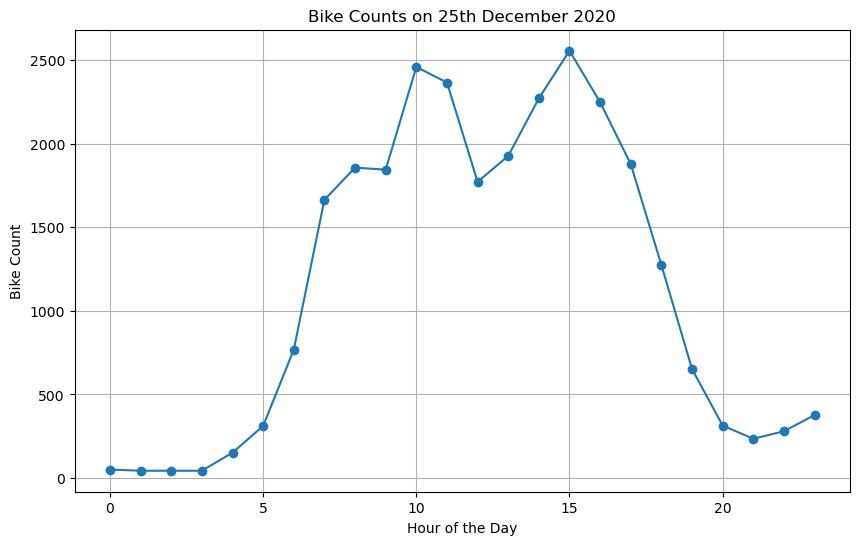

In [66]:
# Filter data for the specific date
specific_date_data = data[data["date"].dt.date == datetime.date(2020, 12, 24)]

# Group by hour and sum the bike counts
hourly_bike_counts = specific_date_data.groupby(specific_date_data["date"].dt.hour)["bike_count"].sum()

# Plot the bike counts for each hour of the specific date
plt.figure(figsize=(10, 6))
plt.plot(hourly_bike_counts.index, hourly_bike_counts.values, marker='o')
plt.title("Bike Counts on 25th December 2020")
plt.xlabel("Hour of the Day")
plt.ylabel("Bike Count")
plt.grid(True)
plt.show()

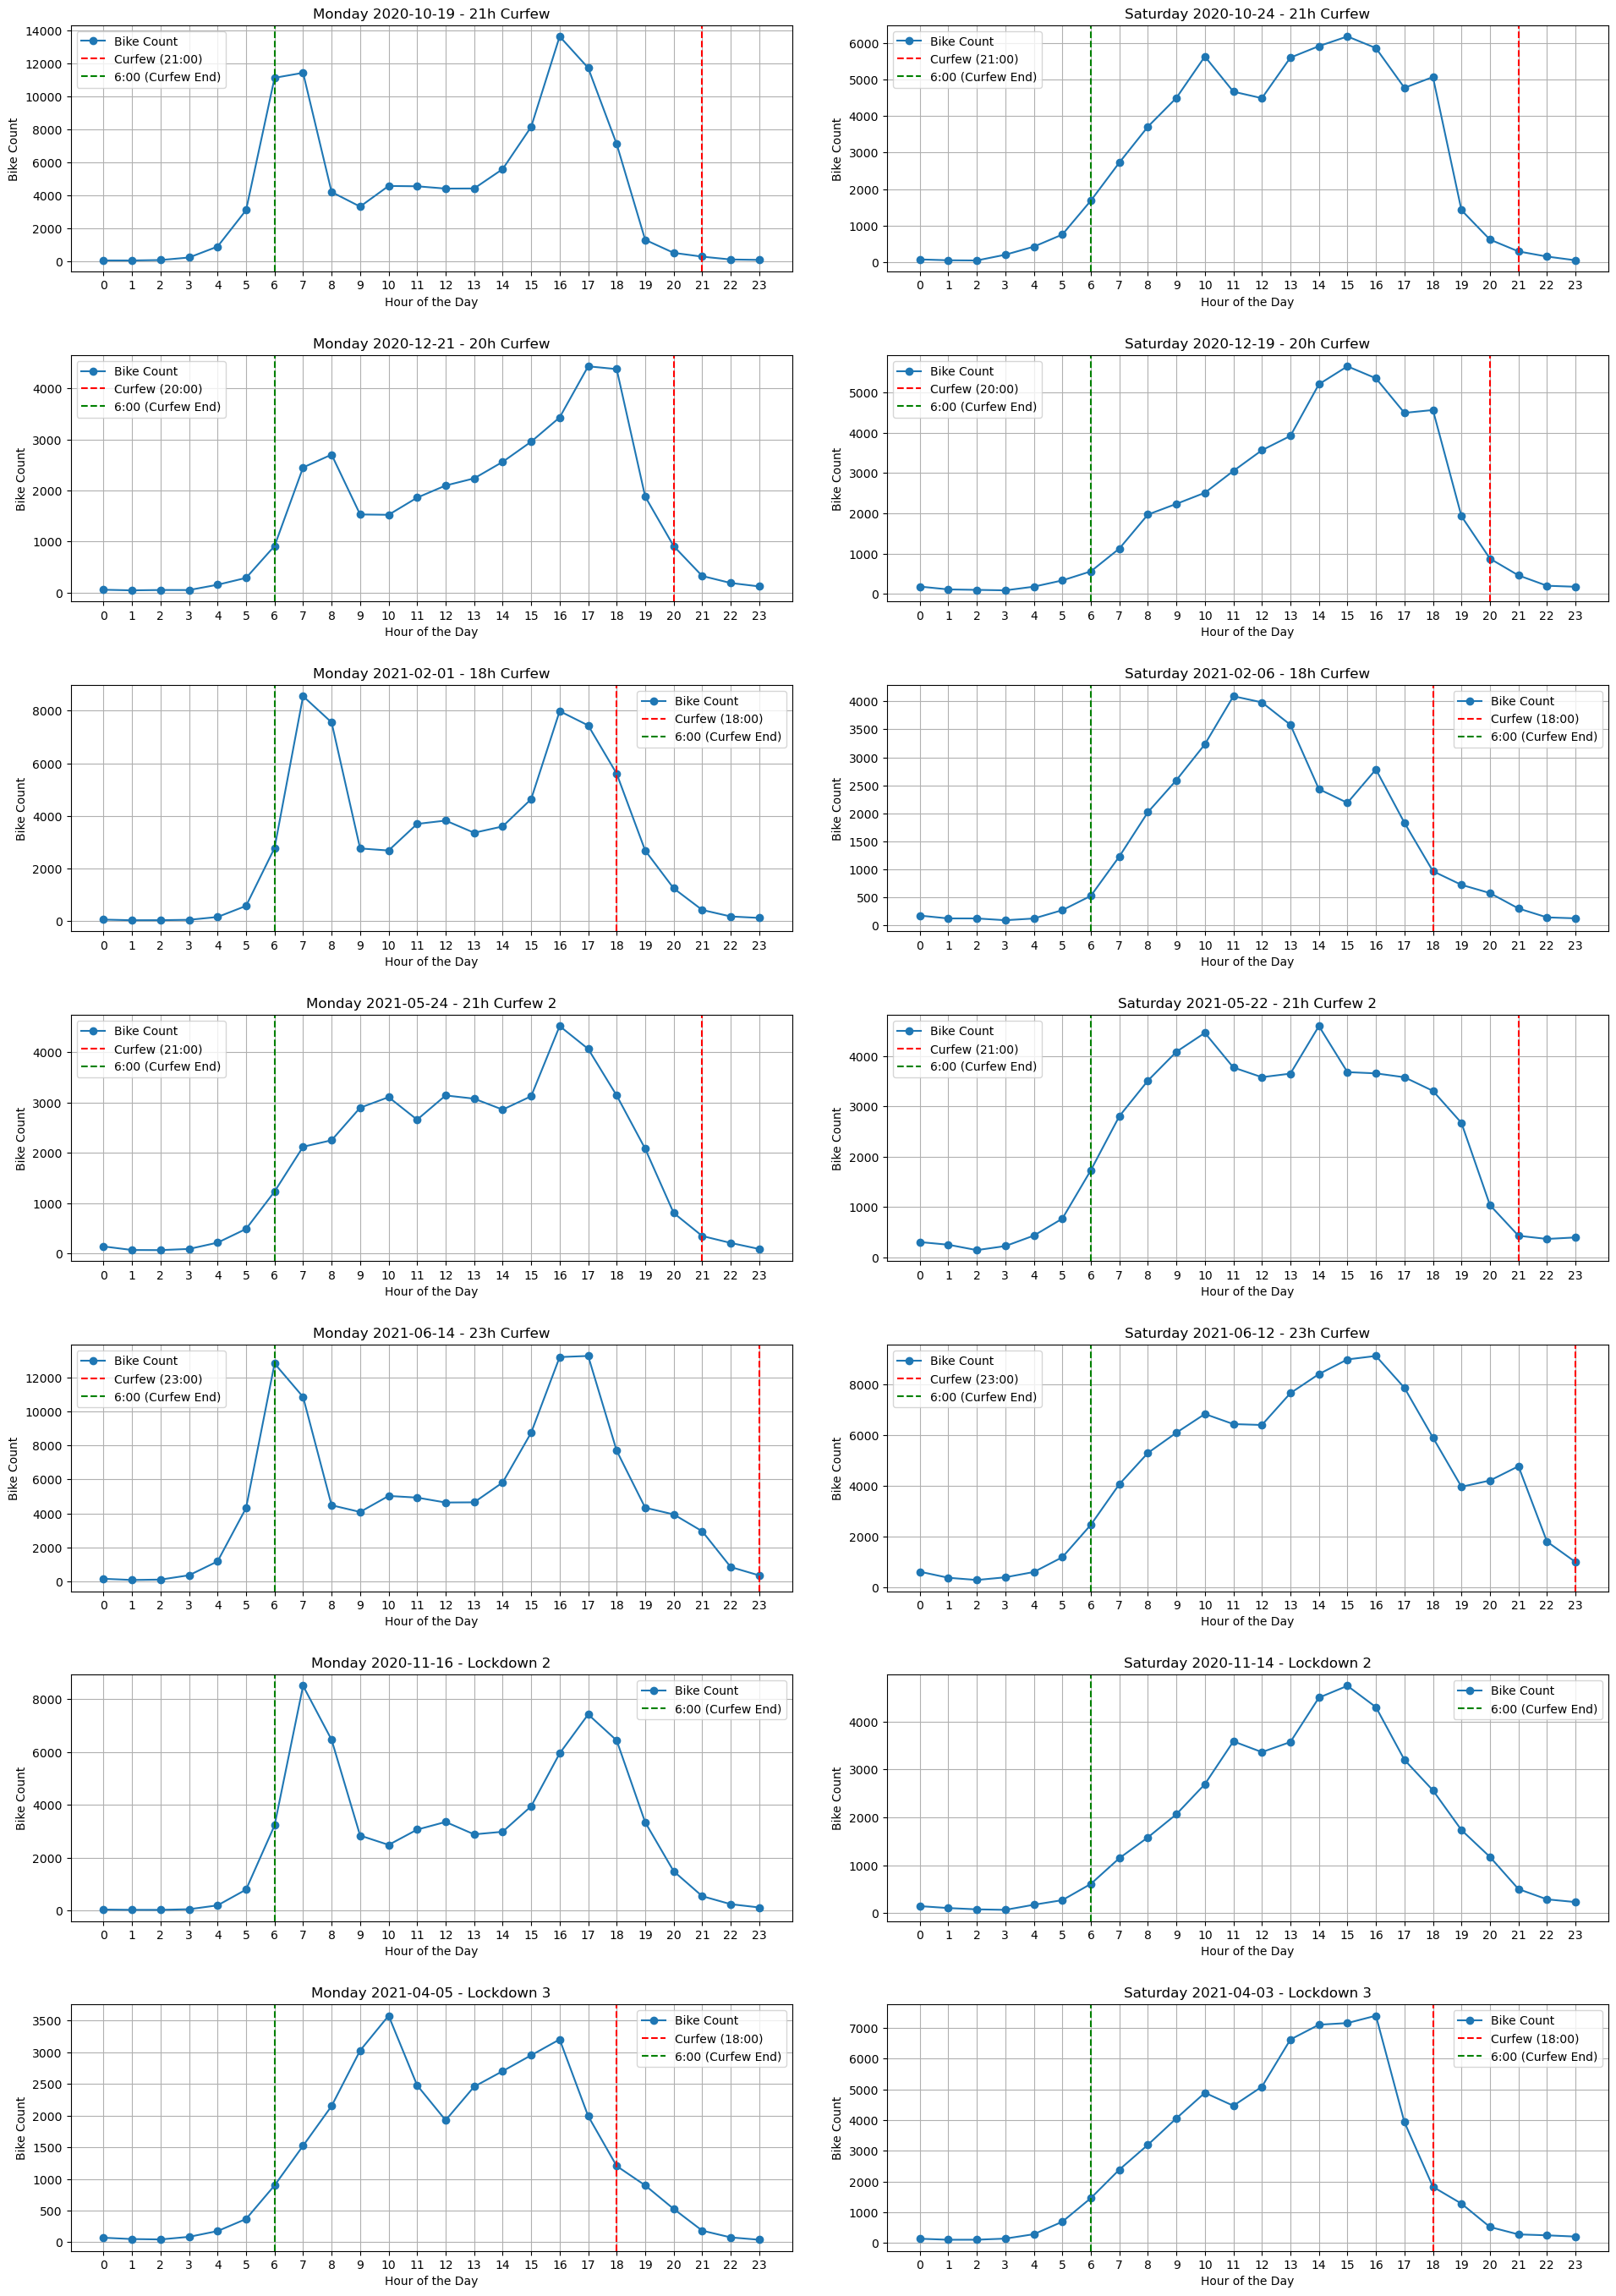

In [67]:
import datetime
import matplotlib.pyplot as plt

test_dates = [
    # Period pairs (Monday, Saturday)
    (datetime.date(2020, 10, 19), datetime.date(2020, 10, 24), "21h Curfew"),     # couvre_feu_21h
    (datetime.date(2020, 12, 21), datetime.date(2020, 12, 19), "20h Curfew"),     # couvre_feu_20h
    (datetime.date(2021, 2, 1), datetime.date(2021, 2, 6), "18h Curfew"),         # couvre_feu_18h
    (datetime.date(2021, 5, 24), datetime.date(2021, 5, 22), "21h Curfew 2"),     # couvre_feu_21h_2
    (datetime.date(2021, 6, 14), datetime.date(2021, 6, 12), "23h Curfew"),       # couvre_feu_23h
    (datetime.date(2020, 11, 16), datetime.date(2020, 11, 14), "Lockdown 2"),     # confinement_2
    (datetime.date(2021, 4, 5), datetime.date(2021, 4, 3), "Lockdown 3")          # confinement_3
]
fig, axs = plt.subplots(7, 2, figsize=(20, 28))
fig.tight_layout(pad=5.0)

for row, (monday_date, saturday_date, period) in enumerate(test_dates):
    # Process Monday data
    monday_data = data[data["date"].dt.date == monday_date]
    if len(monday_data) > 0:
        hourly_counts = monday_data.groupby(monday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 0].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if monday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif monday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif monday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 0].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 0].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 0].set_title(f"Monday {monday_date} - {period}")
    
    # Process Saturday data
    saturday_data = data[data["date"].dt.date == saturday_date]
    if len(saturday_data) > 0:
        hourly_counts = saturday_data.groupby(saturday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 1].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if saturday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif saturday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif saturday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 1].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 1].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 1].set_title(f"Saturday {saturday_date} - {period}")
    
    # Format both plots
    for col in range(2):
        axs[row, col].set_xlabel("Hour of the Day")
        axs[row, col].set_ylabel("Bike Count")
        axs[row, col].grid(True)
        axs[row, col].legend()
        axs[row, col].set_xticks(range(0, 24))

plt.show()

So finally, after all those steps, my dataset is composed of those columns : 

In [68]:
data.describe()

site_id     bike_count                        date  \
count  4.968270e+05  496827.000000                      496827   
mean   1.053450e+08      60.191475  2021-03-08 07:25:59.668858   
min    1.000070e+08       0.000000         2020-09-01 01:00:00   
25%    1.000475e+08       5.000000         2020-12-05 22:00:00   
50%    1.000562e+08      29.000000         2021-03-08 11:00:00   
75%    1.000563e+08      79.000000         2021-06-09 14:00:00   
max    3.000147e+08    1302.000000         2021-09-09 23:00:00   
std    3.210346e+07      87.590566                         NaN   

        counter_installation_date       latitude      longitude  \
count                      496827  496827.000000  496827.000000   
mean   2019-04-04 07:24:35.245911      48.854343       2.345479   
min           2013-01-18 00:00:00      48.826360       2.265420   
25%           2018-11-29 00:00:00      48.840801       2.314440   
50%           2019-11-06 00:00:00      48.852090       2.353870   
75%           2019-12-11 00:00:00      48.864610       2.375870   
max           2020-11-29 00:00:00      48.891720       2.409690   
std                           NaN       0.018554       0.038026   

       log_bike_count           ALTI            RR1      QRR1           DRR1  \
count   496827.000000  496827.000000  496827.000000  496827.0  496827.000000   
mean         3.079917      95.134447       0.082149       1.0       5.085323   
min          0.000000      55.600000       0.000000       1.0       0.000000   
25%          1.791759     101.333333       0.000000       1.0       0.000000   
50%          3.401197     101.333333       0.000000       1.0       0.000000   
75%          4.382027     101.333333       0.000000       1.0       0.000000   
max          7.172425     101.333333      20.325000       1.0      60.000000   
std          1.659899      15.654713       0.469521       0.0      14.396102   

               QDRR1             FF            QFF             DD       QDD  \
count  496827.000000  496827.000000  496827.000000  496827.000000  496827.0   
mean        8.898266       4.054301       1.003274     180.337099       1.0   
min         3.000000       0.000000       1.000000       0.000000       1.0   
25%         9.000000       2.566667       1.000000     113.333333       1.0   
50%         9.000000       3.966667       1.000000     196.666667       1.0   
75%         9.000000       5.350000       1.000000     236.666667       1.0   
max         9.000000      13.600000       3.666667     360.000000       1.0   
std         0.655017       1.915653       0.093382      91.039094       0.0   

                 FXY      QFXY            DXY      QDXY            HXY  \
count  496827.000000  496827.0  496827.000000  496827.0  496827.000000   
mean        4.917374       1.0     185.509725       1.0    1173.070240   
min         0.350000       1.0       6.666667       1.0       0.000000   
25%         3.333333       1.0     123.333333       1.0     577.500000   
50%         4.800000       1.0     203.333333       1.0    1166.000000   
75%         6.300000       1.0     243.333333       1.0    1741.333333   
max        14.900000       1.0     360.000000       1.0    2359.000000   
std         2.073832       0.0      91.474214       0.0     683.683414   

           QHXY            FXI      QFXI            DXI      QDXI  \
count  496827.0  496827.000000  496827.0  496827.000000  496827.0   
mean        9.0       8.101236       1.0     190.631434       1.0   
min         9.0       0.450000       1.0      10.000000       1.0   
25%         9.0       5.333333       1.0     140.000000       1.0   
50%         9.0       7.833333       1.0     206.666667       1.0   
75%         9.0      10.333333       1.0     246.666667       1.0   
max         9.0      29.733333       1.0     360.000000       1.0   
std         0.0       3.674703       0.0      87.294765       0.0   

                 HXI      QHXI          FXI3S         QFXI3S         HFXI3S  \
count  49682

# 2. Visualizing the data - EDA


Let's visualize the data, starting from the spatial distribution of counters on the map

### Map - Location Information

The question : Does the location play a role in the bike count.

In [69]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/folium/utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


In [70]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json
def add_district_information(df):
    """
    Adds district information to the DataFrame with error handling
    """
    # Manual corrections for known locations
    district_mapping = {
        'Voie Georges Pompidou NE-SO': 4,
        'Voie Georges Pompidou SO-NE': 4,
        '152 boulevard du Montparnasse E-O': 14,
        '152 boulevard du Montparnasse O-E': 14,
        'Face au 40 quai D\'Issy NE-SO': 15,
        'Face au 40 quai D\'Issy SO-NE': 15,
        # Add other known mappings here
    }
    
    try:
        # Apply manual mapping first
        df = df.copy()
        df['arrondissement'] = df['counter_name'].map(district_mapping)
        
        # Only process unmapped locations through the API
        unmapped = df[df['arrondissement'].isna()]
        if len(unmapped) > 0:
            # Create GeoDataFrame for unmapped points
            geometry = [Point(xy) for xy in zip(unmapped['longitude'], unmapped['latitude'])]
            gdf_points = gpd.GeoDataFrame(unmapped[['counter_name']], geometry=geometry)
            
            # Get district data from API
            url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/records?limit=20"
            response = pd.read_json(url)
            
            # Create districts GeoDataFrame
            districts_data = [{
                'c_ar': district['c_ar'],
                'geometry': Polygon(district['geom']['geometry']['coordinates'][0])
            } for district in response['results']]
            districts = gpd.GeoDataFrame(districts_data)
            
            # Spatial join
            result = gpd.sjoin(gdf_points, districts[['geometry', 'c_ar']], how="left", predicate='within')
            api_mapping = dict(zip(result['counter_name'], result['c_ar']))
            
            # Update remaining values
            df.loc[df['arrondissement'].isna(), 'arrondissement'] = df.loc[df['arrondissement'].isna(), 'counter_name'].map(api_mapping)
        
        # Fill any remaining NaN values with 0 and convert to int
        df['arrondissement'] = df['arrondissement'].fillna(0).astype(int)
        return df
        
    except Exception as e:
        print(f"Warning: Error in district assignment: {e}")
        df['arrondissement'] = 0
        return df

# Utilisation
data = add_district_information(data)

# Vérification
print(data[['counter_name', 'arrondissement']].drop_duplicates())

                                           counter_name  arrondissement
0                              28 boulevard Diderot E-O              12
8838                           28 boulevard Diderot O-E              12
17839                    39 quai François Mauriac NO-SE              13
26819                    39 quai François Mauriac SE-NO              13
35812                 18 quai de l'Hôtel de Ville NO-SE               4
44691                 18 quai de l'Hôtel de Ville SE-NO               4
53844                       Voie Georges Pompidou NE-SO               4
62204                       Voie Georges Pompidou SO-NE               4
70700                       67 boulevard Voltaire SE-NO              11
79856                 Face au 48 quai de la marne NE-SO              19
88358                 Face au 48 quai de la marne SO-NE              19
97804                  Face 104 rue d'Aubervilliers N-S              19
106295                 Face 104 rue d'Aubervilliers S-N         

In [71]:
# Arrondissement devrait être une variable catégorielle

data['arrondissement'] = data['arrondissement'].astype('category')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/3058269372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bike_count_per_arrondissement = data.groupby('arrondissement')['bike_count'].mean()


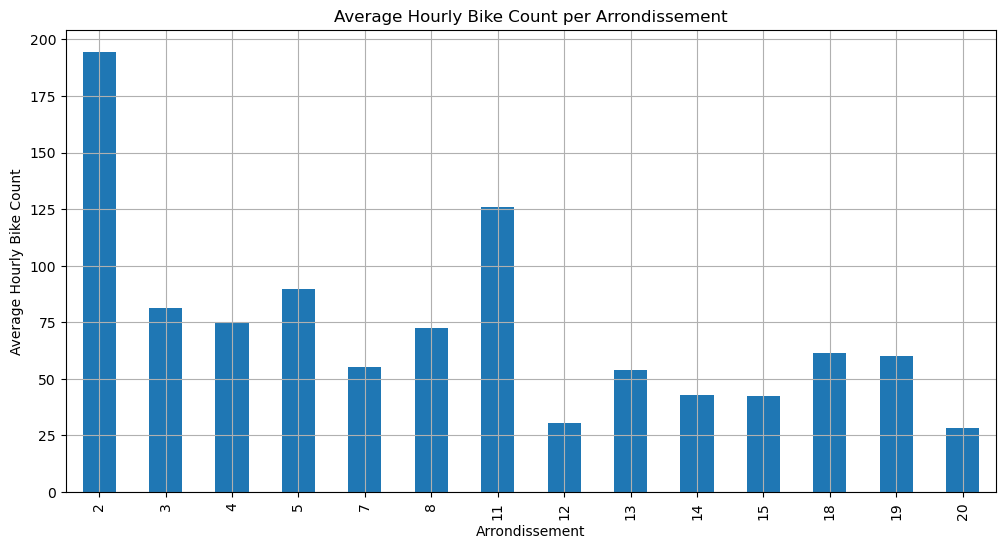

In [72]:
# Calculate the average hourly bike count per arrondissement
avg_bike_count_per_arrondissement = data.groupby('arrondissement')['bike_count'].mean()

# Plot the bar plot
plt.figure(figsize=(12, 6))
avg_bike_count_per_arrondissement.plot(kind='bar')
plt.title('Average Hourly Bike Count per Arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Average Hourly Bike Count')
plt.grid(True)
plt.show()

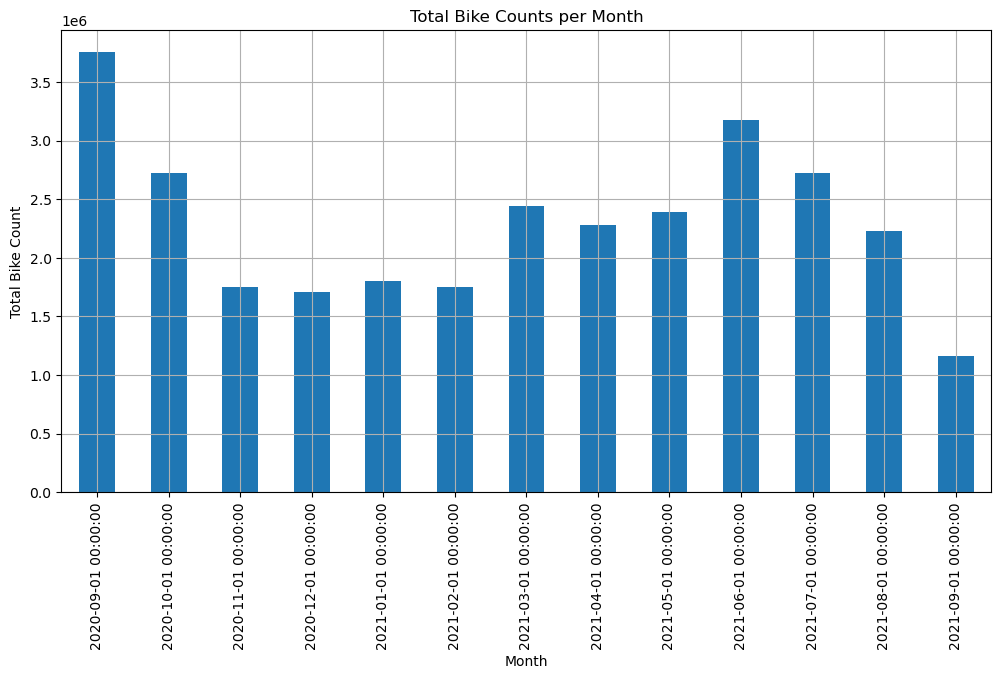

In [73]:
# Group the data by month and sum the bike counts
monthly_bike_counts = data.groupby(data['date'].dt.to_period('M'))['bike_count'].sum()

# Convert the PeriodIndex to a datetime index for plotting
monthly_bike_counts.index = monthly_bike_counts.index.to_timestamp()

# Plot the monthly bike counts
plt.figure(figsize=(12, 6))
monthly_bike_counts.plot(kind='bar')
plt.title('Total Bike Counts per Month')
plt.xlabel('Month')
plt.ylabel('Total Bike Count')
plt.grid(True)
plt.show()

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


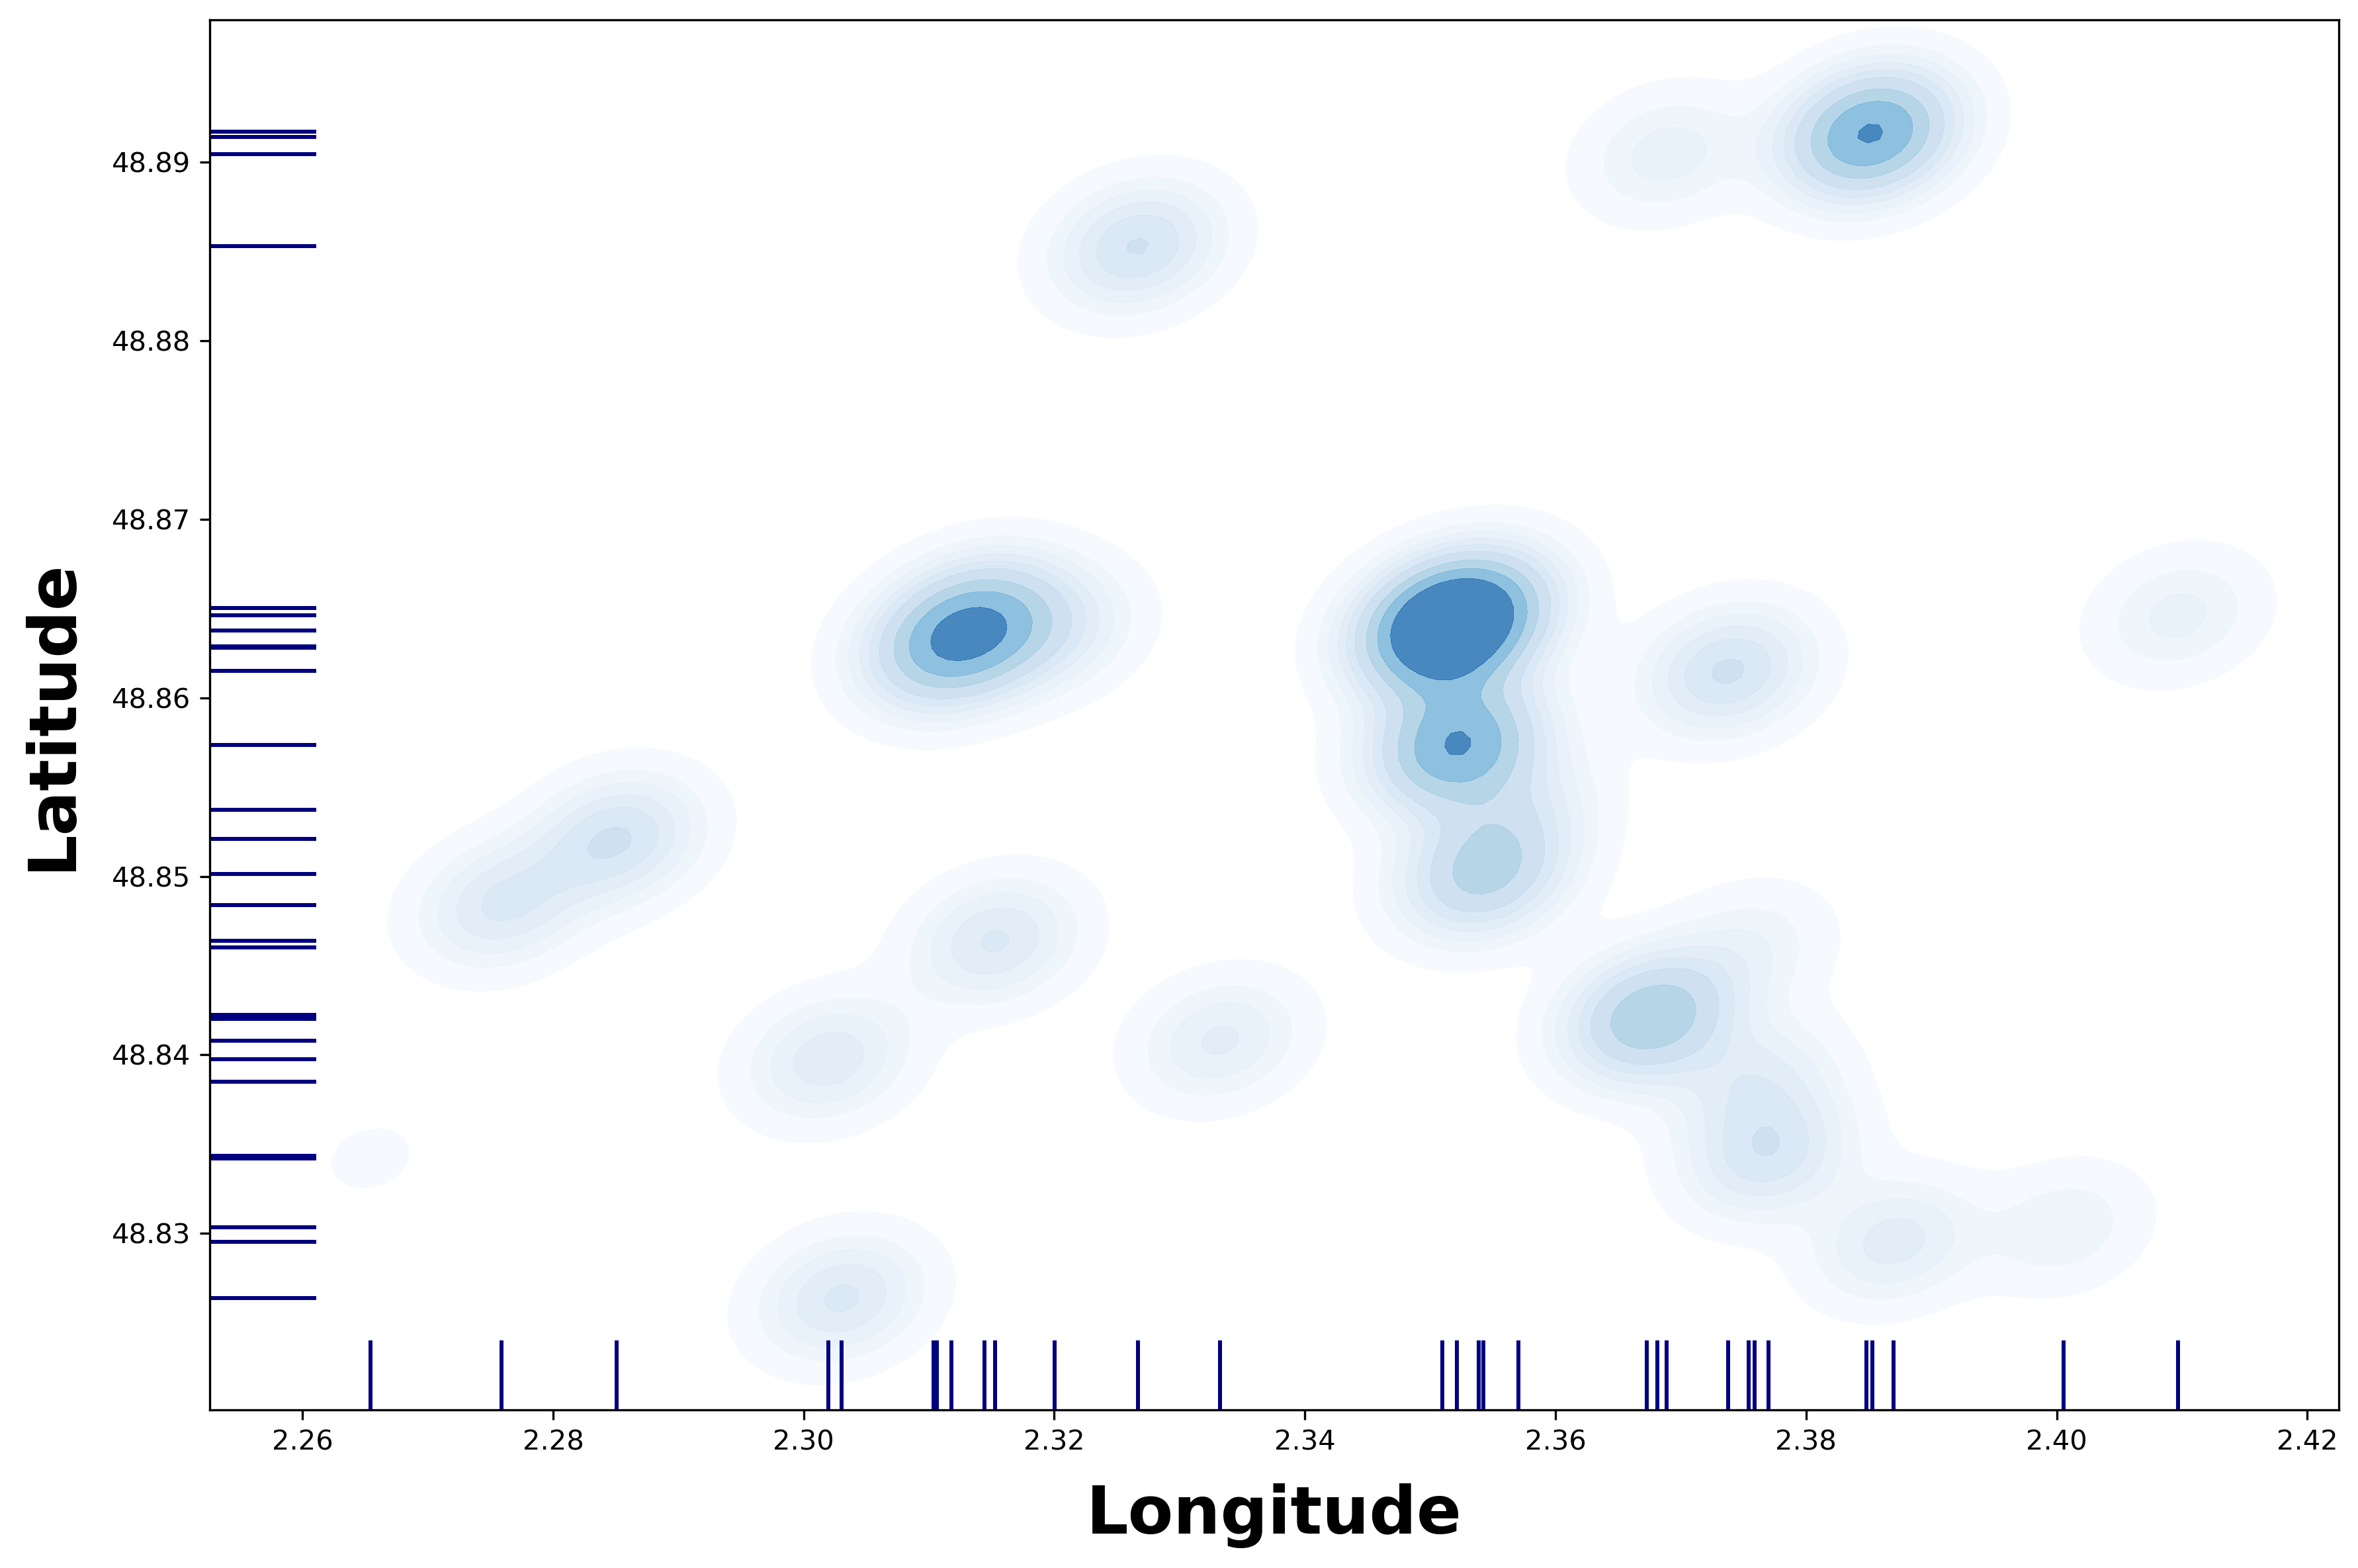

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot with adjusted figure size and DPI for better quality
plt.figure(figsize=(12, 8), dpi=300)

# Create a kernel density plot with adjusted parameters
sns.kdeplot(
    data=data,
    x='longitude',
    y='latitude',
    weights='bike_count',
    cmap='Blues',      # Keep the blue color scheme
    fill=True,
    alpha=0.8,         # Increased alpha for better visibility
    levels=10,         # Reduced number of levels for more distinct contours
    linewidths=1,      # Added contour lines
    thresh=0.05        # Reduce threshold to show more of the density
)

# Customize axes with larger font sizes and bold
plt.xlabel('Longitude', fontsize=24, fontweight='bold', labelpad=10)
plt.ylabel('Latitude', fontsize=24, fontweight='bold', labelpad=10)

# Add rugs with increased visibility
sns.rugplot(data=data, x='longitude', alpha=0.5, color='navy', height=0.05)
sns.rugplot(data=data, y='latitude', alpha=0.5, color='navy', height=0.05)

# Adjust layout
plt.tight_layout()

plt.show()

## Weather

### Rain

count    496827.000000
mean          0.082149
std           0.469521
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.325000
Name: RR1, dtype: float64


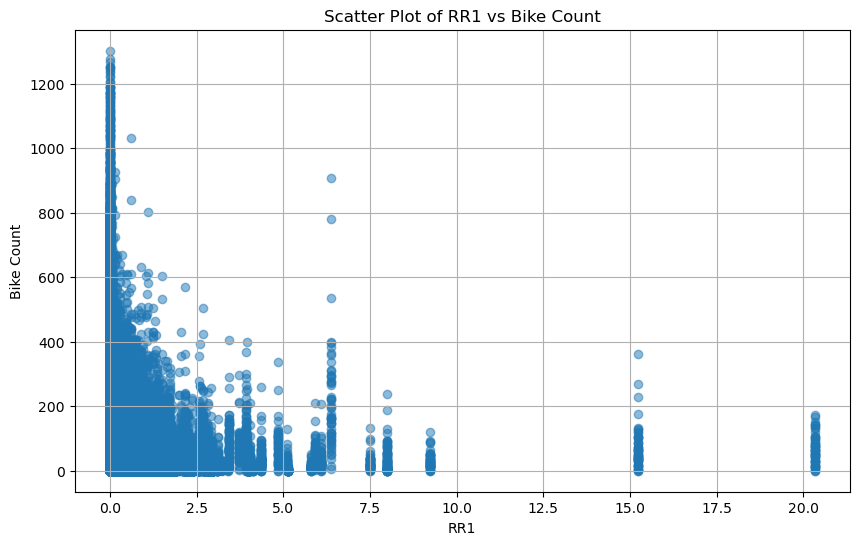

In [75]:
# Display summary statistics for the RR1 column
print(data['RR1'].describe())

# Scatter plot of RR1 vs bike_count
plt.figure(figsize=(10, 6))
plt.scatter(data['RR1'], data['bike_count'], alpha=0.5)
plt.title('Scatter Plot of RR1 vs Bike Count')
plt.xlabel('RR1')
plt.ylabel('Bike Count')
plt.grid(True)
plt.show()


Rainfall Summary Statistics:
count    496827.000
mean          0.082
std           0.470
min           0.000
25%           0.000
50%           0.000
75%           0.000
max          20.325
Name: RR1, dtype: float64

Rain Frequency: 14.0% of days have rain


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2259235624.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


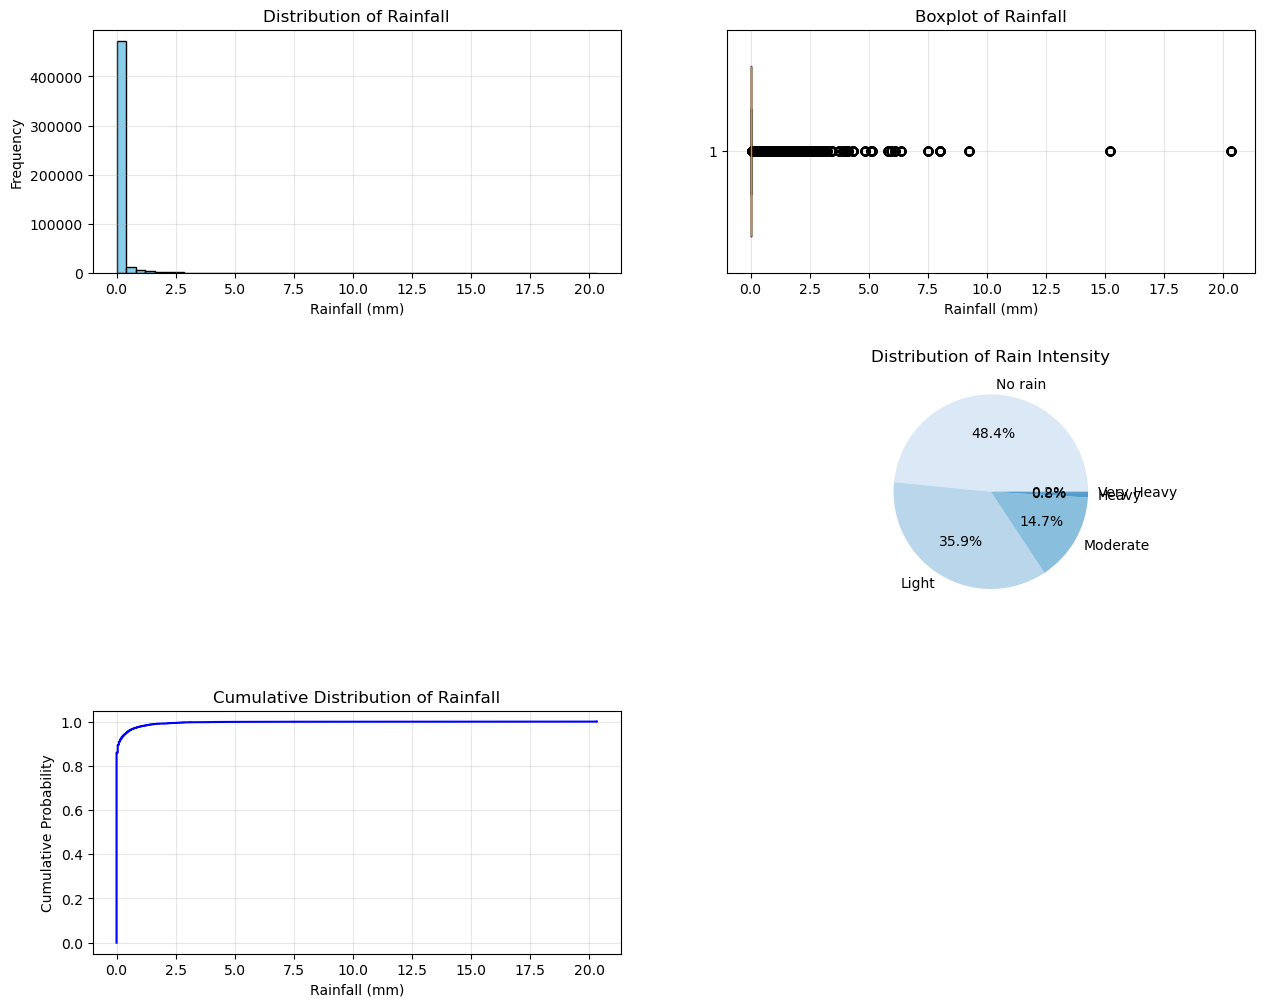

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4)

# 1. Basic histogram of rainfall
ax1 = fig.add_subplot(gs[0, 0])
plt.hist(data['RR1'], bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Rainfall')
ax1.set_xlabel('Rainfall (mm)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2 = fig.add_subplot(gs[0, 1])
plt.boxplot(data['RR1'], vert=False, widths=0.7)
ax2.set_title('Boxplot of Rainfall')
ax2.set_xlabel('Rainfall (mm)')
ax2.grid(True, alpha=0.3)


# 4. Rain intensity categories
# Define new bins and labels
bins = [0, 0.2, 1, 5, 10, float('inf')]
labels = ['No rain', 'Light', 'Moderate', 'Heavy', 'Very Heavy']

# Create rain categories
data['rain_category'] = pd.cut(data['RR1'], bins=bins, labels=labels)

rain_counts = data['rain_category'].value_counts()

ax4 = fig.add_subplot(gs[1, 1])
plt.pie(rain_counts, labels=rain_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Blues"))
ax4.set_title('Distribution of Rain Intensity')

# 5. Cumulative distribution
ax5 = fig.add_subplot(gs[2, 0])
sorted_rain = np.sort(data['RR1'])
cumulative = np.arange(1, len(sorted_rain) + 1) / len(sorted_rain)
plt.plot(sorted_rain, cumulative, 'b-')
ax5.set_title('Cumulative Distribution of Rainfall')
ax5.set_xlabel('Rainfall (mm)')
ax5.set_ylabel('Cumulative Probability')
ax5.grid(True, alpha=0.3)

# Print summary statistics
print("\nRainfall Summary Statistics:")
print(data['RR1'].describe().round(3))

# Calculate rain frequency
rain_days = (data['RR1'] > 0).sum()
total_days = len(data)
rain_frequency = (rain_days / total_days * 100).round(1)
print(f"\nRain Frequency: {rain_frequency}% of days have rain")

plt.tight_layout()
plt.show()

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/723011458.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_averages = data.groupby(['hour', 'rain_category'])['bike_count'].mean().unstack()


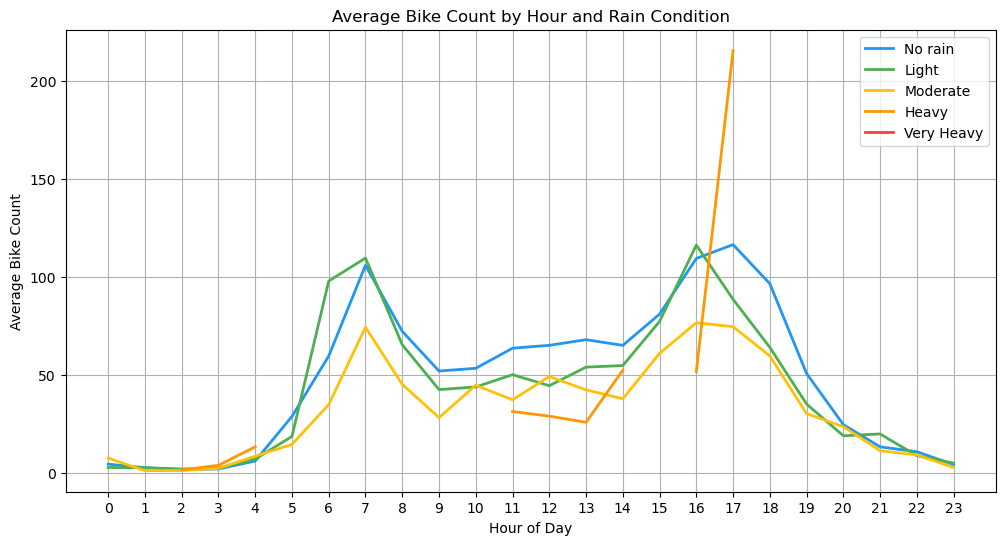

rain_category
No rain       33753
Light         25004
Moderate      10280
Heavy           556
Very Heavy      112
Name: count, dtype: int64


In [77]:


# Calculate average bike count for each hour and rain category
hourly_averages = data.groupby(['hour', 'rain_category'])['bike_count'].mean().unstack()

# Create the plot
plt.figure(figsize=(12, 6))
colors = {'No rain': '#2196F3', 'Light': '#4CAF50', 'Moderate': '#FFC107', 'Heavy': '#FF9800', 'Very Heavy': '#F44336'}

for category in hourly_averages.columns:
    plt.plot(hourly_averages.index, 
             hourly_averages[category], 
             label=f'{category}',
             color=colors[category],
             linewidth=2)

plt.title('Average Bike Count by Hour and Rain Condition')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.legend()
plt.xticks(range(24))
plt.show()

# Calculate and print rain counts
rain_counts = data['rain_category'].value_counts()
print(rain_counts)


Summary Statistics for each Rain Category:
                 count       mean        std  min   25%   50%   75%     max
rain_category                                                              
No rain        33753.0  51.867715  73.802824  0.0   4.0  26.0  69.0   926.0
Light          25004.0  41.910254  64.591622  0.0   3.0  18.0  53.0  1030.0
Moderate       10280.0  35.953696  54.747144  0.0   3.0  16.0  46.0   801.0
Heavy            556.0  44.838129  82.026819  0.0   6.0  20.0  46.0   906.0
Very Heavy       112.0  67.946429  56.506531  0.0  31.0  57.0  93.0   362.0


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1396192483.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('rain_category')['bike_count'].describe())


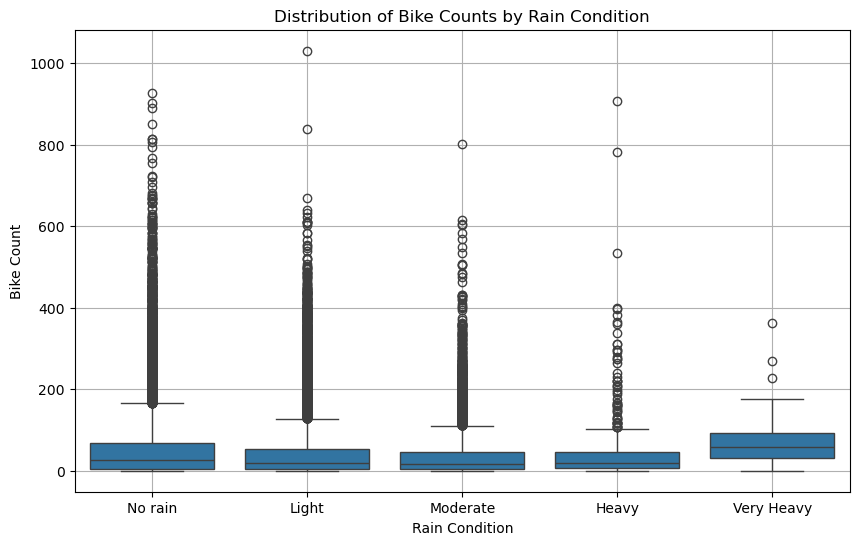

In [78]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_category', y='bike_count', data=data)

plt.title('Distribution of Bike Counts by Rain Condition')
plt.xlabel('Rain Condition')
plt.ylabel('Bike Count')
plt.grid(True)

# Print summary statistics
print("\nSummary Statistics for each Rain Category:")
print(data.groupby('rain_category')['bike_count'].describe())

### Visibility

count    496827.000000
mean      17853.896306
std        4148.617019
min         426.000000
25%       18181.000000
50%       20000.000000
75%       20000.000000
max       20000.000000
Name: VV, dtype: float64


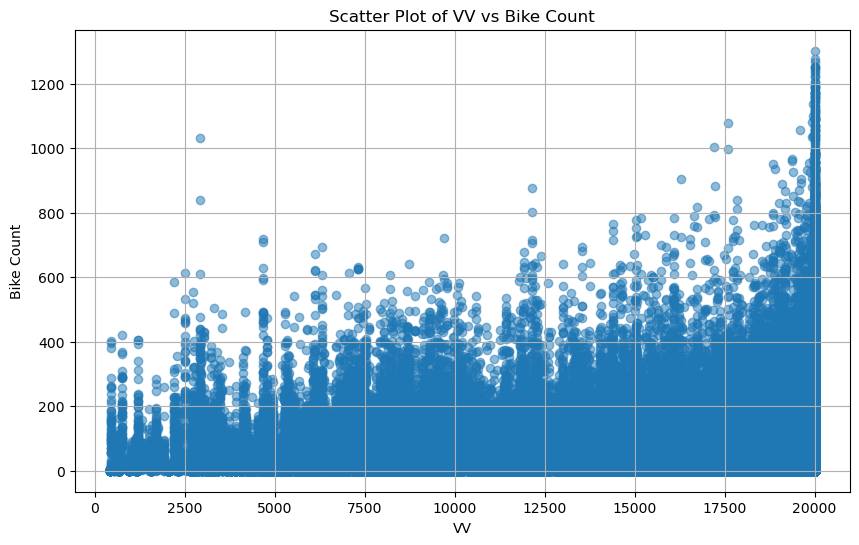

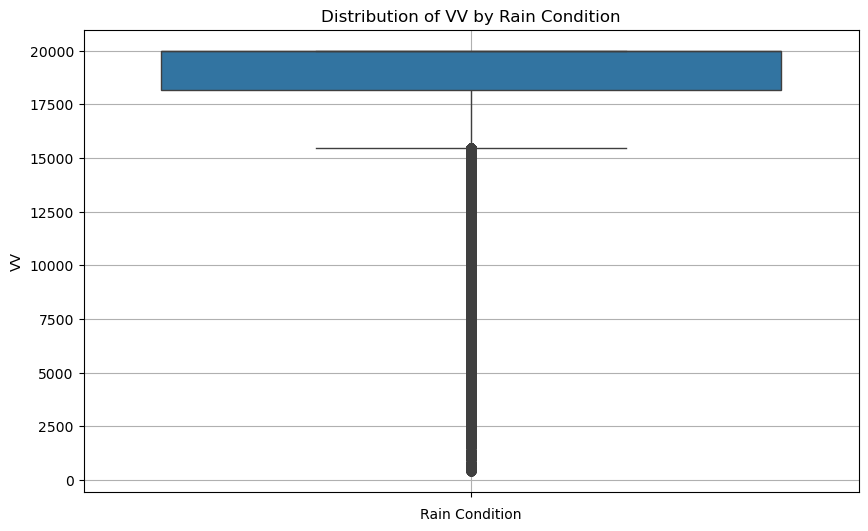

In [79]:
# Display summary statistics for the RR1 column
print(data['VV'].describe())

# Scatter plot of RR1 vs bike_count
plt.figure(figsize=(10, 6))
plt.scatter(data['VV'], data['bike_count'], alpha=0.5)
plt.title('Scatter Plot of VV vs Bike Count')
plt.xlabel('VV')
plt.ylabel('Bike Count')
plt.grid(True)
plt.show()

# Boxplot of VV 

plt.figure(figsize=(10, 6))
sns.boxplot(y='VV', data=data)
plt.title('Distribution of VV by Rain Condition')
plt.xlabel('Rain Condition')
plt.ylabel('VV')
plt.grid(True)
plt.show()


### Temperature

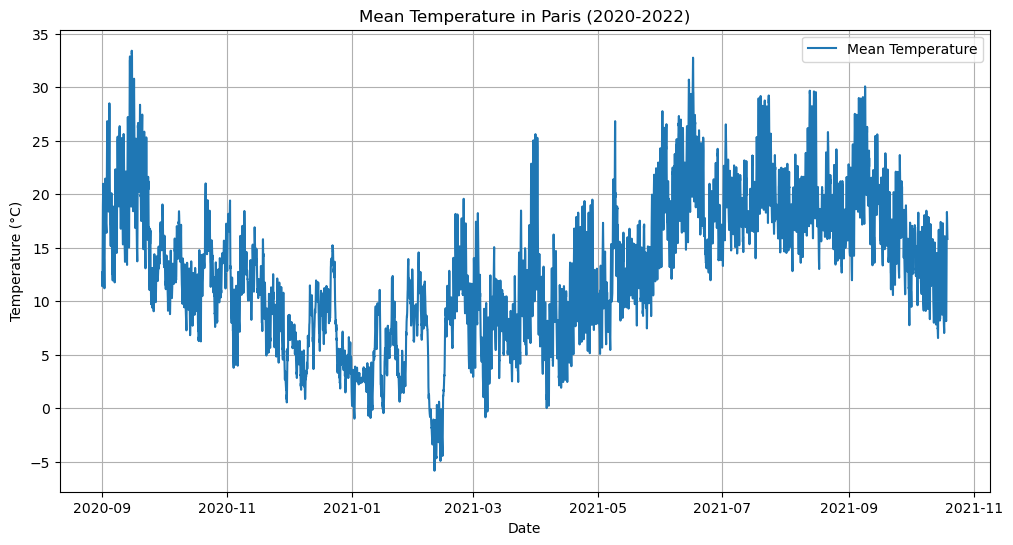

In [80]:
# Mean temperature in paris in 2020-2022

plt.figure(figsize=(12, 6))
plt.plot(weather_reduced.index, weather_reduced["T"], label='Mean Temperature')
plt.title('Mean Temperature in Paris (2020-2022)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()

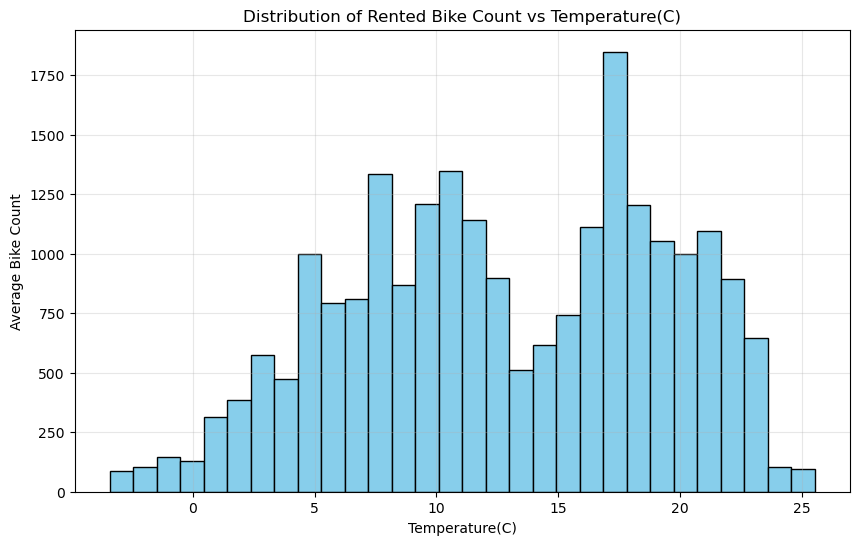


Daily Temperature and Bike Count Summary:
            TNSOL  bike_count
count  374.000000  374.000000
mean    11.446471   60.268680
std      6.491549   22.547944
min     -3.406250    6.295387
25%      6.639583   47.785528
50%     10.908333   56.832217
75%     17.179688   72.436405
max     25.535417  124.510802


In [81]:
# Calculate daily averages
daily_avg = data.groupby(pd.to_datetime(data['date']).dt.date).agg({
    'TNSOL': 'mean',
    'bike_count': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))

# Create histogram of average bike counts grouped by temperature ranges
plt.hist(daily_avg['TNSOL'], bins=30, weights=daily_avg['bike_count'], 
         color='skyblue', edgecolor='black')

plt.title('Distribution of Rented Bike Count vs Temperature(C)')
plt.xlabel('Temperature(C)')
plt.ylabel('Average Bike Count')
plt.grid(True, alpha=0.3)

plt.show()

# Print summary statistics
print("\nDaily Temperature and Bike Count Summary:")
print(daily_avg.describe())

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/matplotlib/transforms.py:2048: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1423079826.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in data.groupby('temp_category'):



Temperature Summary Statistics:
count    496827.00
mean         11.45
std           8.03
min          -8.05
25%           5.70
50%          10.90
75%          16.30
max          39.25
Name: TNSOL, dtype: float64

Temperature Category Statistics:
Cold (< 5°C):
  Hours: 112564 (22.7%)
  Average Temperature: 1.4°C
Cool (5 to 15°C):
  Hours: 232671 (46.8%)
  Average Temperature: 10.2°C
Moderate (15 to 22°C):
  Hours: 100182 (20.2%)
  Average Temperature: 17.8°C
Warm (22 to 28°C):
  Hours: 33816 (6.8%)
  Average Temperature: 24.6°C
Hot (> 28°C):
  Hours: 17594 (3.5%)
  Average Temperature: 31.5°C


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1423079826.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/matplotlib/transforms.py:2048: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


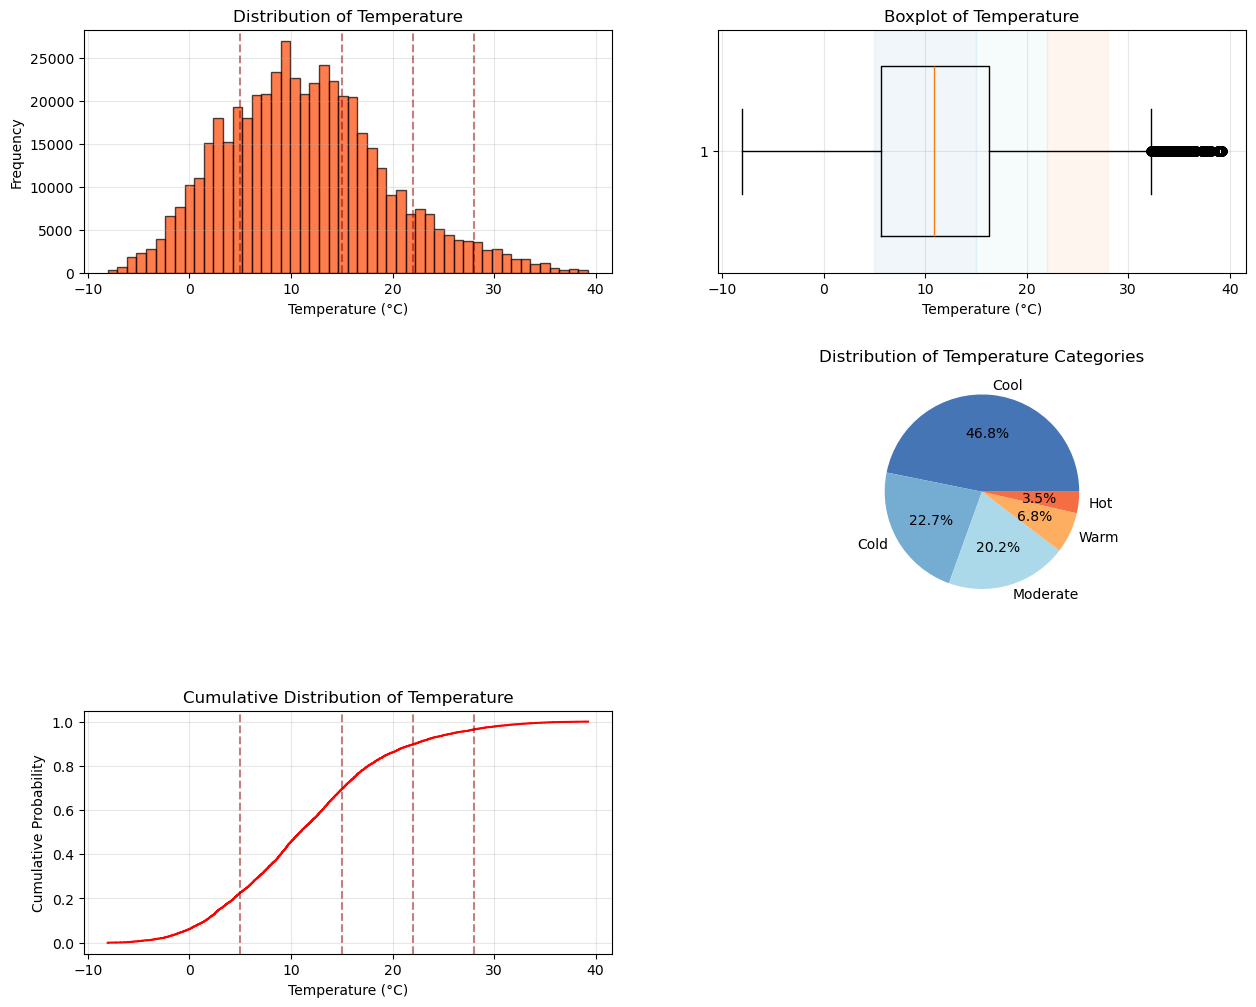

In [82]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4)

# 1. Basic histogram of temperature
ax1 = fig.add_subplot(gs[0, 0])
plt.hist(data['TNSOL'], bins=50, color='orangered', edgecolor='black', alpha=0.7)
# Add vertical lines for category boundaries
for boundary in [5, 15, 22, 28]:
    plt.axvline(x=boundary, color='darkred', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Temperature')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2 = fig.add_subplot(gs[0, 1])
plt.boxplot(data['TNSOL'], vert=False, widths=0.7)
# Add background colors for temperature ranges
ax2.axvspan(-float('inf'), 5, alpha=0.1, color='#4575b4')
ax2.axvspan(5, 15, alpha=0.1, color='#74add1')
ax2.axvspan(15, 22, alpha=0.1, color='#abd9e9')
ax2.axvspan(22, 28, alpha=0.1, color='#fdae61')
ax2.axvspan(28, float('inf'), alpha=0.1, color='#f46d43')
ax2.set_title('Boxplot of Temperature')
ax2.set_xlabel('Temperature (°C)')
ax2.grid(True, alpha=0.3)


# 4. Temperature categories pie chart
bins = [-float('inf'), 5, 15, 22, 28, float('inf')]
labels = ['Cold', 'Cool', 'Moderate', 'Warm', 'Hot']
data['temp_category'] = pd.cut(data['TNSOL'], bins=bins, labels=labels)
temp_counts = data['temp_category'].value_counts()

ax4 = fig.add_subplot(gs[1, 1])
colors = ['#4575b4', '#74add1', '#abd9e9', '#fdae61', '#f46d43']
plt.pie(temp_counts, labels=temp_counts.index, autopct='%.1f%%',
        colors=colors)
ax4.set_title('Distribution of Temperature Categories')

# 5. Cumulative distribution
ax5 = fig.add_subplot(gs[2, 0])
sorted_temp = np.sort(data['TNSOL'])
cumulative = np.arange(1, len(sorted_temp) + 1) / len(sorted_temp)
plt.plot(sorted_temp, cumulative, 'r-')
# Add vertical lines for category boundaries
for boundary in [5, 15, 22, 28]:
    plt.axvline(x=boundary, color='darkred', linestyle='--', alpha=0.5)
ax5.set_title('Cumulative Distribution of Temperature')
ax5.set_xlabel('Temperature (°C)')
ax5.set_ylabel('Cumulative Probability')
ax5.grid(True, alpha=0.3)

# Print summary statistics
print("\nTemperature Summary Statistics:")
print(data['TNSOL'].describe().round(2))

# Calculate and print detailed temperature statistics
print("\nTemperature Category Statistics:")
total_hours = len(data)
for category, group in data.groupby('temp_category'):
    hours = len(group)
    percentage = round((hours / total_hours * 100), 1)
    avg_temp = round(group['TNSOL'].mean(), 1)
    idx = labels.index(category)
    lower_bound = bins[idx]
    upper_bound = bins[idx + 1]
    
    # Format the bounds nicely
    if lower_bound == float('-inf'):
        bound_text = f"< {upper_bound}"
    elif upper_bound == float('inf'):
        bound_text = f"> {lower_bound}"
    else:
        bound_text = f"{lower_bound} to {upper_bound}"
    
    print(f"{category} ({bound_text}°C):")
    print(f"  Hours: {hours} ({percentage}%)")
    print(f"  Average Temperature: {avg_temp}°C")

plt.tight_layout()
plt.show()

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1096718310.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_averages = data.groupby(['hour', 'temp_category'])['bike_count'].mean().unstack()


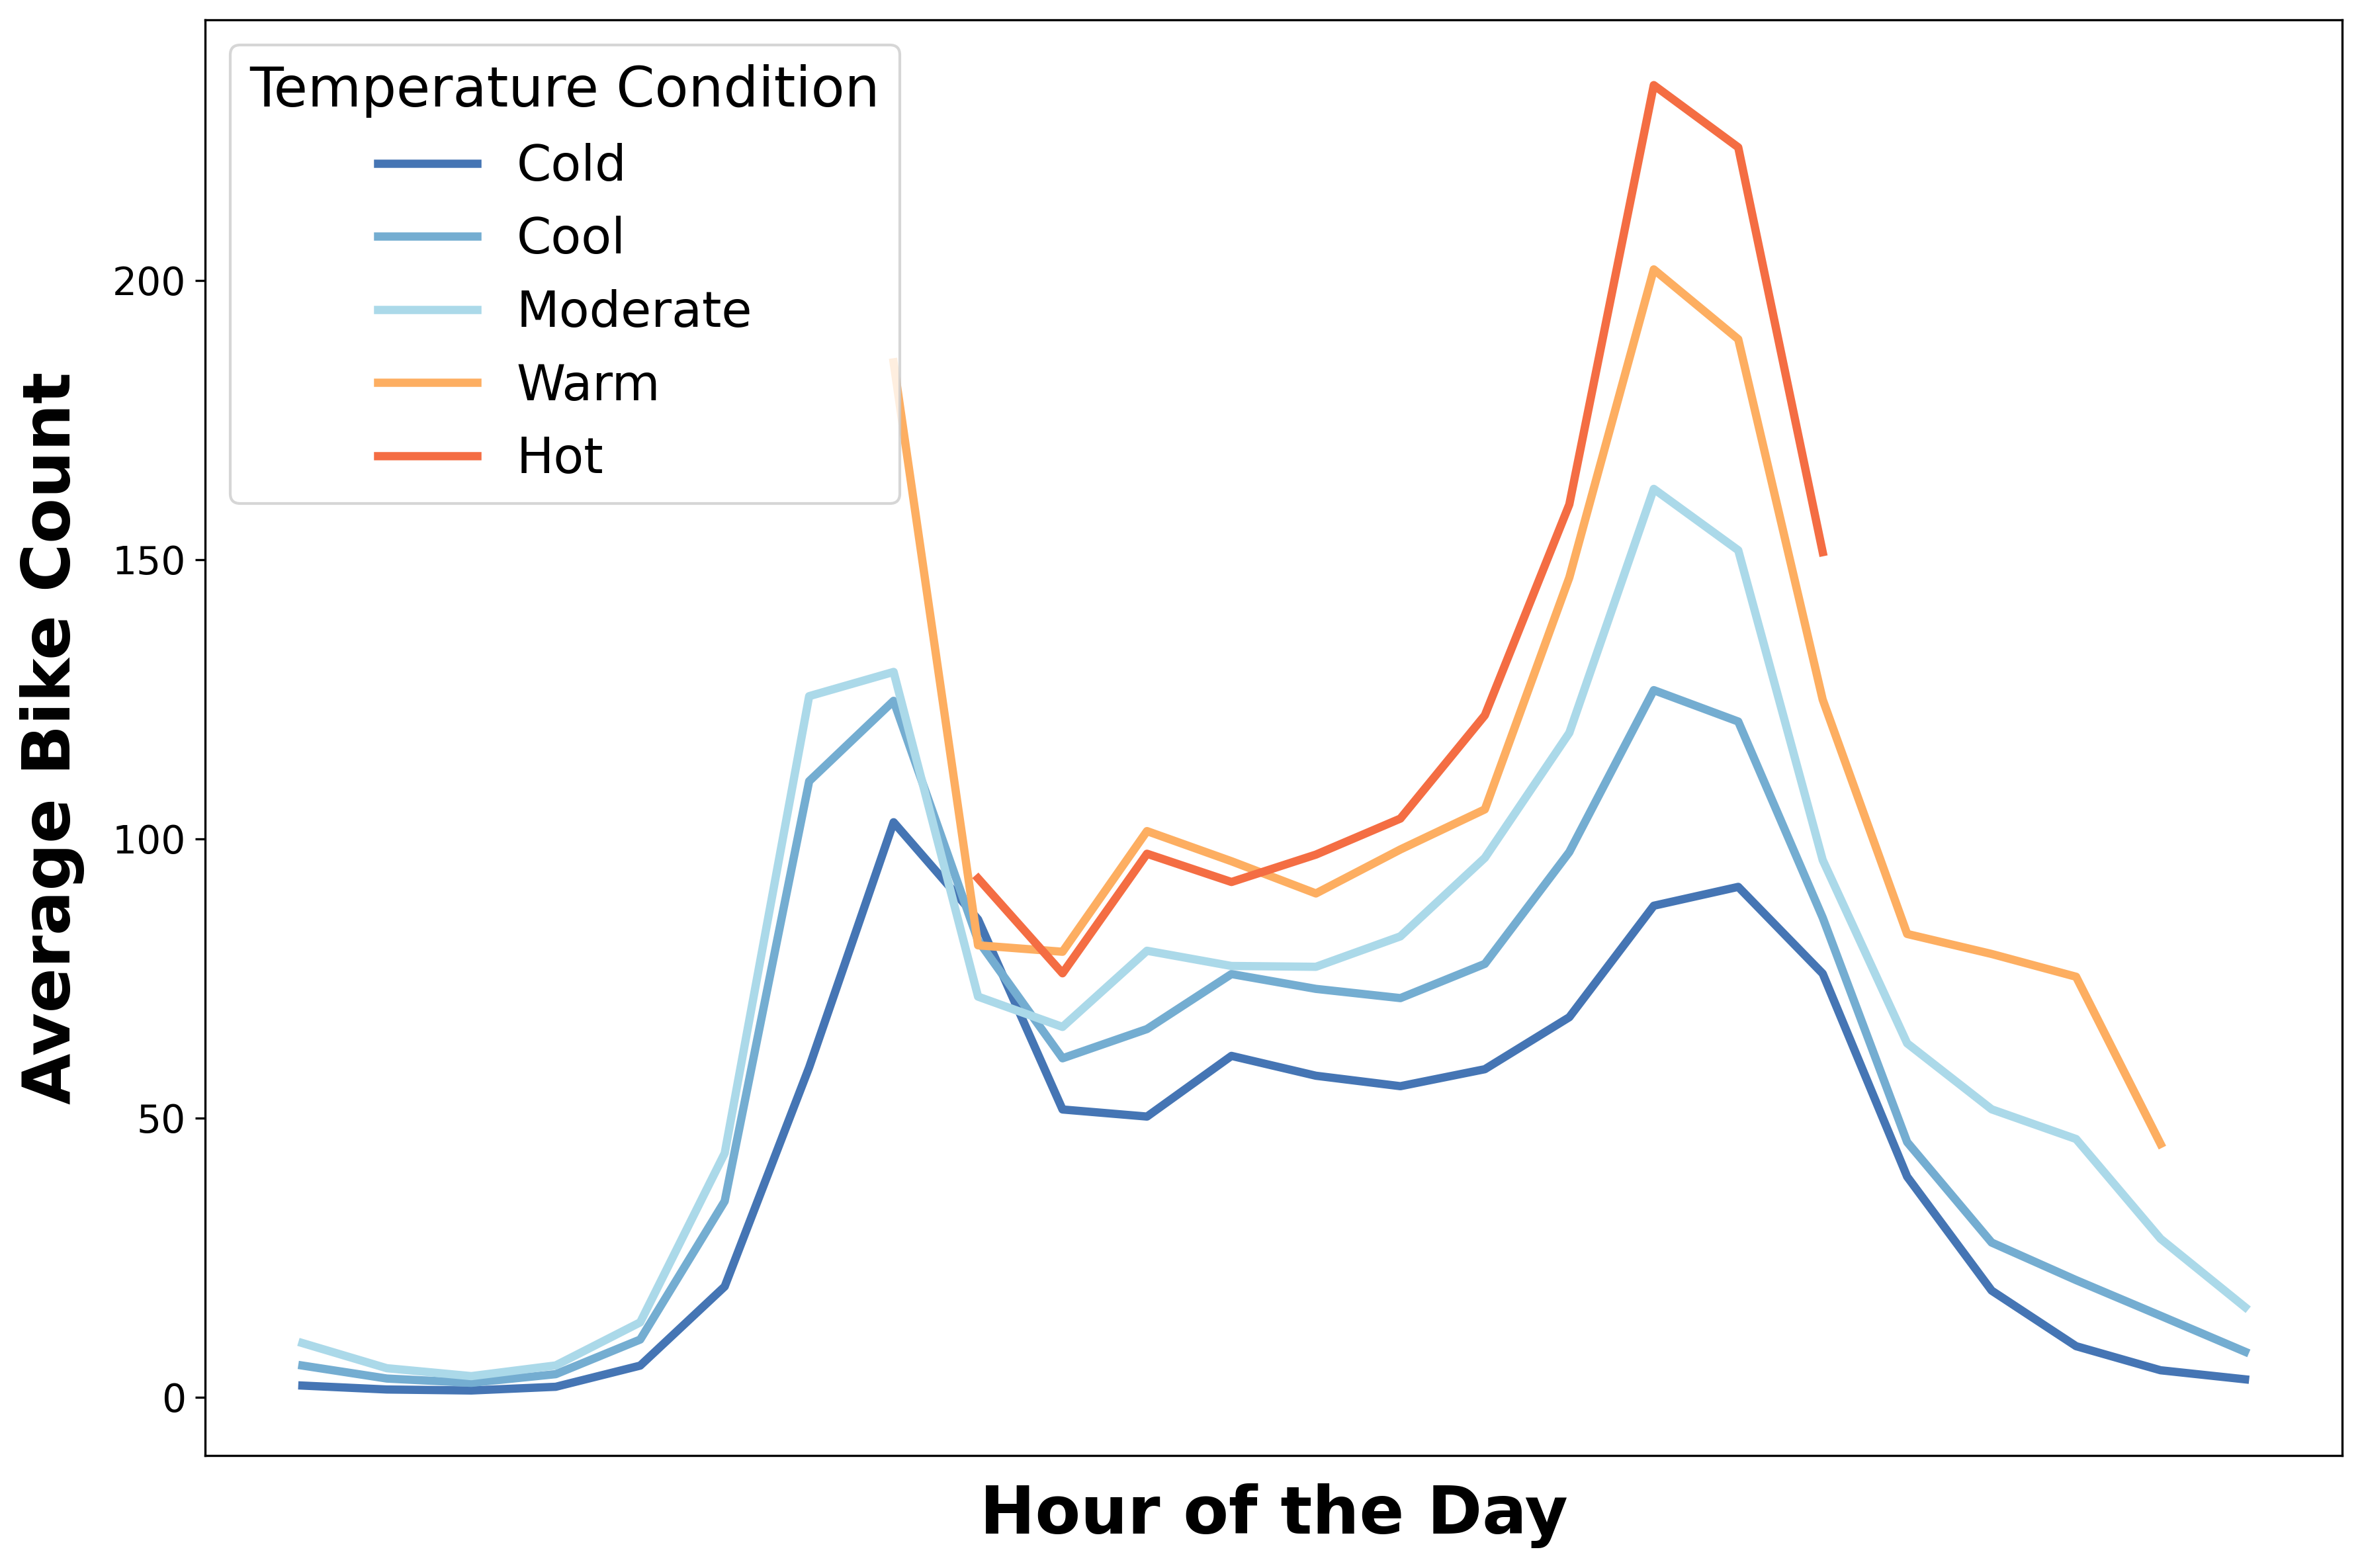

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create temperature categories with optimized bins
bins = [-float('inf'), 5, 15, 22, 28, float('inf')]
labels = ['Cold', 'Cool', 'Moderate', 'Warm', 'Hot']
data['temp_category'] = pd.cut(data['TNSOL'], bins=bins, labels=labels)

# Create figure
plt.figure(figsize=(12, 8), dpi=300)

# Calculate hourly averages
hourly_averages = data.groupby(['hour', 'temp_category'])['bike_count'].mean().unstack()

# Color scheme
colors = {
   'Cold': '#4575b4',
   'Cool': '#74add1',
   'Moderate': '#abd9e9',
   'Warm': '#fdae61',
   'Hot': '#f46d43'
}

# Plot lines with increased thickness
for category in hourly_averages.columns:
   plt.plot(hourly_averages.index, 
            hourly_averages[category], 
            label=f'{category}',
            color=colors[category],
            linewidth=3)

# Customize axes with larger font sizes and bold
plt.xlabel('Hour of the Day', fontsize=24, labelpad=10, fontweight='bold')
plt.ylabel('Average Bike Count', fontsize=24, labelpad=10, fontweight='bold')

# Customize legend - placed on top left with larger font
plt.legend(title='Temperature Condition', title_fontsize=20, fontsize=18, 
         loc='upper left')

# Customize ticks with larger font size - remove x-axis numbers
plt.xticks([])  # This removes the x-axis numbers
plt.yticks(fontsize=14)

# Add padding to prevent label cutoff
plt.tight_layout()

plt.show()

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2754957336.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='temp_category', y='bike_count', data=data,
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2754957336.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_averages = data.groupby(['hour', 'temp_category'])['bike_count'].mean().unstack()
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2754957336.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


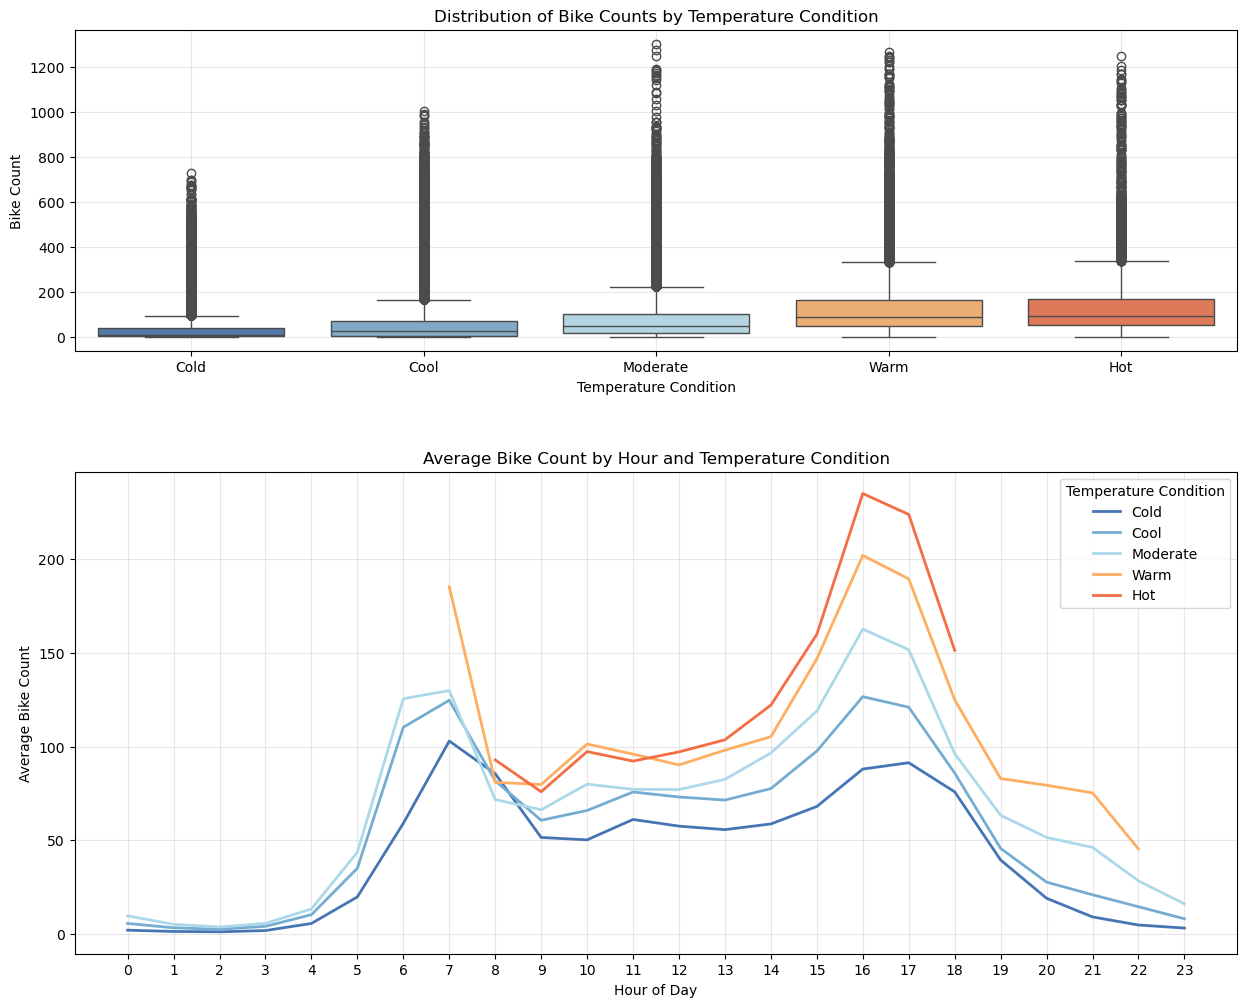


Summary Statistics for each Temperature Category:
                  count   mean    std  min   25%   50%    75%     max
temp_category                                                        
Cold           112564.0   33.5   60.6  0.0   1.0   8.0   38.0   729.0
Cool           232671.0   52.0   78.2  0.0   4.0  23.0   68.0  1005.0
Moderate       100182.0   75.4   92.1  0.0  17.0  46.0   99.0  1302.0
Warm            33816.0  124.4  122.7  0.0  47.0  86.0  161.0  1267.0
Hot             17594.0  129.0  125.2  0.0  50.0  90.0  165.0  1252.0

Number of hours in each temperature category:
Cold: 112564 hours (22.7%)
Cool: 232671 hours (46.8%)
Moderate: 100182 hours (20.2%)
Warm: 33816 hours (6.8%)
Hot: 17594 hours (3.5%)

Peak hours for bike rentals by temperature condition:
Cold: 7:00 (avg 103.0 bikes)
Cool: 16:00 (avg 126.6 bikes)
Moderate: 16:00 (avg 162.7 bikes)
Warm: 16:00 (avg 202.0 bikes)
Hot: 16:00 (avg 235.0 bikes)

Correlation between temperature and bike count: 0.3

Temperature Range

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2754957336.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = data.groupby('temp_category')['bike_count'].describe().round(1)


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create temperature categories with new optimized bins
bins = [-float('inf'), 5, 15, 22, 28, float('inf')]
labels = ['Cold', 'Cool', 'Moderate', 'Warm', 'Hot']
data['temp_category'] = pd.cut(data['TNSOL'], bins=bins, labels=labels)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.5], hspace=0.3)

# 1. Boxplot of bike counts by temperature category
ax1 = fig.add_subplot(gs[0])
# Updated color palette for 5 categories
sns.boxplot(x='temp_category', y='bike_count', data=data, 
            palette=['#4575b4', '#74add1', '#abd9e9', '#fdae61', '#f46d43'])
plt.title('Distribution of Bike Counts by Temperature Condition')
plt.xlabel('Temperature Condition')
plt.ylabel('Bike Count')
plt.grid(True, alpha=0.3)

# 2. Hourly patterns by temperature category
ax2 = fig.add_subplot(gs[1])
hourly_averages = data.groupby(['hour', 'temp_category'])['bike_count'].mean().unstack()

# Updated color dictionary for new categories
colors = {
    'Cold': '#4575b4',
    'Cool': '#74add1',
    'Moderate': '#abd9e9',
    'Warm': '#fdae61',
    'Hot': '#f46d43'
}

for category in hourly_averages.columns:
    plt.plot(hourly_averages.index, 
             hourly_averages[category], 
             label=f'{category}',
             color=colors[category],
             linewidth=2)

plt.title('Average Bike Count by Hour and Temperature Condition')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.grid(True, alpha=0.3)
plt.legend(title='Temperature Condition')
plt.xticks(range(24))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for each Temperature Category:")
summary_stats = data.groupby('temp_category')['bike_count'].describe().round(1)
print(summary_stats)

# Calculate and print temperature category distribution
temp_counts = data['temp_category'].value_counts().sort_index()
print("\nNumber of hours in each temperature category:")
for category, count in temp_counts.items():
    percentage = round((count / len(data) * 100), 1) if len(data) > 0 else 0
    print(f"{category}: {count} hours ({percentage}%)")

# Calculate peak hours for each temperature category
peak_hours = hourly_averages.idxmax()
print("\nPeak hours for bike rentals by temperature condition:")
for category, hour in peak_hours.items():
    avg_bikes = round(hourly_averages[category][hour], 1)
    print(f"{category}: {hour}:00 (avg {avg_bikes} bikes)")

# Calculate correlation between temperature and bike count
correlation = data['TNSOL'].corr(data['bike_count'])
if pd.notna(correlation):
    correlation = round(correlation, 3)
print(f"\nCorrelation between temperature and bike count: {correlation}")

# Add temperature range information
print("\nTemperature Ranges:")
print("Cold: < 5°C")
print("Cool: 5-15°C")
print("Moderate: 15-22°C")
print("Warm: 22-28°C")
print("Hot: > 28°C")

### Humidity

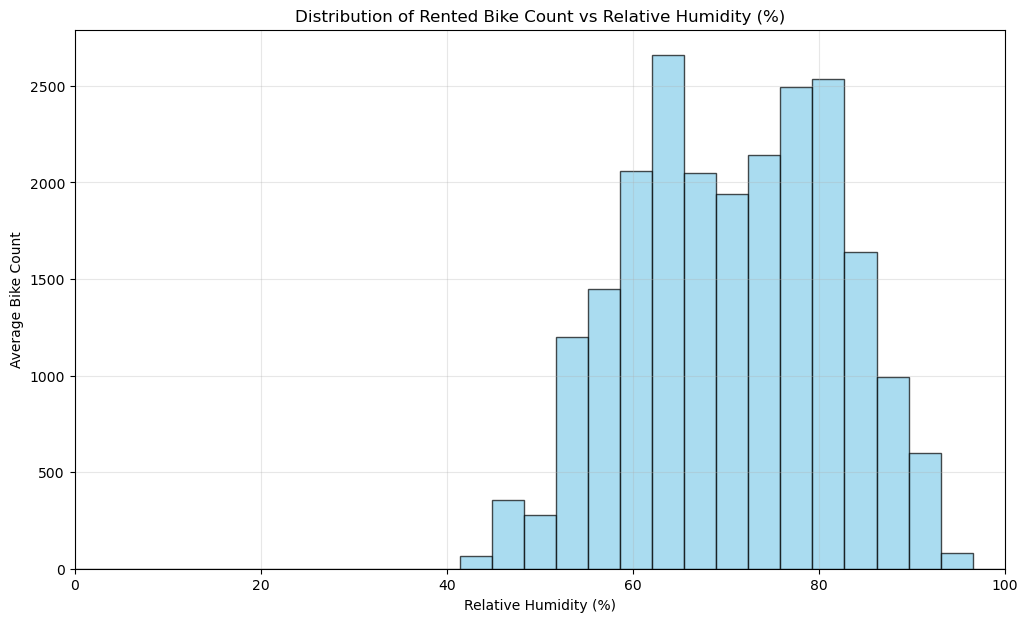


Daily Humidity and Bike Count Summary:
            U  bike_count
count  374.00      374.00
mean    72.69       60.27
std     10.94       22.55
min     43.73        6.30
25%     64.26       47.79
50%     73.76       56.83
75%     81.41       72.44
max     93.85      124.51

Correlation between humidity and bike count: -0.48

Humidity Level Analysis:

Low Humidity (0-40%):
  Average daily bikes: nan
  Number of days: 0 (0.0%)

Moderate Humidity (40-60%):
  Average daily bikes: 74.7
  Number of days: 54 (14.4%)

High Humidity (60-80%):
  Average daily bikes: 64.1
  Number of days: 206 (55.1%)

Very High Humidity (80-100%):
  Average daily bikes: 46.5
  Number of days: 114 (30.5%)


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate daily averages
daily_avg = data.groupby(pd.to_datetime(data['date']).dt.date).agg({
    'U': 'mean',
    'bike_count': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))

# Create weighted histogram for humidity
# Using bins from 0 to 100 since humidity is in percentage
bins = np.linspace(0, 100, 30)
plt.hist(daily_avg['U'], bins=bins, weights=daily_avg['bike_count'], 
         color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Rented Bike Count vs Relative Humidity (%)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Average Bike Count')
plt.grid(True, alpha=0.3)

# Add some padding to x-axis to make it more readable
plt.margins(x=0.05)

# Ensure x-axis shows full humidity range
plt.xlim(0, 100)

plt.show()

# Print summary statistics
print("\nDaily Humidity and Bike Count Summary:")
print(daily_avg.describe().round(2))

# Calculate correlation
correlation = daily_avg['U'].corr(daily_avg['bike_count']).round(3)
print(f"\nCorrelation between humidity and bike count: {correlation}")

# Add some additional analysis
print("\nHumidity Level Analysis:")
humidity_ranges = [
    (0, 40, 'Low Humidity'),
    (40, 60, 'Moderate Humidity'),
    (60, 80, 'High Humidity'),
    (80, 100, 'Very High Humidity')
]

for low, high, label in humidity_ranges:
    mask = (daily_avg['U'] >= low) & (daily_avg['U'] < high)
    avg_bikes = daily_avg.loc[mask, 'bike_count'].mean()
    days = mask.sum()
    percentage = (days / len(daily_avg) * 100)
    print(f"\n{label} ({low}-{high}%):")
    print(f"  Average daily bikes: {avg_bikes:.1f}")
    print(f"  Number of days: {days} ({percentage:.1f}%)")


Humidity Summary Statistics:
count    496827.00
mean         72.66
std          15.88
min          22.00
25%          62.00
50%          76.00
75%          85.50
max          97.50
Name: U, dtype: float64

Humidity Category Statistics:


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1937537071.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in data.groupby('humidity_category'):


Low Humidity (0-50%):
  Hours: 58016 (11.7%)
  Average Humidity: 42.3%
Moderate Humidity (50-65%):
  Hours: 89248 (18.0%)
  Average Humidity: 58.3%
Optimal Humidity (65-80%):
  Hours: 150470 (30.3%)
  Average Humidity: 73.5%
High Humidity (80-100%):
  Hours: 199093 (40.1%)
  Average Humidity: 87.3%


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1937537071.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


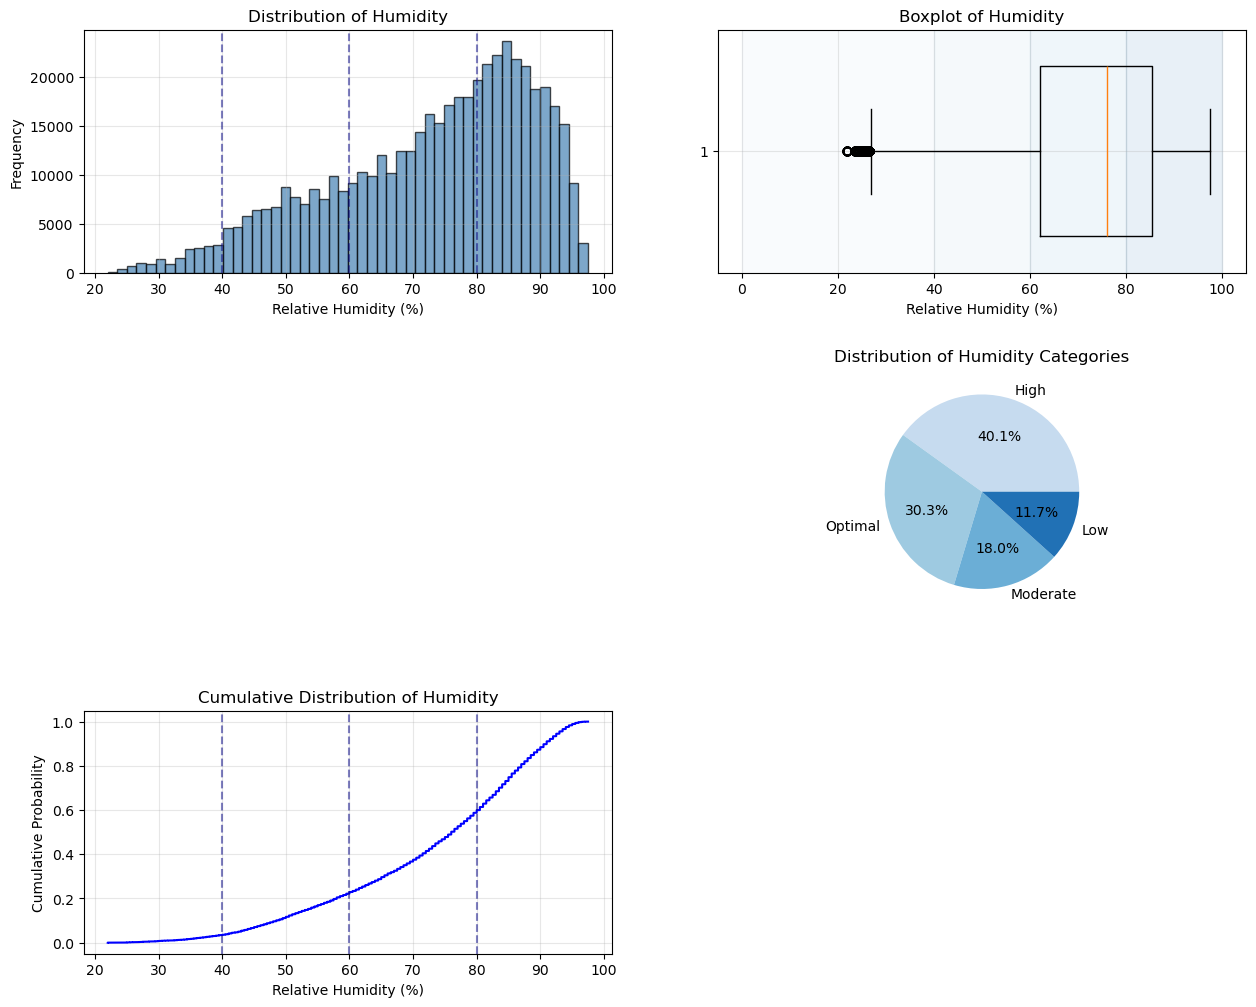

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4)

# 1. Basic histogram of humidity
ax1 = fig.add_subplot(gs[0, 0])
plt.hist(data['U'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
# Add vertical lines for category boundaries
for boundary in [40, 60, 80]:
    plt.axvline(x=boundary, color='navy', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Humidity')
ax1.set_xlabel('Relative Humidity (%)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2 = fig.add_subplot(gs[0, 1])
plt.boxplot(data['U'], vert=False, widths=0.7)
# Add background colors for humidity ranges
ax2.axvspan(0, 40, alpha=0.1, color='#c6dbef')
ax2.axvspan(40, 60, alpha=0.1, color='#9ecae1')
ax2.axvspan(60, 80, alpha=0.1, color='#6baed6')
ax2.axvspan(80, 100, alpha=0.1, color='#2171b5')
ax2.set_title('Boxplot of Humidity')
ax2.set_xlabel('Relative Humidity (%)')
ax2.grid(True, alpha=0.3)


# 4. Humidity categories pie chart
bins = [0, 50, 65, 80, 100]
labels = ['Low', 'Moderate', 'Optimal', 'High']
data['humidity_category'] = pd.cut(data['U'], bins=bins, labels=labels)
humidity_counts = data['humidity_category'].value_counts()

ax4 = fig.add_subplot(gs[1, 1])
colors = ['#c6dbef', '#9ecae1', '#6baed6', '#2171b5']
plt.pie(humidity_counts, labels=humidity_counts.index, autopct='%.1f%%',
        colors=colors)
ax4.set_title('Distribution of Humidity Categories')

# 5. Cumulative distribution
ax5 = fig.add_subplot(gs[2, 0])
sorted_humidity = np.sort(data['U'])
cumulative = np.arange(1, len(sorted_humidity) + 1) / len(sorted_humidity)
plt.plot(sorted_humidity, cumulative, 'b-')
# Add vertical lines for category boundaries
for boundary in [40, 60, 80]:
    plt.axvline(x=boundary, color='navy', linestyle='--', alpha=0.5)
ax5.set_title('Cumulative Distribution of Humidity')
ax5.set_xlabel('Relative Humidity (%)')
ax5.set_ylabel('Cumulative Probability')
ax5.grid(True, alpha=0.3)

# Print summary statistics
print("\nHumidity Summary Statistics:")
print(data['U'].describe().round(2))

# Calculate and print detailed humidity statistics
print("\nHumidity Category Statistics:")
total_hours = len(data)
for category, group in data.groupby('humidity_category'):
    hours = len(group)
    percentage = round((hours / total_hours * 100), 1)
    avg_humidity = round(group['U'].mean(), 1)
    idx = labels.index(category)
    lower_bound = bins[idx]
    upper_bound = bins[idx + 1]
    
    print(f"{category} Humidity ({lower_bound}-{upper_bound}%):")
    print(f"  Hours: {hours} ({percentage}%)")
    print(f"  Average Humidity: {avg_humidity}%")

plt.tight_layout()
plt.show()

### Correlation of the weather feature

In [87]:
data.shape

(496827, 137)

In [88]:
# Function to get correlations for selected columns
def get_selected_correlations(dataframe, selected_columns):
    # Ensure all selected columns exist in the DataFrame
    existing_columns = [col for col in selected_columns if col in dataframe.columns]
    
    if len(existing_columns) != len(selected_columns):
        print(f"Warning: Some selected columns do not exist in the DataFrame.")
        print(f"Proceeding with existing columns: {existing_columns}")
    
    # Calculate correlations for selected columns
    selected_df = dataframe[existing_columns]
    correlation_matrix = selected_df.corr()
    
    return correlation_matrix

In [89]:
data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude',
       ...
       'couvre_feu_21h', 'couvre_feu_20h', 'couvre_feu_18h',
       'couvre_feu_21h_2', 'couvre_feu_23h', 'rayon_deplacement_km',
       'heure_couvre_feu', 'is_during_curfew', 'is_within_allowed_distance',
       'arrondissement'],
      dtype='object', length=137)

In [90]:
# Example usage
selected_columns = [
    'ALTI', 'RR1', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 
    'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'HFXI3S', 'QHFXI3S', 'T', 'QT', 'TD', 'QTD', 
    'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'DG', 'QDG', 'T10', 'QT10', 'T20', 'QT20', 'T50', 'QT50', 
    'T100', 'QT100', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'TCHAUSSEE', 'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'HUN', 
    'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSV', 'QTSV', 'PMER', 'QPMER', 
    'PSTAT', 'QPSTAT', 'PMERMIN', 'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'WW', 'QWW', 'NEIGETOT', 'QNEIGETOT', 
    'GLO', 'QGLO', 'GLO2', 'QGLO2', 'INS', 'QINS', 'INS2', 'QINS2','log_bike_count'
]  # Replace with your desired columns

correlation_matrix = get_selected_correlations(data, selected_columns)

# Display the correlation matrix
print("Correlation Matrix for Selected Columns:")
print(correlation_matrix)

# Display a more readable format with rounded values
print("\nRounded Correlation Matrix for Selected Columns:")
print(correlation_matrix.round(2))

# Get the correlation of one selected column with others


Correlation Matrix for Selected Columns:
                    ALTI       RR1  QRR1      DRR1     QDRR1        FF  \
ALTI            1.000000  0.021343   NaN  0.028579 -0.061501  0.195459   
RR1             0.021343  1.000000   NaN  0.488178  0.002448  0.080725   
QRR1                 NaN       NaN   NaN       NaN       NaN       NaN   
DRR1            0.028579  0.488178   NaN  1.000000 -0.005109  0.182867   
QDRR1          -0.061501  0.002448   NaN -0.005109  1.000000 -0.122407   
...                  ...       ...   ...       ...       ...       ...   
INS            -0.062776 -0.091518   NaN -0.200255  0.003272 -0.088132   
QINS           -0.010301 -0.044391   NaN -0.073935 -0.004040 -0.029365   
INS2           -0.062580 -0.089767   NaN -0.200894  0.003559 -0.085890   
QINS2          -0.011127 -0.058780   NaN -0.083767 -0.004364 -0.031824   
log_bike_count  0.027176 -0.031448   NaN -0.086841  0.026695 -0.005366   

                     QFF        DD  QDD       FXY  QFXY       DXY  QDX

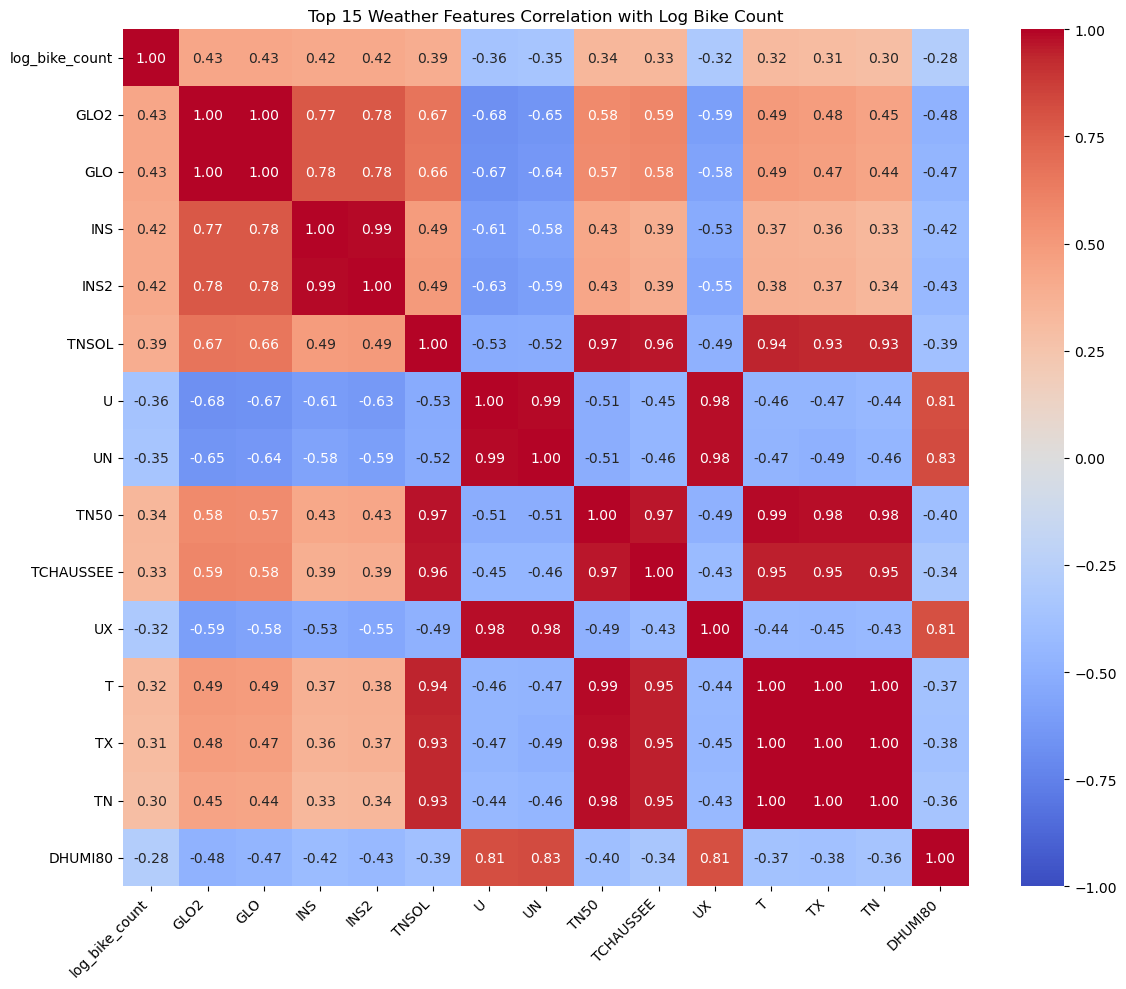


Top 15 correlations with log_bike_count:
log_bike_count    1.000000
GLO2              0.432508
GLO               0.430140
INS               0.418057
INS2              0.417461
TNSOL             0.392347
TN50              0.340316
TCHAUSSEE         0.330116
T                 0.317123
TX                0.310613
TN                0.296408
T10               0.184476
DHUMI40           0.170497
T50               0.168072
T100              0.165727
Name: log_bike_count, dtype: float64


In [91]:
# Get correlations with log_bike_count and sort them
bike_correlations = correlation_matrix['log_bike_count'].sort_values(ascending=False)

# Select top 15 most correlated features (positive or negative)
top_features = bike_correlations.abs().nlargest(15).index

# Create a subset correlation matrix with only the top features
top_correlation_matrix = correlation_matrix.loc[top_features, top_features]

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(top_correlation_matrix, 
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)

plt.title('Top 15 Weather Features Correlation with Log Bike Count')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the correlations with log_bike_count
print("\nTop 15 correlations with log_bike_count:")
print(bike_correlations.head(15))

- GLO : rayonnement global horaire en heure UTC (en J/cm2)
- GLO 2 : rayonnement global horaire en heure TSV (en J/cm2)
- INS  : insolation horaire en heure UTC (en mn)
- TNSOL : tempÃ©rature minimale Ã  50 cm au-dessus du sol (en Â°C et 1/10)
- DHUMI40 : durÃ©e avec humiditÃ© â‰¤ 40% 


Correlations with log_bike_count (sorted):
log_bike_count    1.000000
GLO               0.430140
INS               0.418057
TNSOL             0.392347
DHUMI40           0.170497
TSV               0.158916
VV                0.128991
HXY               0.123183
QTSV              0.100904
FXI3S             0.060654
FXI               0.057984
PSTAT             0.042780
DD                0.035714
PMER              0.035095
PMERMIN           0.034478
QNEIGETOT         0.032731
ALTI              0.027176
QDRR1             0.026695
DXY               0.017009
FXY               0.014446
QPMER             0.005123
DXI               0.002923
QFF               0.001669
QGLO2            -0.002699
QGLO             -0.002701
FF               -0.005366
QHFXI3S          -0.005422
QFXI3S           -0.026143
RR1              -0.031448
NEIGETOT         -0.042279
DRR1             -0.086841
DG               -0.089740
U                -0.361715
QRR1                   NaN
QDD                    NaN
QFXY       

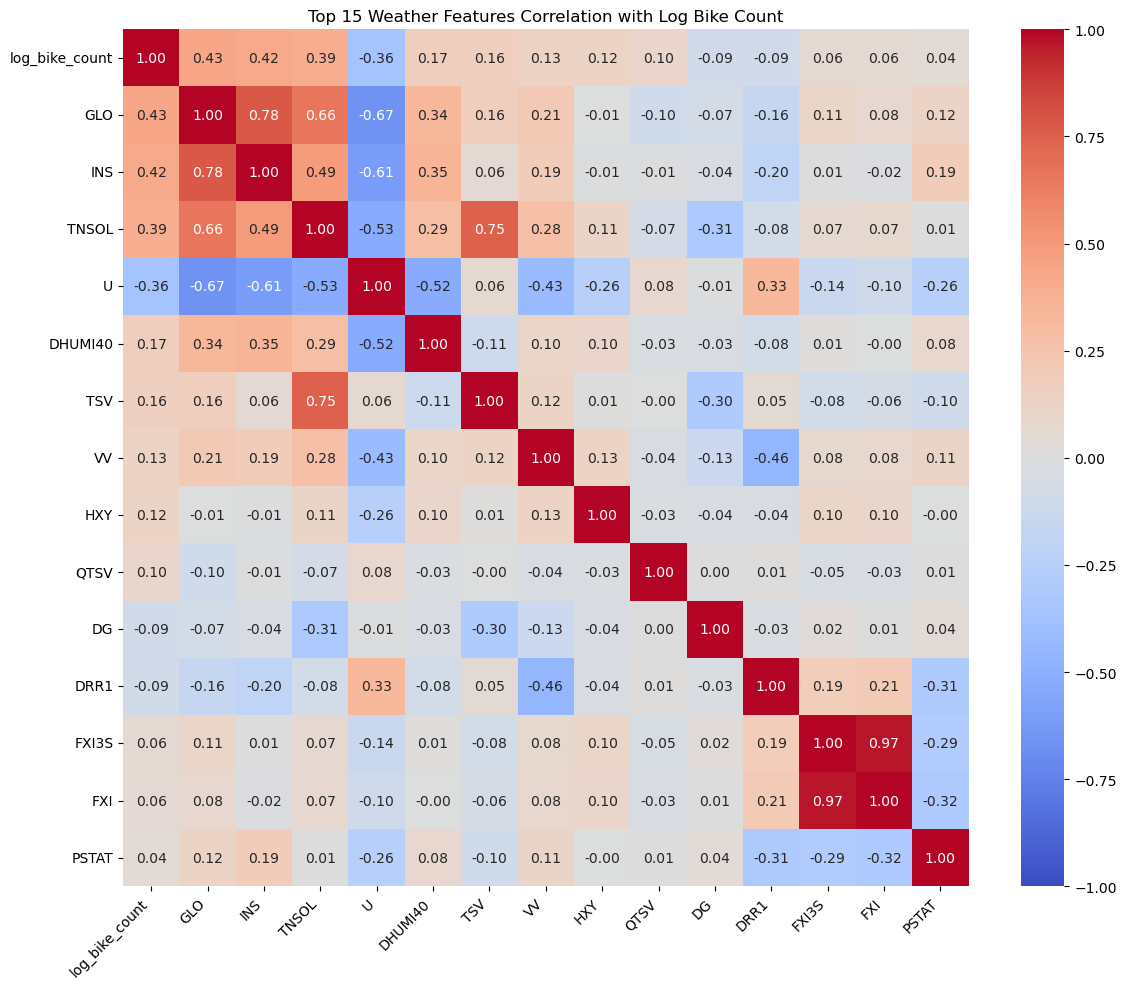


Top 15 correlations with log_bike_count:
log_bike_count    1.000000
GLO               0.430140
INS               0.418057
TNSOL             0.392347
DHUMI40           0.170497
TSV               0.158916
VV                0.128991
HXY               0.123183
QTSV              0.100904
FXI3S             0.060654
FXI               0.057984
PSTAT             0.042780
DD                0.035714
PMER              0.035095
PMERMIN           0.034478
Name: log_bike_count, dtype: float64


In [92]:
# Deleting the features correlated with each other 

# Define the columns to drop

selected_columns = [
    'ALTI', 'RR1', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 
    'FXI', 'QFXI', 'DXI', 'QDXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QHFXI3S', 
     'QHTN', 'QHTX', 'DG', 'QDG', 'QT100', 'TNSOL', 'U', 
    'QHUN', 'QHUX', 'DHUMI40', 'QDHUMI40', 'QDHUMI80', 'TSV', 'QTSV', 'PMER', 'QPMER', 
    'PSTAT', 'QPSTAT', 'PMERMIN', 'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'QWW', 'NEIGETOT', 'QNEIGETOT', 
    'GLO', 'QGLO', 'QGLO2', 'INS','log_bike_count'
] 

correlation_matrix = get_selected_correlations(data, selected_columns)

# Get the correlation of one selected column with others
if 'log_bike_count' in correlation_matrix.columns:
    bike_correlations = correlation_matrix['log_bike_count'].sort_values(ascending=False)
    print("\nCorrelations with log_bike_count (sorted):")
    print(bike_correlations)

# Get correlations with log_bike_count and sort them
bike_correlations = correlation_matrix['log_bike_count'].sort_values(ascending=False)

# Select top 15 most correlated features (positive or negative)
top_features = bike_correlations.abs().nlargest(15).index

# Create a subset correlation matrix with only the top features
top_correlation_matrix = correlation_matrix.loc[top_features, top_features]

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(top_correlation_matrix, 
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)

plt.title('Top 15 Weather Features Correlation with Log Bike Count')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the correlations with log_bike_count
print("\nTop 15 correlations with log_bike_count:")
print(bike_correlations.head(15))

# Create a list of the features top 15

top_features = bike_correlations.abs().nlargest(15).index

In [93]:
top_features

Index(['log_bike_count', 'GLO', 'INS', 'TNSOL', 'U', 'DHUMI40', 'TSV', 'VV',
       'HXY', 'QTSV', 'DG', 'DRR1', 'FXI3S', 'FXI', 'PSTAT'],
      dtype='object')

In [94]:
# Without log by count 

top_features = top_features.drop('log_bike_count')
top_features

Index(['GLO', 'INS', 'TNSOL', 'U', 'DHUMI40', 'TSV', 'VV', 'HXY', 'QTSV', 'DG',
       'DRR1', 'FXI3S', 'FXI', 'PSTAT'],
      dtype='object')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1048459947.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  glo_means = data.groupby('GLO_bins')['log_bike_count'].mean()
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1048459947.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ins_means = data.groupby('INS_bins')['log_bike_count'].mean()
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1048459947.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

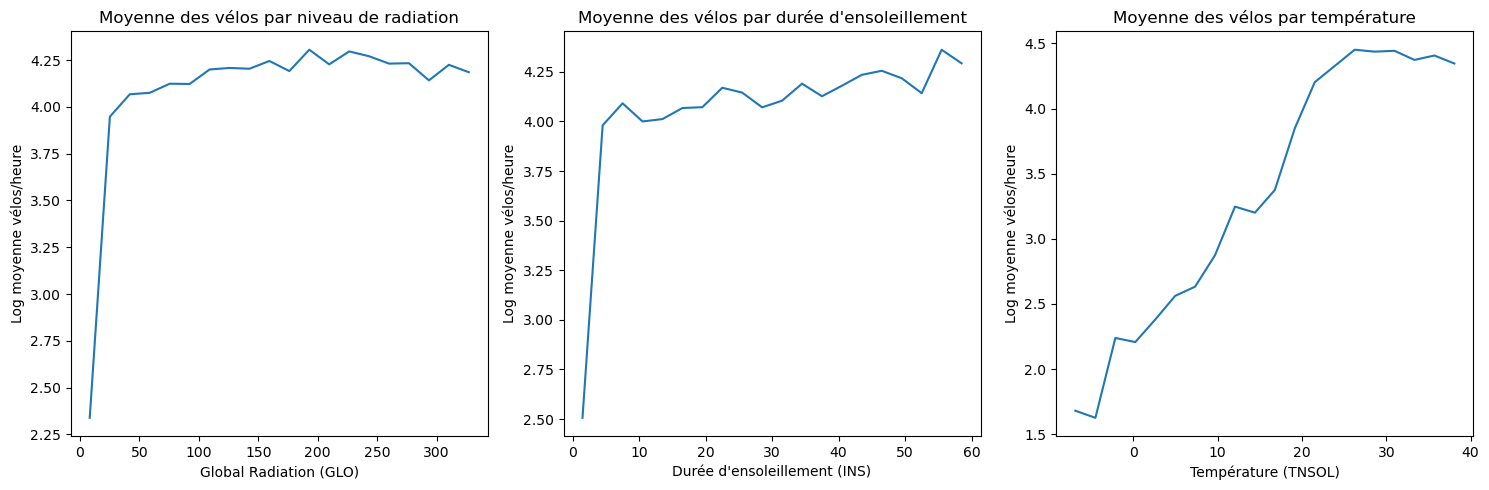


Moyenne de vélos par tranche de température:
                    mean  count
TNSOL_bins                     
(-8.097, -5.685]   13.35   1904
(-5.685, -3.32]    18.43   6032
(-3.32, -0.955]    34.35  14390
(-0.955, 1.41]     30.38  25080
(1.41, 3.775]      35.39  41374
(3.775, 6.14]      40.28  44300
(6.14, 8.505]      42.04  52536
(8.505, 10.87]     49.18  62166
(10.87, 13.235]    61.98  53672
(13.235, 15.6]     60.12  56605
(15.6, 17.965]     65.53  44478
(17.965, 20.33]    83.26  28086
(20.33, 22.695]   106.15  20352
(22.695, 25.06]   118.16  15536
(25.06, 27.425]   137.41   9618
(27.425, 29.79]   132.32   8706
(29.79, 32.155]   133.55   5928
(32.155, 34.52]   127.70   3342
(34.52, 36.885]   120.37   1888
(36.885, 39.25]   119.01    834


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1048459947.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_stats = data.groupby('TNSOL_bins')['bike_count'].agg(['mean', 'count']).round(2)


In [95]:
# Pour GLO (Global Radiation)
plt.figure(figsize=(15, 5))

# 1. GLO binning
plt.subplot(131)
data['GLO_bins'] = pd.cut(data['GLO'], bins=20)
glo_means = data.groupby('GLO_bins')['log_bike_count'].mean()
plt.plot([(x.left + x.right)/2 for x in glo_means.index], glo_means.values)
plt.title('Moyenne des vélos par niveau de radiation')
plt.xlabel('Global Radiation (GLO)')
plt.ylabel('Log moyenne vélos/heure')

# 2. INS (Sunshine Duration) binning
plt.subplot(132)
data['INS_bins'] = pd.cut(data['INS'], bins=20)
ins_means = data.groupby('INS_bins')['log_bike_count'].mean()
plt.plot([(x.left + x.right)/2 for x in ins_means.index], ins_means.values)
plt.title('Moyenne des vélos par durée d\'ensoleillement')
plt.xlabel('Durée d\'ensoleillement (INS)')
plt.ylabel('Log moyenne vélos/heure')

# 3. TNSOL (Temperature) binning
plt.subplot(133)
data['TNSOL_bins'] = pd.cut(data['TNSOL'], bins=20)
temp_means = data.groupby('TNSOL_bins')['log_bike_count'].mean()
plt.plot([(x.left + x.right)/2 for x in temp_means.index], temp_means.values)
plt.title('Moyenne des vélos par température')
plt.xlabel('Température (TNSOL)')
plt.ylabel('Log moyenne vélos/heure')

plt.tight_layout()
plt.show()

# Afficher les statistiques
print("\nMoyenne de vélos par tranche de température:")
temp_stats = data.groupby('TNSOL_bins')['bike_count'].agg(['mean', 'count']).round(2)
print(temp_stats)

## Date Information

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1998131824.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count"]].sum().plot()


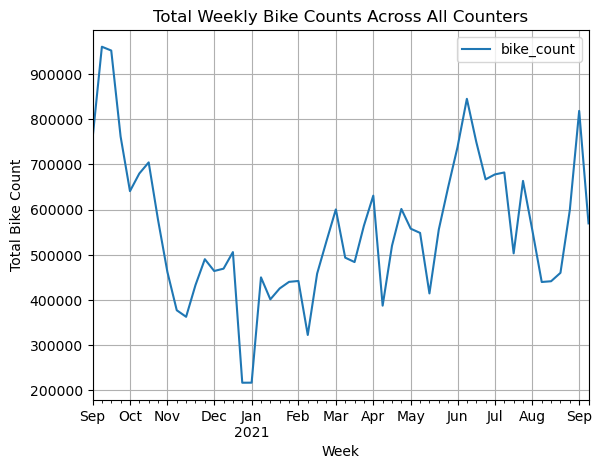

In [96]:
data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count"]].sum().plot()
plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.show()

#### Graph with hollidays

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2934995956.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count", "is_school_holiday"]].agg({


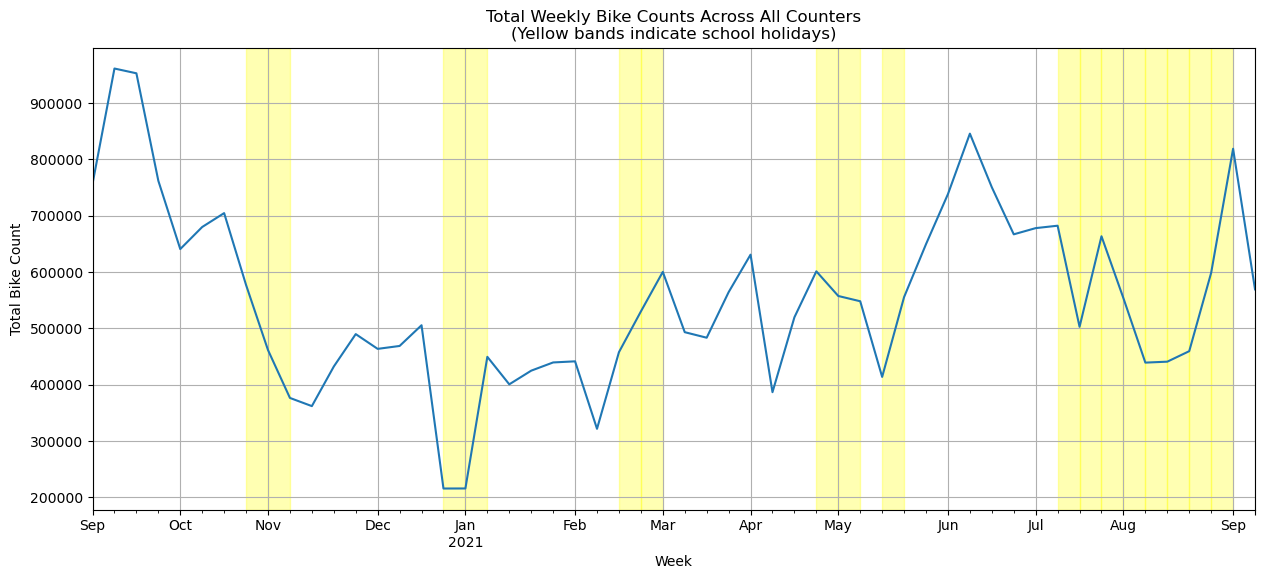

In [97]:
# Get weekly totals
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count", "is_school_holiday"]].agg({
    "bike_count": "sum",
    "is_school_holiday": "mean"  # This gives us the proportion of the week that was holiday
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Highlight holiday periods
holiday_periods = weekly_data[weekly_data["is_school_holiday"] > 0.5].index
for start_date in holiday_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='yellow', alpha=0.3)

plt.title("Total Weekly Bike Counts Across All Counters\n(Yellow bands indicate school holidays)")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.show()

#### Lowkdowns

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/3043457854.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[


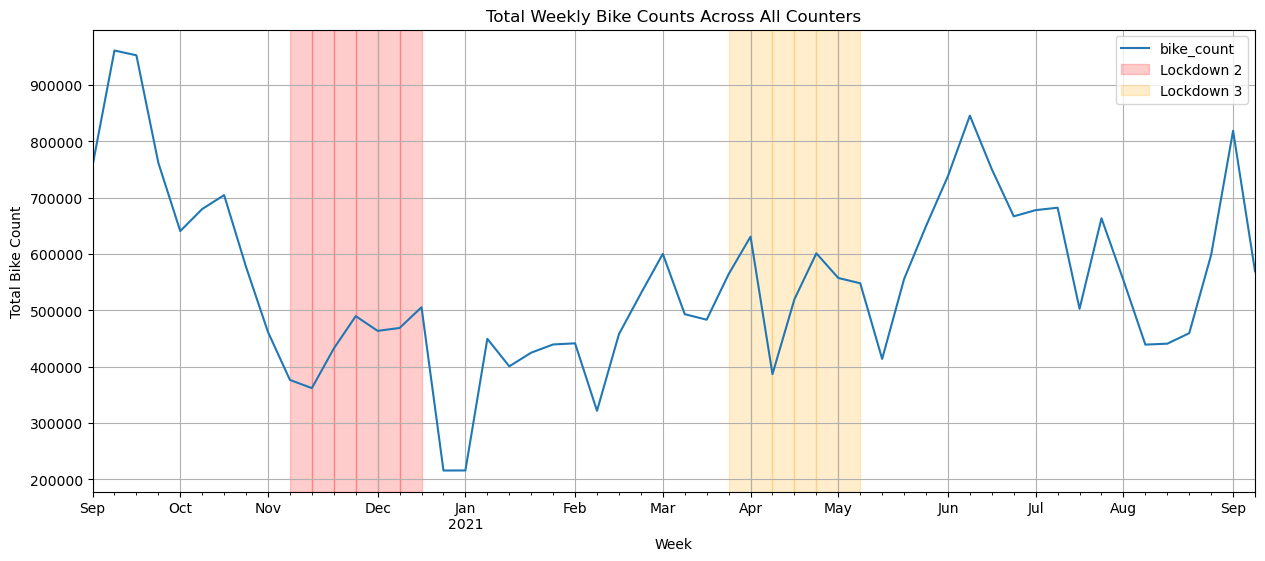

In [98]:
# Get weekly totals and restrictions
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[
    ["bike_count", "confinement_2", "confinement_3"]
].agg({
    "bike_count": "sum",
    "confinement_2": "mean",
    "confinement_3": "mean"
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Highlight lockdown periods
lockdown2_periods = weekly_data[weekly_data["confinement_2"] > 0.5].index
for start_date in lockdown2_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='red', alpha=0.2,
               label='Lockdown 2' if start_date == lockdown2_periods[0] else "")

lockdown3_periods = weekly_data[weekly_data["confinement_3"] > 0.5].index
for start_date in lockdown3_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='orange', alpha=0.2,
               label='Lockdown 3' if start_date == lockdown3_periods[0] else "")

plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.legend()
plt.show()

#### Couvre-feu

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/2679148782.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[


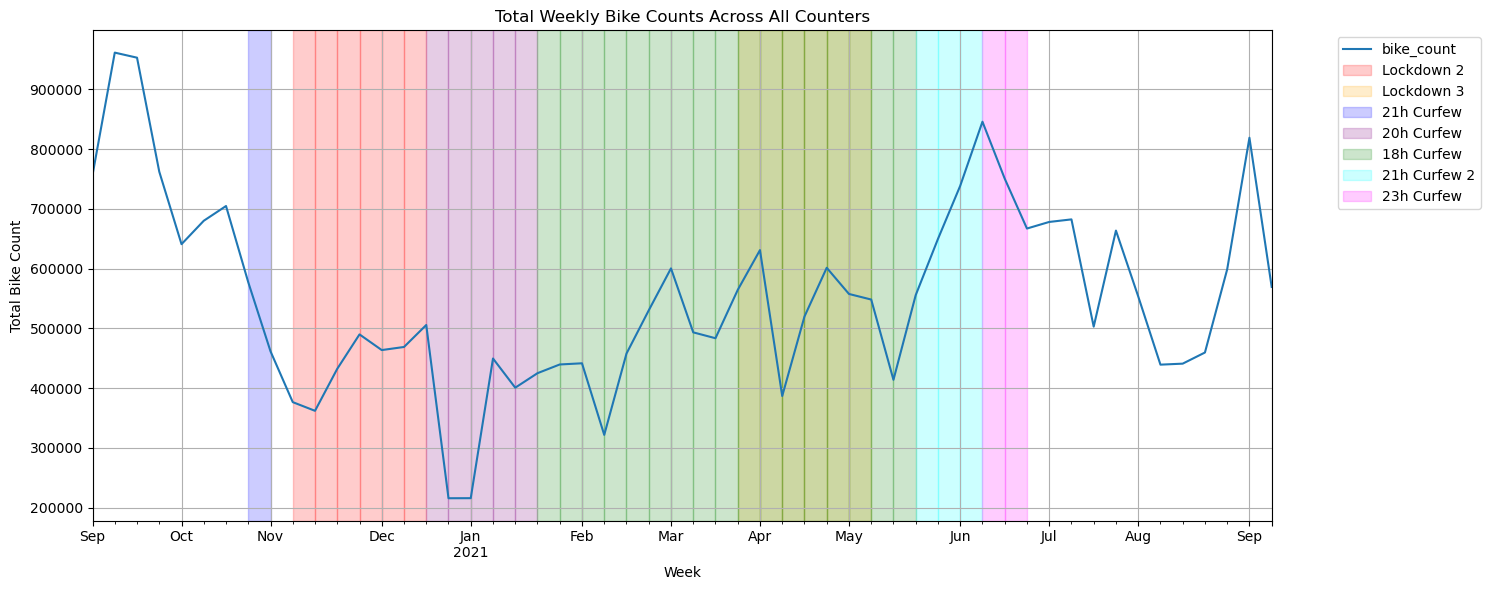

In [99]:
# Get weekly totals and restrictions
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[
    ["bike_count", "confinement_2", "confinement_3", 
     "couvre_feu_21h", "couvre_feu_20h", "couvre_feu_18h", 
     "couvre_feu_21h_2", "couvre_feu_23h"]
].agg({
    "bike_count": "sum",
    "confinement_2": "mean",
    "confinement_3": "mean",
    "couvre_feu_21h": "mean",
    "couvre_feu_20h": "mean",
    "couvre_feu_18h": "mean",
    "couvre_feu_21h_2": "mean",
    "couvre_feu_23h": "mean"
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Define colors for different restrictions
colors = {
    'lockdown2': 'red',
    'lockdown3': 'orange',
    'curfew_21h': 'blue',
    'curfew_20h': 'purple',
    'curfew_18h': 'green',
    'curfew_21h_2': 'cyan',
    'curfew_23h': 'magenta'
}

# Highlight lockdown periods
for start_date in weekly_data[weekly_data["confinement_2"] > 0.5].index:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color=colors['lockdown2'], alpha=0.2,
               label='Lockdown 2' if start_date == weekly_data[weekly_data["confinement_2"] > 0.5].index[0] else "")

for start_date in weekly_data[weekly_data["confinement_3"] > 0.5].index:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color=colors['lockdown3'], alpha=0.2,
               label='Lockdown 3' if start_date == weekly_data[weekly_data["confinement_3"] > 0.5].index[0] else "")

# Highlight curfew periods
curfew_pairs = [
    ("couvre_feu_21h", "21h Curfew", 'curfew_21h'),
    ("couvre_feu_20h", "20h Curfew", 'curfew_20h'),
    ("couvre_feu_18h", "18h Curfew", 'curfew_18h'),
    ("couvre_feu_21h_2", "21h Curfew 2", 'curfew_21h_2'),
    ("couvre_feu_23h", "23h Curfew", 'curfew_23h')
]

for col, label, color_key in curfew_pairs:
    periods = weekly_data[weekly_data[col] > 0.5].index
    for start_date in periods:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=7), 
                  color=colors[color_key], alpha=0.2,
                  label=label if start_date == periods[0] else "")

plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Graph for a particular day and counter

In [100]:
def plot_bike_hourly(data, date, counter_name):
    specific_date = pd.to_datetime(date).date()
    mask = (data["date"].dt.date == specific_date) & (data["counter_name"] == counter_name)
    specific_data = data[mask]
    
    if len(specific_data) == 0:
        print(f"No data available for {date}")
        return
    
    # Get restrictions status
    restrictions = []
    if specific_data['confinement_2'].iloc[0]: restrictions.append("Lockdown 2")
    if specific_data['confinement_3'].iloc[0]: restrictions.append("Lockdown 3")
    if specific_data['couvre_feu_21h'].iloc[0]: restrictions.append("21h Curfew")
    if specific_data['couvre_feu_20h'].iloc[0]: restrictions.append("20h Curfew")
    if specific_data['couvre_feu_18h'].iloc[0]: restrictions.append("18h Curfew")
    if specific_data['couvre_feu_21h_2'].iloc[0]: restrictions.append("21h Curfew 2")
    if specific_data['couvre_feu_23h'].iloc[0]: restrictions.append("23h Curfew")
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    hourly_counts = specific_data.groupby(specific_data["date"].dt.hour)["bike_count"].sum()
    ax.plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
    
    # Add curfew lines if applicable
    for restriction in restrictions:
        if 'Curfew' in restriction:
            curfew_hour = int(restriction.split('h')[0])
            ax.axvline(x=curfew_hour, color='r', linestyle='--', 
                      label=f'Curfew ({curfew_hour}:00)')
            ax.axvline(x=6, color='g', linestyle='--', 
                      label='6:00 (Curfew End)')
    
    # Formatting
    day_name = pd.to_datetime(date).strftime('%A')
    title = f"Bike Count on {date} ({day_name})\n"
    title += "Restrictions: " + ", ".join(restrictions) if restrictions else "No restrictions"
    
    ax.set_title(title)
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

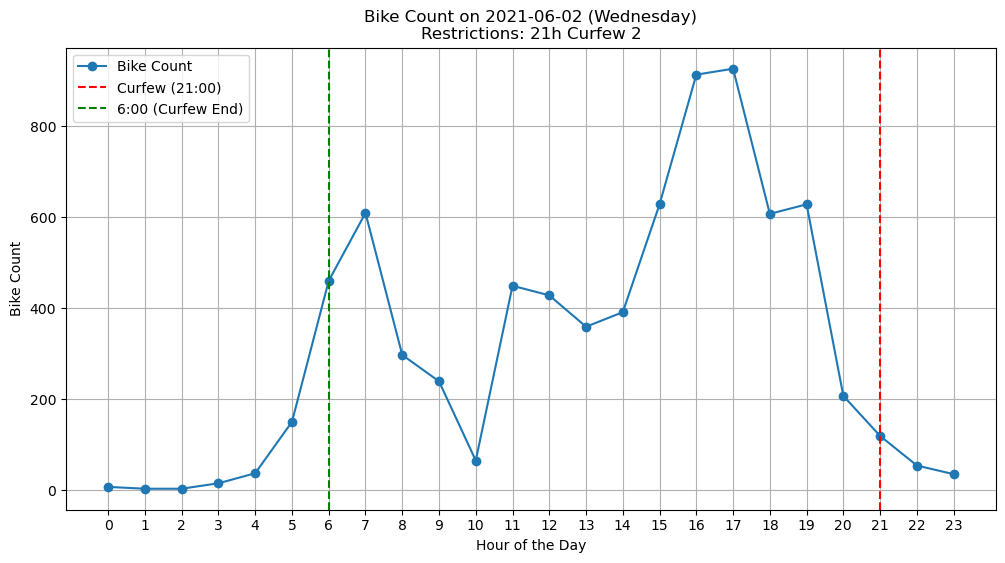

In [101]:
# Example usage:
plot_bike_hourly(data, "2021-06-02", "Totem 73 boulevard de Sébastopol S-N")

#### For all counters

In [102]:
def plot_total_bike_hourly(data, date):
    specific_date = pd.to_datetime(date).date()
    mask = data["date"].dt.date == specific_date
    specific_data = data[mask]
    
    if len(specific_data) == 0:
        print(f"No data available for {date}")
        return
    
    # Get restrictions status
    restrictions = []
    if specific_data['confinement_2'].iloc[0]: restrictions.append("Lockdown 2")
    if specific_data['confinement_3'].iloc[0]: restrictions.append("Lockdown 3")
    if specific_data['couvre_feu_21h'].iloc[0]: restrictions.append("21h Curfew")
    if specific_data['couvre_feu_20h'].iloc[0]: restrictions.append("20h Curfew")
    if specific_data['couvre_feu_18h'].iloc[0]: restrictions.append("18h Curfew")
    if specific_data['couvre_feu_21h_2'].iloc[0]: restrictions.append("21h Curfew 2")
    if specific_data['couvre_feu_23h'].iloc[0]: restrictions.append("23h Curfew")
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    hourly_counts = specific_data.groupby(specific_data["date"].dt.hour)["bike_count"].sum()
    ax.plot(hourly_counts.index, hourly_counts.values, marker='o', label='Total Bike Count')
    
    # Add curfew lines if applicable
    for restriction in restrictions:
        if 'Curfew' in restriction:
            curfew_hour = int(restriction.split('h')[0])
            ax.axvline(x=curfew_hour, color='r', linestyle='--', 
                      label=f'Curfew ({curfew_hour}:00)')
            ax.axvline(x=6, color='g', linestyle='--', 
                      label='6:00 (Curfew End)')
    
    # Formatting
    day_name = pd.to_datetime(date).strftime('%A')
    title = f"Total Bike Count on {date} ({day_name})\n"
    title += "Restrictions: " + ", ".join(restrictions) if restrictions else "No restrictions"
    
    ax.set_title(title)
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Total Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

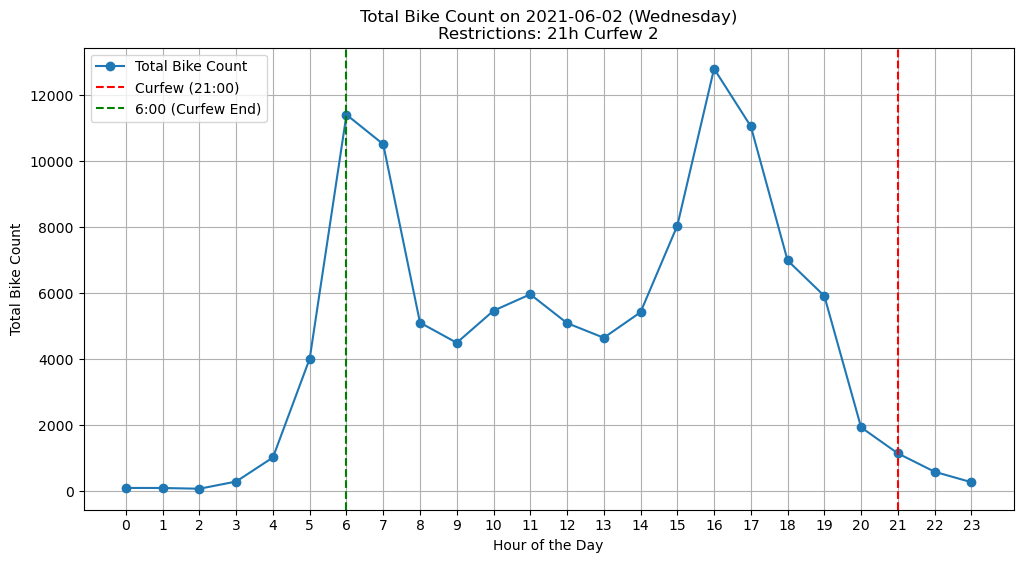

In [103]:
# Example usage:

plot_total_bike_hourly(data, "2021-06-02")

#### Information per week

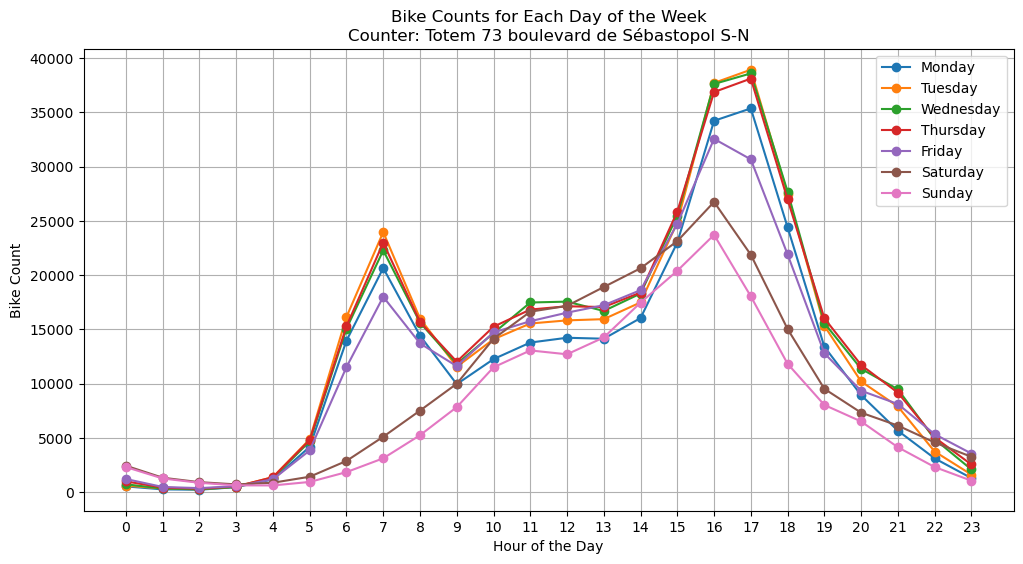

In [104]:
def plot_weekly_bike_counts(data, counter_name):
    # Filter data for the specific counter
    mask = data["counter_name"] == counter_name
    counter_data = data[mask]
    
    if len(counter_data) == 0:
        print(f"No data available for counter: {counter_name}")
        return
    
    # Create a pivot table to aggregate bike counts by hour and weekday
    pivot_table = counter_data.pivot_table(
        values="bike_count", 
        index=counter_data["date"].dt.hour, 
        columns=counter_data["date"].dt.weekday, 
        aggfunc="sum" # Total bike count for each hour of each weekday in the dateframe
    )
    
    # Plot the bike counts for each day of the week
    fig, ax = plt.subplots(figsize=(12, 6))
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    for i, day in enumerate(days):
        if i in pivot_table.columns:
            ax.plot(pivot_table.index, pivot_table[i], marker='o', label=day)
    
    # Formatting
    ax.set_title(f"Bike Counts for Each Day of the Week\nCounter: {counter_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

# Example usage:
plot_weekly_bike_counts(data, "Totem 73 boulevard de Sébastopol S-N")

## Detecting Outliers

## Feature Repartition

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

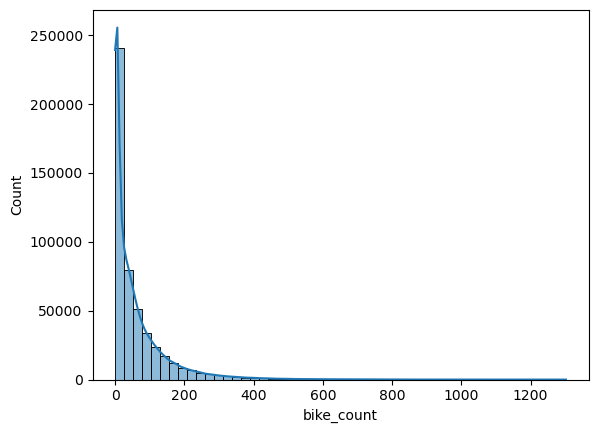

In [19]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

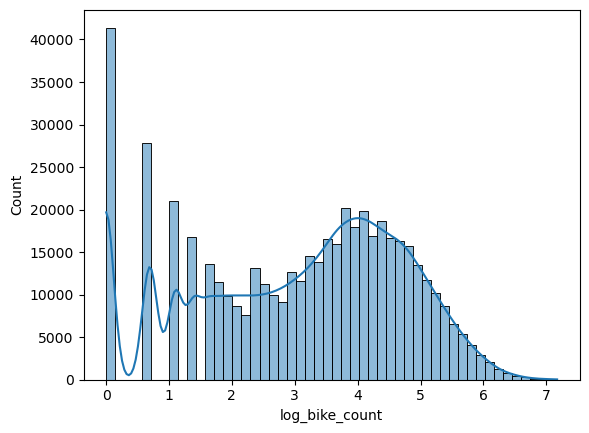

In [20]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

Text(0.5, 1.0, 'Distribution of Zero Counts by Day of Week')

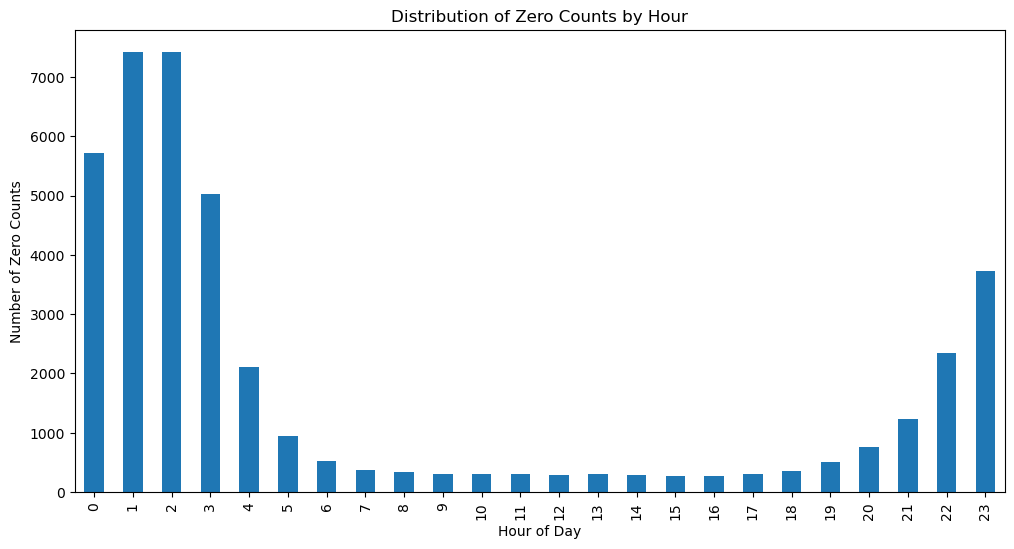

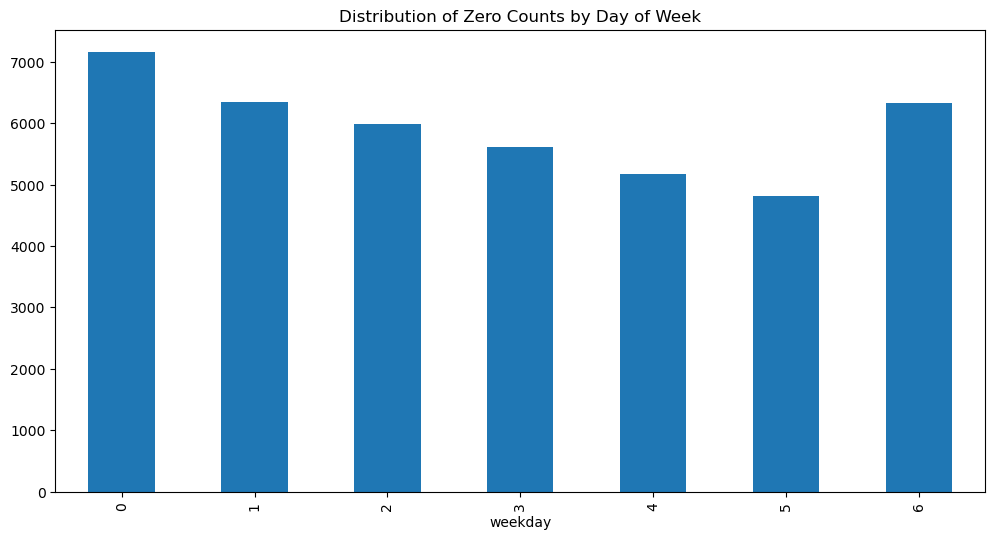

In [21]:
# Time-based patterns of zeros
zeros_data = data[data['bike_count'] == 0]

# By hour
plt.figure(figsize=(12, 6))
zeros_data['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Zero Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Zero Counts')

# By day of week
plt.figure(figsize=(12, 6))
zeros_data['weekday'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Zero Counts by Day of Week')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_20489/3415442623.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_zeros = data.pivot_table(


Text(0.5, 1.0, 'Percentage of Zeros by Counter and Hour')

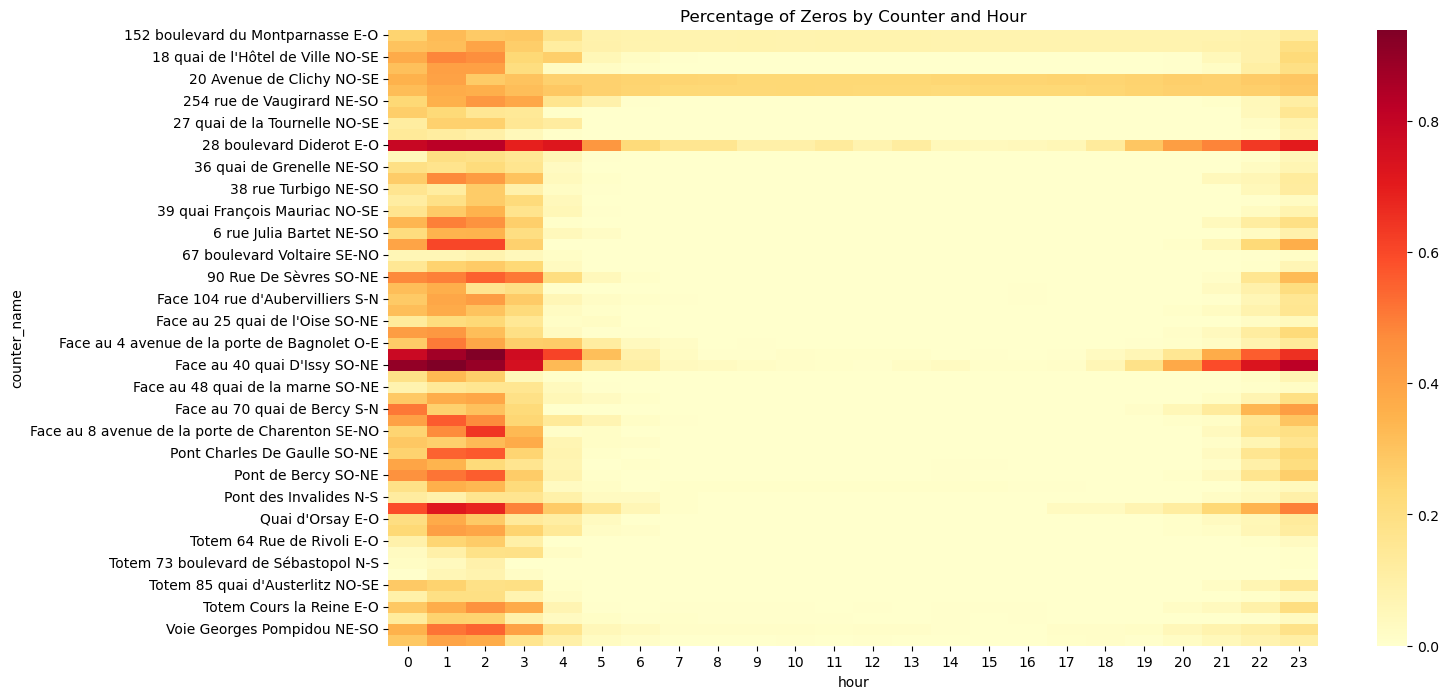

In [22]:
# Heatmap of zeros by counter location
pivot_zeros = data.pivot_table(
    values='bike_count',
    index='counter_name',
    columns='hour',
    aggfunc=lambda x: (x == 0).mean()
)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_zeros, cmap='YlOrRd')
plt.title('Percentage of Zeros by Counter and Hour')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_20489/1103880751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_counts = data[data['bike_count'] == 0].groupby('counter_name').size()
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_20489/1103880751.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_zeros_top_20 = top_20_data.pivot_table(


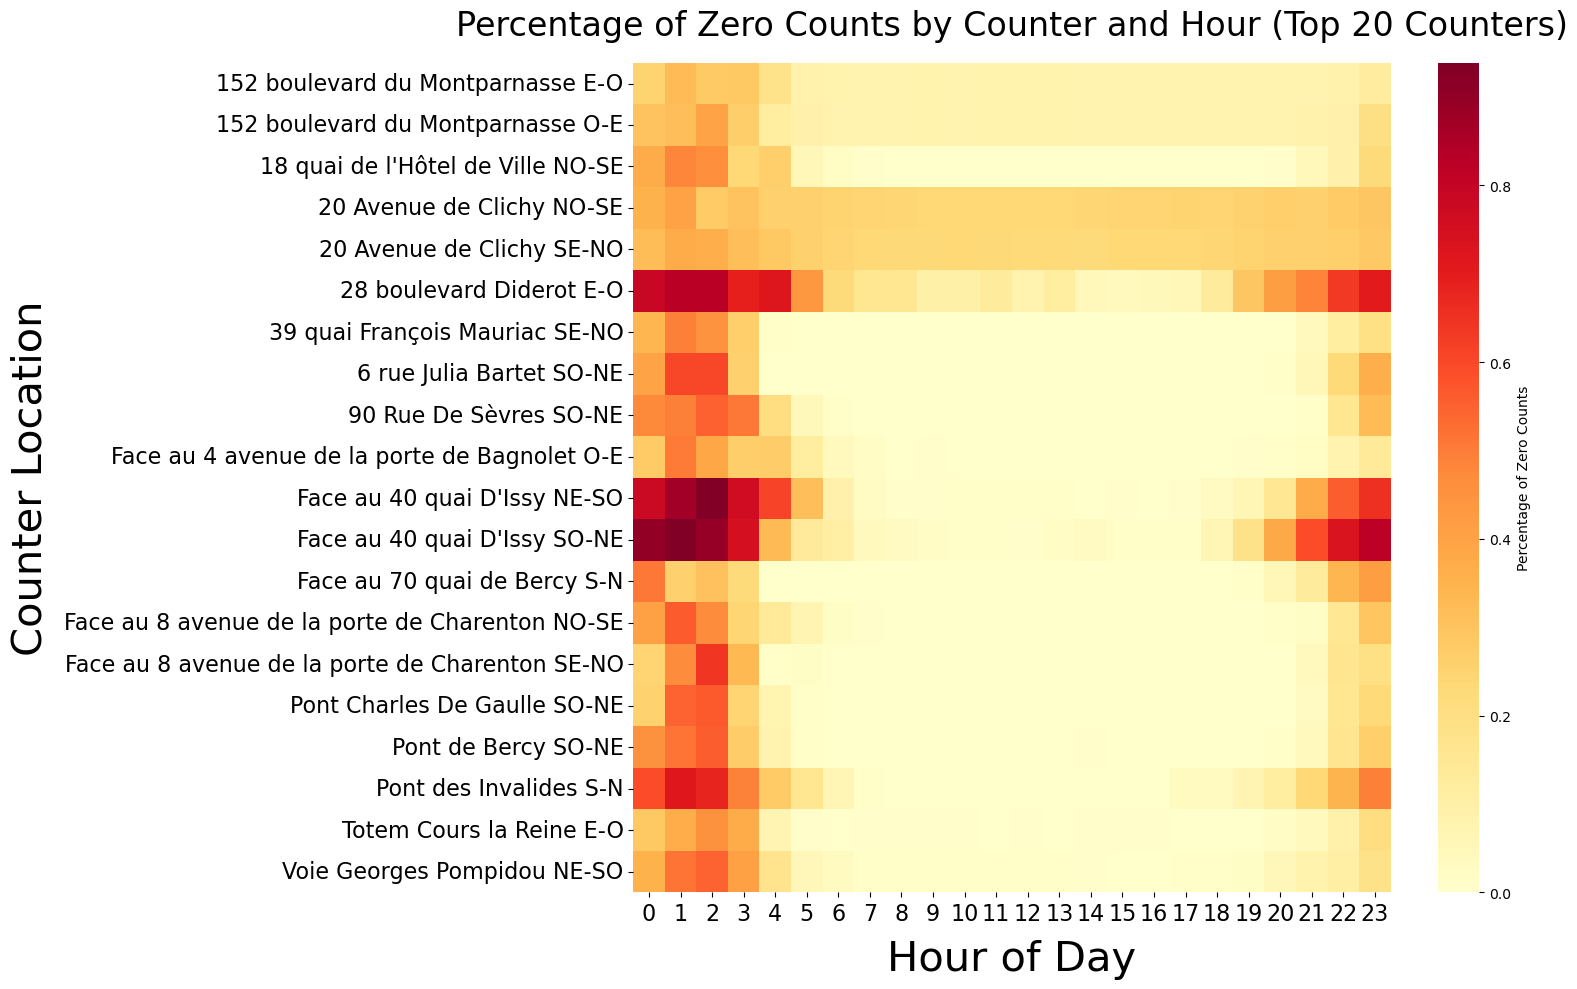

In [27]:
# Calculate the total zero counts for each counter
zero_counts = data[data['bike_count'] == 0].groupby('counter_name').size()

# Select the top 20 counters with the most zero counts
top_20_counters = zero_counts.nlargest(20).index

# Filter the data to include only the top 20 counters
top_20_data = data[data['counter_name'].isin(top_20_counters)]

# Create the pivot table for the heatmap
pivot_zeros_top_20 = top_20_data.pivot_table(
    values='bike_count',
    index='counter_name',
    columns='hour',
    aggfunc=lambda x: (x == 0).mean()
)

plt.figure(figsize=(16, 10))  # Larger figure size

# Create the heatmap
sns.heatmap(pivot_zeros_top_20, 
    cmap='YlOrRd',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Percentage of Zero Counts'})

# Customize the plot
plt.title('Percentage of Zero Counts by Counter and Hour (Top 20 Counters)', 
    fontsize=24, 
    pad=20)
plt.xlabel('Hour of Day', fontsize=30, labelpad=10)
plt.ylabel('Counter Location', fontsize=30, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [24]:
# Create a detailed zeros analysis table
zeros_analysis = pd.DataFrame({
    'total_zeros': [len(zeros_data)],
    'percentage_zeros': [len(zeros_data) / len(data) * 100],
    'zeros_weekday': [len(zeros_data[zeros_data['weekday'] < 5])],
    'zeros_weekend': [len(zeros_data[zeros_data['weekday'] >= 5])],
    'zeros_night_hours': [len(zeros_data[zeros_data['hour'].isin(range(23, 24)) | zeros_data['hour'].isin(range(0, 5))])],
    'zeros_day_hours': [len(zeros_data[~zeros_data['hour'].isin(range(23, 24)) & ~zeros_data['hour'].isin(range(0, 5))])],
})

# Print patterns around zeros
print("Records just before zero counts:")
print(data[data['bike_count'].shift(-1) == 0]['bike_count'].describe())

print("\nRecords just after zero counts:")
print(data[data['bike_count'].shift(1) == 0]['bike_count'].describe())

Records just before zero counts:
count    41400.000000
mean        36.600024
std         59.760905
min          0.000000
25%          2.000000
50%         11.000000
75%         49.000000
max       1250.000000
Name: bike_count, dtype: float64

Records just after zero counts:
count    41401.000000
mean        37.564069
std         60.224984
min          0.000000
25%          2.000000
50%         12.000000
75%         51.000000
max       1250.000000
Name: bike_count, dtype: float64


In [110]:
# Counter-specific statistics - fixed version
counter_stats = (data.groupby('counter_name')
                .agg(
                    zero_rate=('bike_count', lambda x: (x == 0).mean()),
                    night_zero_rate=('bike_count', lambda x: (x[data['is_night'] == 1] == 0).mean())
                )
                .reset_index())

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_15810/1000155032.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counter_stats = (data.groupby('counter_name')


In [111]:
counter_stats.head()

counter_name  zero_rate  night_zero_rate
0  152 boulevard du Montparnasse E-O   0.121320         0.240625
1  152 boulevard du Montparnasse O-E   0.128568         0.267411
2  18 quai de l'Hôtel de Ville NO-SE   0.095164         0.342105
3  18 quai de l'Hôtel de Ville SE-NO   0.071874         0.259144
4          20 Avenue de Clichy NO-SE   0.264653         0.314005

In [112]:
# Add these statistics back to main DataFrame
data = data.merge(counter_stats, on='counter_name')

In [113]:
# Create binary features for low counts
data['is_zero'] = (data['bike_count'] == 0).astype(int)
data['is_very_low'] = (data['bike_count'] <= 2).astype(int)  # Strong pattern in distribution


Text(0.5, 1.0, 'Overall Distribution')

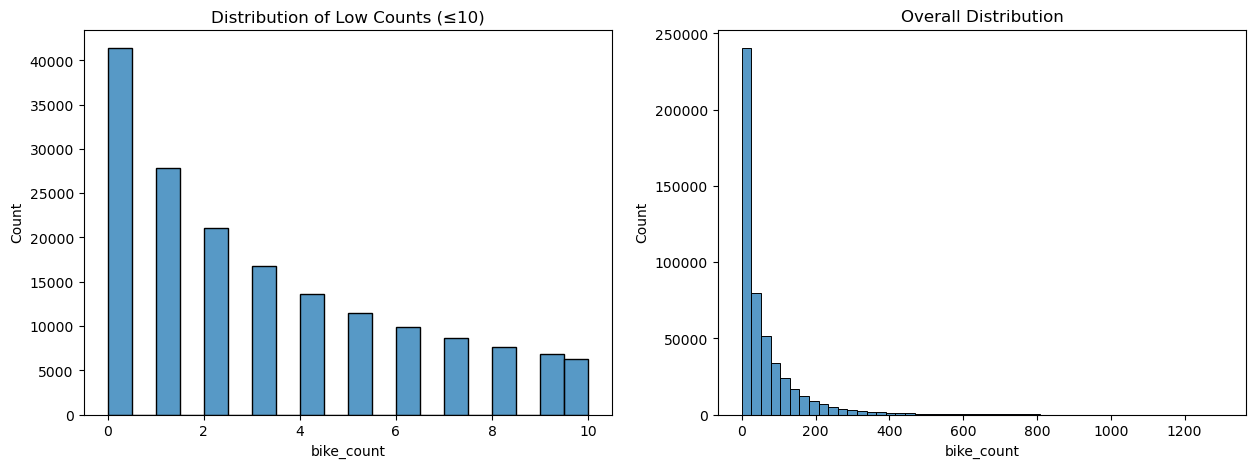

In [114]:
# Compare distribution of values near zero vs overall
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data[data['bike_count'] <= 10]['bike_count'], bins=20)
plt.title('Distribution of Low Counts (≤10)')

plt.subplot(1, 2, 2)
sns.histplot(data['bike_count'], bins=50)
plt.title('Overall Distribution')